<a href="https://colab.research.google.com/github/Vamsi-Malineni/work/blob/master/nsf_net_50_re_data_driven_adaptive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy
from pyDOE import lhs

# set random seed
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

tf.compat.v1.disable_eager_execution()

In [ ]:
class VPNSFnet:
    # Initialize the class
    def __init__(self, x0, y0, t0, u0, v0, xb, yb, tb, ub, vb, x, y ,t ,u ,v , layers,re,load_model=False,filedr=''):
        X0 = np.concatenate([x0, y0, t0], 1)  # remove the second bracket
        Xb = np.concatenate([xb, yb, tb], 1)
        X = np.concatenate([x, y, t], 1)

        self.lowb = X.min(0)  # minimal number in each column
        self.upb = X.max(0)

        self.X0 = X0
        self.Xb = Xb
        self.X = X

        self.x0 = X0[:, 0:1]
        self.y0 = X0[:, 1:2]
        self.t0 = X0[:, 2:3]
        
        self.xb = Xb[:, 0:1]
        self.yb = Xb[:, 1:2]
        self.tb = Xb[:, 2:3]
        
        self.x = X[:, 0:1]
        self.y = X[:, 1:2]
        self.t = X[:, 2:3]
        self.u = u
        self.v = v

        self.u0 = u0
        self.v0 = v0
        self.ub = ub
        self.vb = vb

        self.layers = layers
        self.re = re

#===========================================================================================================#
#====================================Model Initialization===================================================#
#===========================================================================================================#

        if load_model ==False:
            # Initializing Neural network with xavier weights
            
            self.weights, self.biases = self.initialize_NN(self.layers)
            
            # Adaptive weighting constants initialized to 1.
            
            self.beta=0.9
            self.adaptive_constant_bcs_val=np.array(1.0)  # arw for boundary conditions
            self.adaptive_constant_ics_val=np.array(1.0)  # arw for initial conditions
            self.adaptive_constant_data_val=np.array(1.0)  # arw for initial conditions

            
        else:
            # Loading parameters from pickle file
            self.weights,self.biases = self.load_parameters(filedr,self.layers)

#===========================================================================================================#
#====================================Placeholders init======================================================#
#===========================================================================================================#
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])

        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        
        # Domain placeholders
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v.shape[1]])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.compat.v1.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_ics_tf=tf.compat.v1.placeholder(tf.float32,shape=self.adaptive_constant_ics_val.shape)
        self.adaptive_constant_data_tf=tf.compat.v1.placeholder(tf.float32,shape=self.adaptive_constant_data_val.shape)

#============================================================================================================================#
#=============================================Evaluating Predictions=========================================================#
#============================================================================================================================#        
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        # Domain predictions
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        
        # NOTE the NOTATION: 
            # alpha = adapative weighting constant for initial condition loss
            # beta = adaptive weighting constant for boundary condition loss
            # gamma = adaptive weighting constant for data loss

        # set loss function
        self.initial_loss  = self.adaptive_constant_ics_tf * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             self.adaptive_constant_ics_tf * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred))
        
        self.boundary_loss = self.adaptive_constant_bcs_tf * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             self.adaptive_constant_bcs_tf * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred))

        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))
        
        self.data_loss= self.adaptive_constant_data_tf * tf.reduce_mean(input_tensor=tf.square(self.u_tf - self.u_pred)) + \
                        self.adaptive_constant_data_tf * tf.reduce_mean(input_tensor=tf.square(self.v_tf - self.v_pred)) 
        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.data_loss
        

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
#============================================================================================================================#
#=============================================Adaptive weighting constants===================================================#
#============================================================================================================================#
        self.grad_res=[]
        self.grad_bcs=[]
        self.grad_ics=[]
        self.grad_data=[]

        for i in range(len(self.layers)-1):
            self.grad_res.append(tf.gradients(ys=self.residual_loss,xs=self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(ys=self.boundary_loss,xs=self.weights[i])[0])
            self.grad_ics.append(tf.gradients(ys=self.initial_loss,xs=self.weights[i])[0])
            self.grad_data.append(tf.gradients(ys=self.data_loss,xs=self.weights[i])[0])


        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]
        self.adaptive_constant_data_list=[]

        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]
        self.adaptive_constant_data_log=[]

        for i in range(len(self.layers)-1):
            self.adaptive_constant_bcs_list.append(
              tf.reduce_max(input_tensor=tf.abs(self.grad_res[i])) / tf.reduce_mean(input_tensor=tf.abs(self.grad_bcs[i]))
          )
            self.adaptive_constant_ics_list.append(
              tf.reduce_max(input_tensor=tf.abs(self.grad_res[i])) / tf.reduce_mean(input_tensor=tf.abs(self.grad_ics[i]))
          )
            self.adaptive_constant_data_list.append(
              tf.reduce_max(input_tensor=tf.abs(self.grad_res[i])) / tf.reduce_mean(input_tensor=tf.abs(self.grad_data[i]))
          )

        self.adaptive_constant_bcs=tf.reduce_max(input_tensor=tf.stack(self.adaptive_constant_bcs_list))
        self.adaptive_constant_ics=tf.reduce_max(input_tensor=tf.stack(self.adaptive_constant_ics_list))
        self.adaptive_constant_data=tf.reduce_max(input_tensor=tf.stack(self.adaptive_constant_data_list))

#============================================================================================================================#
#=============================================Setting up session=============================================================#
#============================================================================================================================#
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        ac_bc=(self.adaptive_constant_bcs_val)
        ac_ic=(self.adaptive_constant_ics_val)
        ac_data=(self.adaptive_constant_data_val)                
                       
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases,ac_bc,ac_ic,ac_data],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases,ac_bc,ac_ic,ac_data=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
         
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases,ac_bc,ac_ic,ac_data

#=======================================================================================================================#
#================================================Saving loss values=====================================================#
#=======================================================================================================================#
    def save_loss(self,fileDr,tf_dict):
        iloss=[]
        bloss=[]
        rloss=[]
        dloss=[]
        
        iloss.append(self.sess.run(self.initial_loss,tf_dict))
        bloss.append(self.sess.run(self.boundary_loss,tf_dict))
        rloss.append(self.sess.run(self.residual_loss,tf_dict))
        dloss.append(self.sess.run(self.data_loss,tf_dict))        
        
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([iloss,bloss,rloss,dloss],f)
            #print("Losses are saved in pickle file")

#=======================================================================================================================#
#================================================Utility functions======================================================#
#=======================================================================================================================#

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0]
        u_x = tf.gradients(ys=u, xs=x)[0]
        u_y = tf.gradients(ys=u, xs=y)[0]
        u_xx = tf.gradients(ys=u_x, xs=x)[0]
        u_yy = tf.gradients(ys=u_y, xs=y)[0]

        v_t = tf.gradients(ys=v, xs=t)[0]
        v_x = tf.gradients(ys=v, xs=x)[0]
        v_y = tf.gradients(ys=v, xs=y)[0]
        v_xx = tf.gradients(ys=v_x, xs=x)[0]
        v_yy = tf.gradients(ys=v_y, xs=y)[0]

        p_x = tf.gradients(ys=p, xs=x)[0]
        p_y = tf.gradients(ys=p, xs=y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - (1/self.re) * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - (1/self.re) * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

# tf_dict is used to connect model variable and data

    def Adam_train(self, nIter=5000, learning_rate=1e-3):

        tf_dict = {self.x_ini_tf: self.x0, 
                   self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, 
                   self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, 
                   self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, 
                   self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, 
                   self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, 
                   self.y_tf: self.y, 
                   self.t_tf: self.t,
                   self.u_tf: self.u,
                   self.v_tf: self.v,
                   self.learning_rate: learning_rate,
                   self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                   self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                   self.adaptive_constant_data_tf: self.adaptive_constant_data_val}
        

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.save_loss('loss_re50_data_driven_adaptive',tf_dict)

                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adaptive_constant_ics,tf_dict)
                adaptive_constant_data_val=self.sess.run(self.adaptive_constant_data,tf_dict)

                self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val=adaptive_constant_ics_val* (1.0-self.beta)+self.beta*self.adaptive_constant_ics_val
                self.adaptive_constant_data_val=adaptive_constant_data_val* (1.0-self.beta)+self.beta*self.adaptive_constant_data_val
                
                
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
                print("constant_data_val: {:.3f}".format(self.adaptive_constant_data_val))                
                
                start_time = time.time()
            if it % 1000 == 0 and it > 0:
                self.save_parameters('params_re50_data_driven_adaptive')



# 不需要改变 可能需要注意x_tf等

    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:
def load_data(N_train):
    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re50_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    t=t-t[0]

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1


    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)
    at=np.unique(t)
    tmin=min(at)
    tmax=max(at)



    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    #======================== domain =================================#
    data2=data1[:,:][data1[:,2]<=20] # Taking data upto time step 20.0

    data3=data2[:,:][data2[:,0]>=xmin] # Taking data greater than xmin

    data4=data3[:,:][data3[:,0]<=xmax] # Taking data less than xmax

    data5=data4[:,:][data4[:,1]>=ymin] # Taking data greater than ymin

    data_domain=data5[:,:][data5[:,1]<=ymax] # Taking data less than ymax


    data_t0 = data_domain[:, :][data_domain[:, 2] == 0]

    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    idx=np.random.choice(data_domain.shape[0],N_train,replace=False)

    data_sup_b_train = np.concatenate([bc2_data,bc3_data,bc4_data,bc1_data], 0)

    x_train = data_domain[idx, 0].reshape(data_domain[idx, 0].shape[0], 1)
    y_train = data_domain[idx, 1].reshape(data_domain[idx, 1].shape[0], 1)
    t_train = data_domain[idx, 2].reshape(data_domain[idx, 2].shape[0], 1)
    u_train = data_domain[idx, 3].reshape(data_domain[idx, 3].shape[0], 1)
    v_train = data_domain[idx, 4].reshape(data_domain[idx, 4].shape[0], 1)
    
    

    x0_train = data_t0[:, 0].reshape(data_t0[:, 0].shape[0], 1)
    y0_train = data_t0[:, 1].reshape(data_t0[:, 1].shape[0], 1)
    t0_train = data_t0[:, 2].reshape(data_t0[:, 2].shape[0], 1)
    u0_train = data_t0[:, 3].reshape(data_t0[:, 3].shape[0], 1)
    v0_train = data_t0[:, 4].reshape(data_t0[:, 4].shape[0], 1)

    xb_train = data_sup_b_train[:, 0].reshape(data_sup_b_train[:, 0].shape[0], 1)
    yb_train = data_sup_b_train[:, 1].reshape(data_sup_b_train[:, 1].shape[0], 1)
    tb_train = data_sup_b_train[:, 2].reshape(data_sup_b_train[:, 2].shape[0], 1)
    ub_train = data_sup_b_train[:, 3].reshape(data_sup_b_train[:, 3].shape[0], 1)
    vb_train = data_sup_b_train[:, 4].reshape(data_sup_b_train[:, 4].shape[0], 1)

    return x_train,y_train,t_train,u_train,v_train,x0_train,y0_train,t0_train,u0_train,v0_train,xb_train,yb_train,tb_train,ub_train,vb_train

In [ ]:
if __name__ == "__main__":
    # when model is directly run this will implement
    # supervised

    N_train = 140000
    Reynolds = 50
    
    layers = [3]+10*[50]+[3]
    
    x_train,y_train,t_train,u_train,v_train,x0_train,y0_train,t0_train,u0_train,v0_train,xb_train,yb_train,tb_train,ub_train,vb_train = load_data(N_train)
    
    with tf.device('/gpu:1'):
        model = VPNSFnet(x0_train, y0_train, t0_train, u0_train, v0_train,
                         xb_train, yb_train, tb_train, ub_train, vb_train,
                         x_train, y_train, t_train,u_train,v_train,
                         layers,re=Reynolds,load_model=False,filedr='')

        model.Adam_train(5000, 1e-3)
        model.Adam_train(5000, 1e-4)
        model.Adam_train(50000, 1e-5)
        model.Adam_train(50000, 1e-6)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

It: 0, Loss: 2.537e+00, Time: 4.09
constant_bcs_val: 21.458
constant_ics_val: 3.488
constant_data_val: 26.038
It: 10, Loss: 5.713e-01, Time: 4.86
constant_bcs_val: 23.720
constant_ics_val: 5.363
constant_data_val: 27.775
It: 20, Loss: 3.265e-01, Time: 4.80
constant_bcs_val: 25.774
constant_ics_val: 7.889
constant_data_val: 28.353
It: 30, Loss: 2.942e-01, Time: 4.85
constant_bcs_val: 28.110
constant_ics_val: 28.796
constant_data_val: 34.568
It: 40, Loss: 2.925e-01, Time: 4.87
constant_bcs_val: 26.540
constant_ics_val: 26.720
constant_data_val: 33.411
It: 50, Loss: 2.887e-01, Time: 4.85
constant_bcs_val: 26.165
constant_ics_val: 25.968
constant_data_val: 32.349
It: 60, Loss: 2.877e-01, Time: 4.84

It: 700, Loss: 1.035e-01, Time: 4.74
constant_bcs_val: 59.161
constant_ics_val: 54.373
constant_data_val: 60.781
It: 710, Loss: 1.025e-01, Time: 4.74
constant_bcs_val: 56.464
constant_ics_val: 52.710
constant_data_val: 58.600
It: 720, Loss: 1.014e-01, Time: 4.75
constant_bcs_val: 54.056
constant_ics_val: 51.181
constant_data_val: 56.603
It: 730, Loss: 1.003e-01, Time: 4.75
constant_bcs_val: 51.952
constant_ics_val: 49.801
constant_data_val: 54.781
It: 740, Loss: 9.909e-02, Time: 4.77
constant_bcs_val: 50.140
constant_ics_val: 48.739
constant_data_val: 53.222
It: 750, Loss: 1.348e-01, Time: 4.77
constant_bcs_val: 76.862
constant_ics_val: 62.004
constant_data_val: 67.622
It: 760, Loss: 1.160e-01, Time: 4.75
constant_bcs_val: 78.739
constant_ics_val: 61.408
constant_data_val: 66.996
It: 770, Loss: 1.083e-01, Time: 4.77
constant_bcs_val: 77.133
constant_ics_val: 60.099
constant_data_val: 65.626
It: 780, Loss: 1.014e-01, Time: 4.77
constant_bcs_val: 75.853
constant_ics_val: 57.209
constant_

It: 1420, Loss: 5.471e-02, Time: 4.75
constant_bcs_val: 98.381
constant_ics_val: 63.599
constant_data_val: 62.096
It: 1430, Loss: 5.521e-02, Time: 4.75
constant_bcs_val: 101.909
constant_ics_val: 65.136
constant_data_val: 63.644
It: 1440, Loss: 8.632e-02, Time: 4.75
constant_bcs_val: 123.656
constant_ics_val: 75.623
constant_data_val: 73.693
It: 1450, Loss: 6.055e-02, Time: 4.75
constant_bcs_val: 138.706
constant_ics_val: 81.471
constant_data_val: 75.170
It: 1460, Loss: 5.842e-02, Time: 4.75
constant_bcs_val: 143.463
constant_ics_val: 86.833
constant_data_val: 81.590
It: 1470, Loss: 5.507e-02, Time: 4.76
constant_bcs_val: 146.188
constant_ics_val: 88.711
constant_data_val: 81.418
It: 1480, Loss: 5.382e-02, Time: 4.76
constant_bcs_val: 141.347
constant_ics_val: 85.294
constant_data_val: 78.533
It: 1490, Loss: 5.276e-02, Time: 4.77
constant_bcs_val: 131.420
constant_ics_val: 80.265
constant_data_val: 74.152
It: 1500, Loss: 5.240e-02, Time: 4.78
constant_bcs_val: 123.275
constant_ics_val:

It: 2130, Loss: 4.518e-02, Time: 4.76
constant_bcs_val: 201.307
constant_ics_val: 141.824
constant_data_val: 135.696
It: 2140, Loss: 4.660e-02, Time: 4.77
constant_bcs_val: 198.643
constant_ics_val: 146.757
constant_data_val: 141.387
It: 2150, Loss: 4.734e-02, Time: 4.77
constant_bcs_val: 212.972
constant_ics_val: 146.687
constant_data_val: 140.152
It: 2160, Loss: 4.409e-02, Time: 4.78
constant_bcs_val: 196.841
constant_ics_val: 143.053
constant_data_val: 136.003
It: 2170, Loss: 4.518e-02, Time: 4.78
constant_bcs_val: 207.255
constant_ics_val: 146.267
constant_data_val: 134.261
It: 2180, Loss: 4.809e-02, Time: 4.78
constant_bcs_val: 202.474
constant_ics_val: 158.319
constant_data_val: 139.494
It: 2190, Loss: 4.503e-02, Time: 4.76
constant_bcs_val: 203.252
constant_ics_val: 164.532
constant_data_val: 139.227
It: 2200, Loss: 4.413e-02, Time: 4.79
constant_bcs_val: 205.696
constant_ics_val: 163.738
constant_data_val: 136.125
It: 2210, Loss: 4.470e-02, Time: 4.78
constant_bcs_val: 192.256


It: 2840, Loss: 4.289e-02, Time: 4.75
constant_bcs_val: 219.213
constant_ics_val: 162.959
constant_data_val: 142.612
It: 2850, Loss: 4.237e-02, Time: 4.76
constant_bcs_val: 209.172
constant_ics_val: 155.806
constant_data_val: 140.785
It: 2860, Loss: 4.125e-02, Time: 4.76
constant_bcs_val: 194.852
constant_ics_val: 146.127
constant_data_val: 133.215
It: 2870, Loss: 4.489e-02, Time: 4.75
constant_bcs_val: 206.024
constant_ics_val: 164.146
constant_data_val: 142.068
It: 2880, Loss: 4.269e-02, Time: 4.76
constant_bcs_val: 198.911
constant_ics_val: 158.181
constant_data_val: 141.083
It: 2890, Loss: 4.243e-02, Time: 4.74
constant_bcs_val: 194.696
constant_ics_val: 165.896
constant_data_val: 140.346
It: 2900, Loss: 4.659e-02, Time: 4.74
constant_bcs_val: 202.401
constant_ics_val: 169.892
constant_data_val: 145.974
It: 2910, Loss: 4.397e-02, Time: 4.73
constant_bcs_val: 219.634
constant_ics_val: 170.326
constant_data_val: 144.238
It: 2920, Loss: 4.214e-02, Time: 4.74
constant_bcs_val: 208.714


It: 3540, Loss: 4.176e-02, Time: 4.77
constant_bcs_val: 154.540
constant_ics_val: 141.840
constant_data_val: 134.779
It: 3550, Loss: 3.996e-02, Time: 4.75
constant_bcs_val: 149.104
constant_ics_val: 138.961
constant_data_val: 132.766
It: 3560, Loss: 4.323e-02, Time: 4.75
constant_bcs_val: 171.014
constant_ics_val: 145.240
constant_data_val: 135.219
It: 3570, Loss: 4.179e-02, Time: 4.75
constant_bcs_val: 173.147
constant_ics_val: 141.499
constant_data_val: 132.233
It: 3580, Loss: 4.246e-02, Time: 4.74
constant_bcs_val: 191.603
constant_ics_val: 153.646
constant_data_val: 137.541
It: 3590, Loss: 4.123e-02, Time: 4.75
constant_bcs_val: 188.575
constant_ics_val: 148.312
constant_data_val: 134.080
It: 3600, Loss: 4.018e-02, Time: 4.77
constant_bcs_val: 186.643
constant_ics_val: 154.305
constant_data_val: 134.346
It: 3610, Loss: 3.934e-02, Time: 4.78
constant_bcs_val: 172.059
constant_ics_val: 142.817
constant_data_val: 125.030
It: 3620, Loss: 4.031e-02, Time: 4.80
constant_bcs_val: 166.249


It: 4240, Loss: 4.275e-02, Time: 4.77
constant_bcs_val: 121.753
constant_ics_val: 132.061
constant_data_val: 124.700
It: 4250, Loss: 4.089e-02, Time: 4.78
constant_bcs_val: 129.901
constant_ics_val: 136.003
constant_data_val: 129.265
It: 4260, Loss: 3.998e-02, Time: 4.78
constant_bcs_val: 124.734
constant_ics_val: 132.817
constant_data_val: 126.657
It: 4270, Loss: 3.879e-02, Time: 4.79
constant_bcs_val: 115.952
constant_ics_val: 124.872
constant_data_val: 120.970
It: 4280, Loss: 3.945e-02, Time: 4.78
constant_bcs_val: 111.510
constant_ics_val: 123.675
constant_data_val: 122.055
It: 4290, Loss: 4.039e-02, Time: 4.77
constant_bcs_val: 115.517
constant_ics_val: 122.052
constant_data_val: 121.507
It: 4300, Loss: 3.883e-02, Time: 4.75
constant_bcs_val: 108.848
constant_ics_val: 115.832
constant_data_val: 115.958
It: 4310, Loss: 4.069e-02, Time: 4.78
constant_bcs_val: 123.922
constant_ics_val: 126.649
constant_data_val: 120.538
It: 4320, Loss: 3.916e-02, Time: 4.77
constant_bcs_val: 119.019


It: 4950, Loss: 3.901e-02, Time: 4.79
constant_bcs_val: 126.626
constant_ics_val: 167.694
constant_data_val: 137.998
It: 4960, Loss: 3.870e-02, Time: 4.80
constant_bcs_val: 121.096
constant_ics_val: 161.277
constant_data_val: 134.900
It: 4970, Loss: 4.017e-02, Time: 4.80
constant_bcs_val: 134.030
constant_ics_val: 184.555
constant_data_val: 147.189
It: 4980, Loss: 3.928e-02, Time: 4.79
constant_bcs_val: 129.914
constant_ics_val: 179.367
constant_data_val: 145.974
It: 4990, Loss: 3.997e-02, Time: 4.79
constant_bcs_val: 136.995
constant_ics_val: 184.083
constant_data_val: 150.697
It: 0, Loss: 5.609e+00, Time: 0.48
constant_bcs_val: 123.439
constant_ics_val: 165.772
constant_data_val: 135.876
It: 10, Loss: 3.496e+00, Time: 4.80
constant_bcs_val: 112.197
constant_ics_val: 149.964
constant_data_val: 123.532
It: 20, Loss: 3.174e+00, Time: 4.81
constant_bcs_val: 103.951
constant_ics_val: 136.295
constant_data_val: 112.208
It: 30, Loss: 3.062e+00, Time: 4.80
constant_bcs_val: 95.951
constant_i

It: 680, Loss: 2.596e+00, Time: 4.76
constant_bcs_val: 23.653
constant_ics_val: 28.189
constant_data_val: 11.965
It: 690, Loss: 2.594e+00, Time: 4.79
constant_bcs_val: 23.695
constant_ics_val: 28.206
constant_data_val: 11.948
It: 700, Loss: 2.591e+00, Time: 4.79
constant_bcs_val: 23.737
constant_ics_val: 28.225
constant_data_val: 11.932
It: 710, Loss: 2.588e+00, Time: 4.77
constant_bcs_val: 23.778
constant_ics_val: 28.246
constant_data_val: 11.916
It: 720, Loss: 2.586e+00, Time: 4.79
constant_bcs_val: 23.818
constant_ics_val: 28.268
constant_data_val: 11.902
It: 730, Loss: 2.583e+00, Time: 4.79
constant_bcs_val: 23.858
constant_ics_val: 28.290
constant_data_val: 11.888
It: 740, Loss: 2.581e+00, Time: 4.78
constant_bcs_val: 23.896
constant_ics_val: 28.314
constant_data_val: 11.874
It: 750, Loss: 2.578e+00, Time: 4.79
constant_bcs_val: 23.933
constant_ics_val: 28.339
constant_data_val: 11.861
It: 760, Loss: 2.576e+00, Time: 4.78
constant_bcs_val: 23.968
constant_ics_val: 28.364
constant_

It: 1400, Loss: 2.431e+00, Time: 4.78
constant_bcs_val: 25.796
constant_ics_val: 30.342
constant_data_val: 10.501
It: 1410, Loss: 2.428e+00, Time: 4.77
constant_bcs_val: 25.806
constant_ics_val: 30.352
constant_data_val: 10.482
It: 1420, Loss: 2.426e+00, Time: 4.79
constant_bcs_val: 25.812
constant_ics_val: 30.364
constant_data_val: 10.465
It: 1430, Loss: 2.423e+00, Time: 4.79
constant_bcs_val: 25.817
constant_ics_val: 30.375
constant_data_val: 10.450
It: 1440, Loss: 2.421e+00, Time: 4.77
constant_bcs_val: 25.818
constant_ics_val: 30.387
constant_data_val: 10.437
It: 1450, Loss: 2.418e+00, Time: 4.79
constant_bcs_val: 25.818
constant_ics_val: 30.399
constant_data_val: 10.425
It: 1460, Loss: 2.416e+00, Time: 4.77
constant_bcs_val: 25.815
constant_ics_val: 30.410
constant_data_val: 10.415
It: 1470, Loss: 2.413e+00, Time: 4.79
constant_bcs_val: 25.809
constant_ics_val: 30.421
constant_data_val: 10.405
It: 1480, Loss: 2.411e+00, Time: 4.78
constant_bcs_val: 25.801
constant_ics_val: 30.431


It: 2120, Loss: 2.280e+00, Time: 4.79
constant_bcs_val: 23.195
constant_ics_val: 30.872
constant_data_val: 11.210
It: 2130, Loss: 2.278e+00, Time: 4.79
constant_bcs_val: 23.220
constant_ics_val: 30.943
constant_data_val: 11.224
It: 2140, Loss: 2.277e+00, Time: 4.78
constant_bcs_val: 23.242
constant_ics_val: 31.014
constant_data_val: 11.239
It: 2150, Loss: 2.275e+00, Time: 4.79
constant_bcs_val: 23.263
constant_ics_val: 31.083
constant_data_val: 11.255
It: 2160, Loss: 2.274e+00, Time: 4.79
constant_bcs_val: 23.281
constant_ics_val: 31.152
constant_data_val: 11.270
It: 2170, Loss: 2.272e+00, Time: 4.80
constant_bcs_val: 23.301
constant_ics_val: 31.220
constant_data_val: 11.285
It: 2180, Loss: 2.271e+00, Time: 4.80
constant_bcs_val: 23.320
constant_ics_val: 31.288
constant_data_val: 11.300
It: 2190, Loss: 2.270e+00, Time: 4.79
constant_bcs_val: 23.340
constant_ics_val: 31.355
constant_data_val: 11.315
It: 2200, Loss: 2.268e+00, Time: 4.80
constant_bcs_val: 23.379
constant_ics_val: 31.414


It: 2840, Loss: 2.205e+00, Time: 4.77
constant_bcs_val: 31.048
constant_ics_val: 37.595
constant_data_val: 11.609
It: 2850, Loss: 2.204e+00, Time: 4.77
constant_bcs_val: 31.082
constant_ics_val: 38.044
constant_data_val: 11.633
It: 2860, Loss: 2.204e+00, Time: 4.76
constant_bcs_val: 30.949
constant_ics_val: 38.747
constant_data_val: 11.659
It: 2870, Loss: 2.203e+00, Time: 4.77
constant_bcs_val: 30.796
constant_ics_val: 39.452
constant_data_val: 11.687
It: 2880, Loss: 2.202e+00, Time: 4.78
constant_bcs_val: 30.717
constant_ics_val: 40.028
constant_data_val: 11.712
It: 2890, Loss: 2.202e+00, Time: 4.76
constant_bcs_val: 30.704
constant_ics_val: 40.494
constant_data_val: 11.732
It: 2900, Loss: 2.201e+00, Time: 4.77
constant_bcs_val: 30.786
constant_ics_val: 40.738
constant_data_val: 11.757
It: 2910, Loss: 2.201e+00, Time: 4.78
constant_bcs_val: 31.352
constant_ics_val: 39.425
constant_data_val: 11.807
It: 2920, Loss: 2.200e+00, Time: 4.77
constant_bcs_val: 31.614
constant_ics_val: 38.942


It: 3560, Loss: 2.167e+00, Time: 4.75
constant_bcs_val: 30.082
constant_ics_val: 44.487
constant_data_val: 11.506
It: 3570, Loss: 2.167e+00, Time: 4.78
constant_bcs_val: 31.031
constant_ics_val: 43.456
constant_data_val: 11.613
It: 3580, Loss: 2.166e+00, Time: 4.75
constant_bcs_val: 30.978
constant_ics_val: 44.963
constant_data_val: 11.628
It: 3590, Loss: 2.165e+00, Time: 4.78
constant_bcs_val: 31.294
constant_ics_val: 46.339
constant_data_val: 11.673
It: 3600, Loss: 2.165e+00, Time: 4.76
constant_bcs_val: 31.664
constant_ics_val: 47.899
constant_data_val: 11.721
It: 3610, Loss: 2.164e+00, Time: 4.78
constant_bcs_val: 31.893
constant_ics_val: 49.164
constant_data_val: 11.748
It: 3620, Loss: 2.164e+00, Time: 4.76
constant_bcs_val: 32.255
constant_ics_val: 50.042
constant_data_val: 11.774
It: 3630, Loss: 2.164e+00, Time: 4.73
constant_bcs_val: 33.141
constant_ics_val: 48.989
constant_data_val: 11.736
It: 3640, Loss: 2.169e+00, Time: 4.77
constant_bcs_val: 33.214
constant_ics_val: 46.137


It: 4280, Loss: 2.140e+00, Time: 4.73
constant_bcs_val: 32.898
constant_ics_val: 59.339
constant_data_val: 11.794
It: 4290, Loss: 2.140e+00, Time: 4.78
constant_bcs_val: 33.113
constant_ics_val: 61.436
constant_data_val: 11.822
It: 4300, Loss: 2.139e+00, Time: 4.73
constant_bcs_val: 33.302
constant_ics_val: 63.349
constant_data_val: 11.841
It: 4310, Loss: 2.139e+00, Time: 4.76
constant_bcs_val: 33.487
constant_ics_val: 64.736
constant_data_val: 11.853
It: 4320, Loss: 2.139e+00, Time: 4.76
constant_bcs_val: 33.437
constant_ics_val: 65.803
constant_data_val: 11.855
It: 4330, Loss: 2.144e+00, Time: 4.75
constant_bcs_val: 31.984
constant_ics_val: 61.454
constant_data_val: 11.624
It: 4340, Loss: 2.143e+00, Time: 4.78
constant_bcs_val: 31.242
constant_ics_val: 58.059
constant_data_val: 11.579
It: 4350, Loss: 2.138e+00, Time: 4.73
constant_bcs_val: 31.270
constant_ics_val: 57.249
constant_data_val: 11.540
It: 4360, Loss: 2.138e+00, Time: 4.78
constant_bcs_val: 31.805
constant_ics_val: 55.886


It: 0, Loss: 6.265e-01, Time: 0.48
constant_bcs_val: 43.043
constant_ics_val: 81.655
constant_data_val: 25.002
It: 10, Loss: 5.506e-01, Time: 4.76
constant_bcs_val: 43.361
constant_ics_val: 76.156
constant_data_val: 28.480
It: 20, Loss: 5.117e-01, Time: 4.76
constant_bcs_val: 42.393
constant_ics_val: 71.382
constant_data_val: 29.505
It: 30, Loss: 4.912e-01, Time: 4.76
constant_bcs_val: 41.260
constant_ics_val: 67.175
constant_data_val: 30.047
It: 40, Loss: 4.774e-01, Time: 4.77
constant_bcs_val: 40.570
constant_ics_val: 64.076
constant_data_val: 30.712
It: 50, Loss: 4.676e-01, Time: 4.74
constant_bcs_val: 40.387
constant_ics_val: 60.764
constant_data_val: 31.543
It: 60, Loss: 4.606e-01, Time: 4.75
constant_bcs_val: 40.187
constant_ics_val: 57.790
constant_data_val: 32.454
It: 70, Loss: 4.552e-01, Time: 4.77
constant_bcs_val: 39.698
constant_ics_val: 55.068
constant_data_val: 33.365
It: 80, Loss: 4.509e-01, Time: 4.74
constant_bcs_val: 39.071
constant_ics_val: 52.653
constant_data_val: 

It: 730, Loss: 4.105e-01, Time: 4.76
constant_bcs_val: 29.507
constant_ics_val: 34.866
constant_data_val: 39.235
It: 740, Loss: 4.103e-01, Time: 4.75
constant_bcs_val: 29.545
constant_ics_val: 34.956
constant_data_val: 39.194
It: 750, Loss: 4.101e-01, Time: 4.74
constant_bcs_val: 29.581
constant_ics_val: 35.046
constant_data_val: 39.154
It: 760, Loss: 4.099e-01, Time: 4.77
constant_bcs_val: 29.618
constant_ics_val: 35.137
constant_data_val: 39.115
It: 770, Loss: 4.097e-01, Time: 4.74
constant_bcs_val: 29.653
constant_ics_val: 35.227
constant_data_val: 39.076
It: 780, Loss: 4.096e-01, Time: 4.77
constant_bcs_val: 29.688
constant_ics_val: 35.317
constant_data_val: 39.037
It: 790, Loss: 4.094e-01, Time: 4.79
constant_bcs_val: 29.723
constant_ics_val: 35.407
constant_data_val: 39.000
It: 800, Loss: 4.092e-01, Time: 4.79
constant_bcs_val: 29.757
constant_ics_val: 35.497
constant_data_val: 38.962
It: 810, Loss: 4.090e-01, Time: 4.77
constant_bcs_val: 29.790
constant_ics_val: 35.586
constant_

It: 1450, Loss: 4.011e-01, Time: 4.76
constant_bcs_val: 30.693
constant_ics_val: 40.514
constant_data_val: 37.249
It: 1460, Loss: 4.010e-01, Time: 4.76
constant_bcs_val: 30.693
constant_ics_val: 40.575
constant_data_val: 37.231
It: 1470, Loss: 4.009e-01, Time: 4.75
constant_bcs_val: 30.693
constant_ics_val: 40.635
constant_data_val: 37.213
It: 1480, Loss: 4.008e-01, Time: 4.74
constant_bcs_val: 30.693
constant_ics_val: 40.695
constant_data_val: 37.195
It: 1490, Loss: 4.008e-01, Time: 4.74
constant_bcs_val: 30.692
constant_ics_val: 40.754
constant_data_val: 37.177
It: 1500, Loss: 4.007e-01, Time: 4.74
constant_bcs_val: 30.691
constant_ics_val: 40.814
constant_data_val: 37.160
It: 1510, Loss: 4.006e-01, Time: 4.76
constant_bcs_val: 30.690
constant_ics_val: 40.872
constant_data_val: 37.142
It: 1520, Loss: 4.005e-01, Time: 4.75
constant_bcs_val: 30.689
constant_ics_val: 40.930
constant_data_val: 37.125
It: 1530, Loss: 4.004e-01, Time: 4.76
constant_bcs_val: 30.687
constant_ics_val: 40.988


It: 2170, Loss: 3.953e-01, Time: 4.77
constant_bcs_val: 30.332
constant_ics_val: 43.964
constant_data_val: 36.253
It: 2180, Loss: 3.952e-01, Time: 4.77
constant_bcs_val: 30.326
constant_ics_val: 44.003
constant_data_val: 36.242
It: 2190, Loss: 3.952e-01, Time: 4.76
constant_bcs_val: 30.319
constant_ics_val: 44.043
constant_data_val: 36.231
It: 2200, Loss: 3.951e-01, Time: 4.78
constant_bcs_val: 30.312
constant_ics_val: 44.082
constant_data_val: 36.221
It: 2210, Loss: 3.950e-01, Time: 4.77
constant_bcs_val: 30.305
constant_ics_val: 44.121
constant_data_val: 36.210
It: 2220, Loss: 3.950e-01, Time: 4.78
constant_bcs_val: 30.298
constant_ics_val: 44.159
constant_data_val: 36.199
It: 2230, Loss: 3.949e-01, Time: 4.79
constant_bcs_val: 30.291
constant_ics_val: 44.198
constant_data_val: 36.189
It: 2240, Loss: 3.948e-01, Time: 4.74
constant_bcs_val: 30.284
constant_ics_val: 44.237
constant_data_val: 36.178
It: 2250, Loss: 3.947e-01, Time: 4.74
constant_bcs_val: 30.278
constant_ics_val: 44.276


It: 2890, Loss: 3.902e-01, Time: 4.79
constant_bcs_val: 29.891
constant_ics_val: 46.726
constant_data_val: 35.576
It: 2900, Loss: 3.901e-01, Time: 4.80
constant_bcs_val: 29.885
constant_ics_val: 46.768
constant_data_val: 35.568
It: 2910, Loss: 3.901e-01, Time: 4.78
constant_bcs_val: 29.880
constant_ics_val: 46.809
constant_data_val: 35.560
It: 2920, Loss: 3.900e-01, Time: 4.78
constant_bcs_val: 29.874
constant_ics_val: 46.850
constant_data_val: 35.552
It: 2930, Loss: 3.899e-01, Time: 4.78
constant_bcs_val: 29.869
constant_ics_val: 46.892
constant_data_val: 35.543
It: 2940, Loss: 3.899e-01, Time: 4.79
constant_bcs_val: 29.864
constant_ics_val: 46.933
constant_data_val: 35.535
It: 2950, Loss: 3.898e-01, Time: 4.79
constant_bcs_val: 29.858
constant_ics_val: 46.974
constant_data_val: 35.527
It: 2960, Loss: 3.897e-01, Time: 4.78
constant_bcs_val: 29.853
constant_ics_val: 47.015
constant_data_val: 35.519
It: 2970, Loss: 3.896e-01, Time: 4.76
constant_bcs_val: 29.847
constant_ics_val: 47.058


It: 3610, Loss: 3.850e-01, Time: 4.78
constant_bcs_val: 29.499
constant_ics_val: 50.054
constant_data_val: 35.039
It: 3620, Loss: 3.849e-01, Time: 4.79
constant_bcs_val: 29.493
constant_ics_val: 50.105
constant_data_val: 35.033
It: 3630, Loss: 3.848e-01, Time: 4.78
constant_bcs_val: 29.487
constant_ics_val: 50.157
constant_data_val: 35.026
It: 3640, Loss: 3.847e-01, Time: 4.79
constant_bcs_val: 29.481
constant_ics_val: 50.210
constant_data_val: 35.019
It: 3650, Loss: 3.847e-01, Time: 4.79
constant_bcs_val: 29.475
constant_ics_val: 50.262
constant_data_val: 35.012
It: 3660, Loss: 3.846e-01, Time: 4.79
constant_bcs_val: 29.469
constant_ics_val: 50.315
constant_data_val: 35.005
It: 3670, Loss: 3.845e-01, Time: 4.79
constant_bcs_val: 29.462
constant_ics_val: 50.368
constant_data_val: 34.999
It: 3680, Loss: 3.844e-01, Time: 4.77
constant_bcs_val: 29.456
constant_ics_val: 50.422
constant_data_val: 34.992
It: 3690, Loss: 3.843e-01, Time: 4.78
constant_bcs_val: 29.450
constant_ics_val: 50.475


It: 4330, Loss: 3.792e-01, Time: 4.76
constant_bcs_val: 29.069
constant_ics_val: 54.061
constant_data_val: 34.575
It: 4340, Loss: 3.791e-01, Time: 4.79
constant_bcs_val: 29.070
constant_ics_val: 54.119
constant_data_val: 34.568
It: 4350, Loss: 3.790e-01, Time: 4.79
constant_bcs_val: 29.071
constant_ics_val: 54.178
constant_data_val: 34.562
It: 4360, Loss: 3.789e-01, Time: 4.79
constant_bcs_val: 29.072
constant_ics_val: 54.237
constant_data_val: 34.556
It: 4370, Loss: 3.788e-01, Time: 4.78
constant_bcs_val: 29.074
constant_ics_val: 54.296
constant_data_val: 34.550
It: 4380, Loss: 3.788e-01, Time: 4.79
constant_bcs_val: 29.075
constant_ics_val: 54.355
constant_data_val: 34.544
It: 4390, Loss: 3.787e-01, Time: 4.78
constant_bcs_val: 29.077
constant_ics_val: 54.414
constant_data_val: 34.538
It: 4400, Loss: 3.786e-01, Time: 4.78
constant_bcs_val: 29.078
constant_ics_val: 54.473
constant_data_val: 34.532
It: 4410, Loss: 3.785e-01, Time: 4.78
constant_bcs_val: 29.080
constant_ics_val: 54.532


It: 5050, Loss: 3.728e-01, Time: 4.77
constant_bcs_val: 29.171
constant_ics_val: 58.450
constant_data_val: 34.136
It: 5060, Loss: 3.727e-01, Time: 4.77
constant_bcs_val: 29.172
constant_ics_val: 58.513
constant_data_val: 34.130
It: 5070, Loss: 3.726e-01, Time: 4.77
constant_bcs_val: 29.172
constant_ics_val: 58.578
constant_data_val: 34.124
It: 5080, Loss: 3.725e-01, Time: 4.74
constant_bcs_val: 29.172
constant_ics_val: 58.643
constant_data_val: 34.117
It: 5090, Loss: 3.724e-01, Time: 4.76
constant_bcs_val: 29.173
constant_ics_val: 58.707
constant_data_val: 34.111
It: 5100, Loss: 3.723e-01, Time: 4.76
constant_bcs_val: 29.173
constant_ics_val: 58.772
constant_data_val: 34.105
It: 5110, Loss: 3.722e-01, Time: 4.78
constant_bcs_val: 29.173
constant_ics_val: 58.836
constant_data_val: 34.099
It: 5120, Loss: 3.721e-01, Time: 4.75
constant_bcs_val: 29.174
constant_ics_val: 58.900
constant_data_val: 34.092
It: 5130, Loss: 3.720e-01, Time: 4.76
constant_bcs_val: 29.174
constant_ics_val: 58.965


It: 5770, Loss: 3.658e-01, Time: 4.76
constant_bcs_val: 29.133
constant_ics_val: 63.422
constant_data_val: 33.641
It: 5780, Loss: 3.657e-01, Time: 4.78
constant_bcs_val: 29.131
constant_ics_val: 63.496
constant_data_val: 33.633
It: 5790, Loss: 3.656e-01, Time: 4.76
constant_bcs_val: 29.130
constant_ics_val: 63.572
constant_data_val: 33.625
It: 5800, Loss: 3.655e-01, Time: 4.76
constant_bcs_val: 29.128
constant_ics_val: 63.646
constant_data_val: 33.617
It: 5810, Loss: 3.654e-01, Time: 4.76
constant_bcs_val: 29.127
constant_ics_val: 63.722
constant_data_val: 33.609
It: 5820, Loss: 3.653e-01, Time: 4.76
constant_bcs_val: 29.125
constant_ics_val: 63.799
constant_data_val: 33.601
It: 5830, Loss: 3.652e-01, Time: 4.76
constant_bcs_val: 29.124
constant_ics_val: 63.876
constant_data_val: 33.592
It: 5840, Loss: 3.651e-01, Time: 4.76
constant_bcs_val: 29.122
constant_ics_val: 63.953
constant_data_val: 33.584
It: 5850, Loss: 3.650e-01, Time: 4.74
constant_bcs_val: 29.121
constant_ics_val: 64.031


It: 6490, Loss: 3.586e-01, Time: 4.76
constant_bcs_val: 28.979
constant_ics_val: 69.611
constant_data_val: 32.964
It: 6500, Loss: 3.585e-01, Time: 4.78
constant_bcs_val: 28.976
constant_ics_val: 69.710
constant_data_val: 32.953
It: 6510, Loss: 3.584e-01, Time: 4.78
constant_bcs_val: 28.973
constant_ics_val: 69.808
constant_data_val: 32.943
It: 6520, Loss: 3.583e-01, Time: 4.77
constant_bcs_val: 28.970
constant_ics_val: 69.910
constant_data_val: 32.933
It: 6530, Loss: 3.582e-01, Time: 4.77
constant_bcs_val: 28.967
constant_ics_val: 70.010
constant_data_val: 32.922
It: 6540, Loss: 3.581e-01, Time: 4.76
constant_bcs_val: 28.964
constant_ics_val: 70.111
constant_data_val: 32.912
It: 6550, Loss: 3.580e-01, Time: 4.74
constant_bcs_val: 28.961
constant_ics_val: 70.211
constant_data_val: 32.901
It: 6560, Loss: 3.579e-01, Time: 4.76
constant_bcs_val: 28.958
constant_ics_val: 70.313
constant_data_val: 32.891
It: 6570, Loss: 3.578e-01, Time: 4.77
constant_bcs_val: 28.955
constant_ics_val: 70.414


It: 7210, Loss: 3.520e-01, Time: 4.73
constant_bcs_val: 28.683
constant_ics_val: 76.467
constant_data_val: 32.168
It: 7220, Loss: 3.520e-01, Time: 4.76
constant_bcs_val: 28.674
constant_ics_val: 72.572
constant_data_val: 32.132
It: 7230, Loss: 3.519e-01, Time: 4.76
constant_bcs_val: 28.674
constant_ics_val: 69.965
constant_data_val: 32.139
It: 7240, Loss: 3.518e-01, Time: 4.76
constant_bcs_val: 28.668
constant_ics_val: 70.257
constant_data_val: 32.121
It: 7250, Loss: 3.517e-01, Time: 4.76
constant_bcs_val: 28.663
constant_ics_val: 70.530
constant_data_val: 32.106
It: 7260, Loss: 3.516e-01, Time: 4.76
constant_bcs_val: 28.660
constant_ics_val: 71.151
constant_data_val: 32.099
It: 7270, Loss: 3.515e-01, Time: 4.79
constant_bcs_val: 28.655
constant_ics_val: 71.960
constant_data_val: 32.087
It: 7280, Loss: 3.515e-01, Time: 4.78
constant_bcs_val: 28.651
constant_ics_val: 72.646
constant_data_val: 32.075
It: 7290, Loss: 3.514e-01, Time: 4.78
constant_bcs_val: 28.647
constant_ics_val: 73.246


It: 7930, Loss: 3.470e-01, Time: 4.77
constant_bcs_val: 28.292
constant_ics_val: 75.569
constant_data_val: 31.371
It: 7940, Loss: 3.469e-01, Time: 4.75
constant_bcs_val: 28.281
constant_ics_val: 76.927
constant_data_val: 31.356
It: 7950, Loss: 3.468e-01, Time: 4.76
constant_bcs_val: 28.270
constant_ics_val: 77.951
constant_data_val: 31.341
It: 7960, Loss: 3.468e-01, Time: 4.75
constant_bcs_val: 28.264
constant_ics_val: 78.414
constant_data_val: 31.326
It: 7970, Loss: 3.467e-01, Time: 4.75
constant_bcs_val: 28.256
constant_ics_val: 79.507
constant_data_val: 31.314
It: 7980, Loss: 3.467e-01, Time: 4.75
constant_bcs_val: 28.248
constant_ics_val: 80.390
constant_data_val: 31.301
It: 7990, Loss: 3.466e-01, Time: 4.75
constant_bcs_val: 28.241
constant_ics_val: 80.612
constant_data_val: 31.290
It: 8000, Loss: 3.465e-01, Time: 4.75
constant_bcs_val: 28.237
constant_ics_val: 77.947
constant_data_val: 31.288
Parameters are saved in pickle file
It: 8010, Loss: 3.465e-01, Time: 4.76
constant_bcs_v

It: 8650, Loss: 3.431e-01, Time: 4.74
constant_bcs_val: 27.688
constant_ics_val: 81.518
constant_data_val: 30.570
It: 8660, Loss: 3.431e-01, Time: 4.74
constant_bcs_val: 27.682
constant_ics_val: 77.476
constant_data_val: 30.579
It: 8670, Loss: 3.430e-01, Time: 4.76
constant_bcs_val: 27.671
constant_ics_val: 76.293
constant_data_val: 30.555
It: 8680, Loss: 3.429e-01, Time: 4.76
constant_bcs_val: 27.662
constant_ics_val: 76.703
constant_data_val: 30.548
It: 8690, Loss: 3.429e-01, Time: 4.74
constant_bcs_val: 27.652
constant_ics_val: 78.143
constant_data_val: 30.532
It: 8700, Loss: 3.428e-01, Time: 4.77
constant_bcs_val: 27.643
constant_ics_val: 79.749
constant_data_val: 30.521
It: 8710, Loss: 3.428e-01, Time: 4.76
constant_bcs_val: 27.633
constant_ics_val: 81.299
constant_data_val: 30.510
It: 8720, Loss: 3.427e-01, Time: 4.76
constant_bcs_val: 27.624
constant_ics_val: 82.579
constant_data_val: 30.496
It: 8730, Loss: 3.427e-01, Time: 4.74
constant_bcs_val: 27.614
constant_ics_val: 83.859


It: 9370, Loss: 3.400e-01, Time: 4.79
constant_bcs_val: 27.038
constant_ics_val: 91.965
constant_data_val: 29.814
It: 9380, Loss: 3.399e-01, Time: 4.78
constant_bcs_val: 27.028
constant_ics_val: 90.539
constant_data_val: 29.798
It: 9390, Loss: 3.399e-01, Time: 4.76
constant_bcs_val: 27.014
constant_ics_val: 84.821
constant_data_val: 29.762
It: 9400, Loss: 3.399e-01, Time: 4.78
constant_bcs_val: 27.009
constant_ics_val: 82.429
constant_data_val: 29.772
It: 9410, Loss: 3.398e-01, Time: 4.75
constant_bcs_val: 27.003
constant_ics_val: 81.056
constant_data_val: 29.757
It: 9420, Loss: 3.398e-01, Time: 4.75
constant_bcs_val: 26.992
constant_ics_val: 83.056
constant_data_val: 29.753
It: 9430, Loss: 3.398e-01, Time: 4.77
constant_bcs_val: 26.985
constant_ics_val: 84.188
constant_data_val: 29.743
It: 9440, Loss: 3.397e-01, Time: 4.76
constant_bcs_val: 26.976
constant_ics_val: 86.560
constant_data_val: 29.737
It: 9450, Loss: 3.397e-01, Time: 4.79
constant_bcs_val: 26.968
constant_ics_val: 87.583


It: 10090, Loss: 3.375e-01, Time: 4.80
constant_bcs_val: 26.406
constant_ics_val: 83.501
constant_data_val: 29.101
It: 10100, Loss: 3.374e-01, Time: 4.77
constant_bcs_val: 26.399
constant_ics_val: 84.050
constant_data_val: 29.099
It: 10110, Loss: 3.374e-01, Time: 4.77
constant_bcs_val: 26.391
constant_ics_val: 85.973
constant_data_val: 29.092
It: 10120, Loss: 3.374e-01, Time: 4.78
constant_bcs_val: 26.382
constant_ics_val: 86.945
constant_data_val: 29.081
It: 10130, Loss: 3.373e-01, Time: 4.76
constant_bcs_val: 26.374
constant_ics_val: 85.995
constant_data_val: 29.074
It: 10140, Loss: 3.373e-01, Time: 4.77
constant_bcs_val: 26.365
constant_ics_val: 81.416
constant_data_val: 29.053
It: 10150, Loss: 3.373e-01, Time: 4.79
constant_bcs_val: 26.358
constant_ics_val: 81.517
constant_data_val: 29.051
It: 10160, Loss: 3.372e-01, Time: 4.77
constant_bcs_val: 26.347
constant_ics_val: 81.435
constant_data_val: 29.044
It: 10170, Loss: 3.372e-01, Time: 4.78
constant_bcs_val: 26.342
constant_ics_val

It: 10810, Loss: 3.354e-01, Time: 4.78
constant_bcs_val: 25.799
constant_ics_val: 100.698
constant_data_val: 28.464
It: 10820, Loss: 3.353e-01, Time: 4.78
constant_bcs_val: 25.791
constant_ics_val: 102.288
constant_data_val: 28.457
It: 10830, Loss: 3.353e-01, Time: 4.77
constant_bcs_val: 25.782
constant_ics_val: 104.002
constant_data_val: 28.450
It: 10840, Loss: 3.353e-01, Time: 4.77
constant_bcs_val: 25.774
constant_ics_val: 105.406
constant_data_val: 28.442
It: 10850, Loss: 3.352e-01, Time: 4.78
constant_bcs_val: 25.766
constant_ics_val: 106.699
constant_data_val: 28.435
It: 10860, Loss: 3.352e-01, Time: 4.79
constant_bcs_val: 25.757
constant_ics_val: 107.867
constant_data_val: 28.427
It: 10870, Loss: 3.352e-01, Time: 4.79
constant_bcs_val: 25.749
constant_ics_val: 108.693
constant_data_val: 28.419
It: 10880, Loss: 3.352e-01, Time: 4.77
constant_bcs_val: 25.742
constant_ics_val: 106.268
constant_data_val: 28.409
It: 10890, Loss: 3.352e-01, Time: 4.77
constant_bcs_val: 25.734
constant

It: 11520, Loss: 3.336e-01, Time: 4.78
constant_bcs_val: 25.218
constant_ics_val: 106.935
constant_data_val: 27.881
It: 11530, Loss: 3.336e-01, Time: 4.79
constant_bcs_val: 25.210
constant_ics_val: 108.465
constant_data_val: 27.872
It: 11540, Loss: 3.336e-01, Time: 4.78
constant_bcs_val: 25.202
constant_ics_val: 110.269
constant_data_val: 27.863
It: 11550, Loss: 3.335e-01, Time: 4.78
constant_bcs_val: 25.194
constant_ics_val: 111.966
constant_data_val: 27.854
It: 11560, Loss: 3.335e-01, Time: 4.76
constant_bcs_val: 25.186
constant_ics_val: 113.369
constant_data_val: 27.845
It: 11570, Loss: 3.335e-01, Time: 4.74
constant_bcs_val: 25.179
constant_ics_val: 114.385
constant_data_val: 27.839
It: 11580, Loss: 3.335e-01, Time: 4.74
constant_bcs_val: 25.176
constant_ics_val: 107.062
constant_data_val: 27.853
It: 11590, Loss: 3.335e-01, Time: 4.74
constant_bcs_val: 25.160
constant_ics_val: 101.900
constant_data_val: 27.825
It: 11600, Loss: 3.334e-01, Time: 4.75
constant_bcs_val: 25.151
constant

It: 12230, Loss: 3.321e-01, Time: 4.76
constant_bcs_val: 24.652
constant_ics_val: 97.720
constant_data_val: 27.307
It: 12240, Loss: 3.321e-01, Time: 4.77
constant_bcs_val: 24.642
constant_ics_val: 99.259
constant_data_val: 27.294
It: 12250, Loss: 3.321e-01, Time: 4.77
constant_bcs_val: 24.634
constant_ics_val: 99.395
constant_data_val: 27.279
It: 12260, Loss: 3.320e-01, Time: 4.76
constant_bcs_val: 24.626
constant_ics_val: 101.699
constant_data_val: 27.272
It: 12270, Loss: 3.320e-01, Time: 4.75
constant_bcs_val: 24.618
constant_ics_val: 104.602
constant_data_val: 27.263
It: 12280, Loss: 3.320e-01, Time: 4.76
constant_bcs_val: 24.610
constant_ics_val: 107.426
constant_data_val: 27.252
It: 12290, Loss: 3.320e-01, Time: 4.77
constant_bcs_val: 24.602
constant_ics_val: 110.135
constant_data_val: 27.243
It: 12300, Loss: 3.320e-01, Time: 4.74
constant_bcs_val: 24.593
constant_ics_val: 113.004
constant_data_val: 27.234
It: 12310, Loss: 3.319e-01, Time: 4.76
constant_bcs_val: 24.585
constant_ic

It: 12940, Loss: 3.308e-01, Time: 4.77
constant_bcs_val: 24.082
constant_ics_val: 106.585
constant_data_val: 26.701
It: 12950, Loss: 3.308e-01, Time: 4.77
constant_bcs_val: 24.074
constant_ics_val: 112.128
constant_data_val: 26.693
It: 12960, Loss: 3.307e-01, Time: 4.78
constant_bcs_val: 24.066
constant_ics_val: 113.818
constant_data_val: 26.685
It: 12970, Loss: 3.307e-01, Time: 4.77
constant_bcs_val: 24.058
constant_ics_val: 116.505
constant_data_val: 26.676
It: 12980, Loss: 3.307e-01, Time: 4.76
constant_bcs_val: 24.050
constant_ics_val: 118.393
constant_data_val: 26.667
It: 12990, Loss: 3.307e-01, Time: 4.78
constant_bcs_val: 24.042
constant_ics_val: 117.162
constant_data_val: 26.657
It: 13000, Loss: 3.307e-01, Time: 4.76
constant_bcs_val: 24.034
constant_ics_val: 109.969
constant_data_val: 26.635
Parameters are saved in pickle file
It: 13010, Loss: 3.307e-01, Time: 4.77
constant_bcs_val: 24.024
constant_ics_val: 108.014
constant_data_val: 26.623
It: 13020, Loss: 3.306e-01, Time: 4.

It: 13650, Loss: 3.296e-01, Time: 4.76
constant_bcs_val: 23.527
constant_ics_val: 129.627
constant_data_val: 26.131
It: 13660, Loss: 3.296e-01, Time: 4.76
constant_bcs_val: 23.520
constant_ics_val: 131.087
constant_data_val: 26.125
It: 13670, Loss: 3.296e-01, Time: 4.77
constant_bcs_val: 23.518
constant_ics_val: 121.842
constant_data_val: 26.139
It: 13680, Loss: 3.296e-01, Time: 4.73
constant_bcs_val: 23.501
constant_ics_val: 113.682
constant_data_val: 26.110
It: 13690, Loss: 3.296e-01, Time: 4.74
constant_bcs_val: 23.489
constant_ics_val: 115.813
constant_data_val: 26.108
It: 13700, Loss: 3.295e-01, Time: 4.76
constant_bcs_val: 23.483
constant_ics_val: 115.729
constant_data_val: 26.107
It: 13710, Loss: 3.295e-01, Time: 4.78
constant_bcs_val: 23.476
constant_ics_val: 117.212
constant_data_val: 26.098
It: 13720, Loss: 3.295e-01, Time: 4.75
constant_bcs_val: 23.469
constant_ics_val: 117.299
constant_data_val: 26.085
It: 13730, Loss: 3.295e-01, Time: 4.77
constant_bcs_val: 23.462
constant

It: 14360, Loss: 3.286e-01, Time: 4.73
constant_bcs_val: 22.984
constant_ics_val: 133.085
constant_data_val: 25.555
It: 14370, Loss: 3.286e-01, Time: 4.75
constant_bcs_val: 22.980
constant_ics_val: 128.383
constant_data_val: 25.556
It: 14380, Loss: 3.286e-01, Time: 4.74
constant_bcs_val: 22.978
constant_ics_val: 118.902
constant_data_val: 25.575
It: 14390, Loss: 3.286e-01, Time: 4.75
constant_bcs_val: 22.970
constant_ics_val: 112.623
constant_data_val: 25.552
It: 14400, Loss: 3.285e-01, Time: 4.77
constant_bcs_val: 22.958
constant_ics_val: 116.273
constant_data_val: 25.544
It: 14410, Loss: 3.285e-01, Time: 4.75
constant_bcs_val: 22.953
constant_ics_val: 118.963
constant_data_val: 25.536
It: 14420, Loss: 3.285e-01, Time: 4.75
constant_bcs_val: 22.945
constant_ics_val: 120.417
constant_data_val: 25.525
It: 14430, Loss: 3.285e-01, Time: 4.75
constant_bcs_val: 22.936
constant_ics_val: 126.169
constant_data_val: 25.517
It: 14440, Loss: 3.285e-01, Time: 4.75
constant_bcs_val: 22.929
constant

It: 15070, Loss: 3.277e-01, Time: 4.77
constant_bcs_val: 22.468
constant_ics_val: 117.843
constant_data_val: 25.014
It: 15080, Loss: 3.277e-01, Time: 4.79
constant_bcs_val: 22.457
constant_ics_val: 116.800
constant_data_val: 24.999
It: 15090, Loss: 3.277e-01, Time: 4.78
constant_bcs_val: 22.448
constant_ics_val: 127.753
constant_data_val: 24.991
It: 15100, Loss: 3.277e-01, Time: 4.76
constant_bcs_val: 22.440
constant_ics_val: 128.313
constant_data_val: 24.984
It: 15110, Loss: 3.276e-01, Time: 4.76
constant_bcs_val: 22.432
constant_ics_val: 131.214
constant_data_val: 24.974
It: 15120, Loss: 3.276e-01, Time: 4.76
constant_bcs_val: 22.425
constant_ics_val: 134.273
constant_data_val: 24.965
It: 15130, Loss: 3.276e-01, Time: 4.76
constant_bcs_val: 22.417
constant_ics_val: 138.352
constant_data_val: 24.956
It: 15140, Loss: 3.276e-01, Time: 4.77
constant_bcs_val: 22.409
constant_ics_val: 141.006
constant_data_val: 24.947
It: 15150, Loss: 3.276e-01, Time: 4.76
constant_bcs_val: 22.401
constant

It: 15780, Loss: 3.269e-01, Time: 4.76
constant_bcs_val: 21.926
constant_ics_val: 128.303
constant_data_val: 24.443
It: 15790, Loss: 3.269e-01, Time: 4.75
constant_bcs_val: 21.919
constant_ics_val: 133.389
constant_data_val: 24.436
It: 15800, Loss: 3.268e-01, Time: 4.79
constant_bcs_val: 21.911
constant_ics_val: 136.700
constant_data_val: 24.428
It: 15810, Loss: 3.268e-01, Time: 4.75
constant_bcs_val: 21.904
constant_ics_val: 139.349
constant_data_val: 24.419
It: 15820, Loss: 3.268e-01, Time: 4.75
constant_bcs_val: 21.895
constant_ics_val: 136.293
constant_data_val: 24.407
It: 15830, Loss: 3.269e-01, Time: 4.73
constant_bcs_val: 21.882
constant_ics_val: 126.529
constant_data_val: 24.379
It: 15840, Loss: 3.268e-01, Time: 4.74
constant_bcs_val: 21.881
constant_ics_val: 122.814
constant_data_val: 24.383
It: 15850, Loss: 3.268e-01, Time: 4.77
constant_bcs_val: 21.869
constant_ics_val: 117.799
constant_data_val: 24.367
It: 15860, Loss: 3.268e-01, Time: 4.76
constant_bcs_val: 21.864
constant

It: 16490, Loss: 3.261e-01, Time: 4.76
constant_bcs_val: 21.407
constant_ics_val: 155.602
constant_data_val: 23.909
It: 16500, Loss: 3.262e-01, Time: 4.76
constant_bcs_val: 21.388
constant_ics_val: 144.282
constant_data_val: 23.882
It: 16510, Loss: 3.261e-01, Time: 4.73
constant_bcs_val: 21.394
constant_ics_val: 136.390
constant_data_val: 23.885
It: 16520, Loss: 3.261e-01, Time: 4.75
constant_bcs_val: 21.386
constant_ics_val: 132.650
constant_data_val: 23.873
It: 16530, Loss: 3.261e-01, Time: 4.78
constant_bcs_val: 21.374
constant_ics_val: 140.603
constant_data_val: 23.866
It: 16540, Loss: 3.261e-01, Time: 4.78
constant_bcs_val: 21.365
constant_ics_val: 139.736
constant_data_val: 23.860
It: 16550, Loss: 3.261e-01, Time: 4.87
constant_bcs_val: 21.359
constant_ics_val: 148.796
constant_data_val: 23.855
It: 16560, Loss: 3.261e-01, Time: 4.77
constant_bcs_val: 21.352
constant_ics_val: 149.075
constant_data_val: 23.848
It: 16570, Loss: 3.261e-01, Time: 4.77
constant_bcs_val: 21.347
constant

It: 17200, Loss: 3.255e-01, Time: 4.78
constant_bcs_val: 20.893
constant_ics_val: 145.413
constant_data_val: 23.384
It: 17210, Loss: 3.255e-01, Time: 4.78
constant_bcs_val: 20.885
constant_ics_val: 143.305
constant_data_val: 23.377
It: 17220, Loss: 3.255e-01, Time: 4.75
constant_bcs_val: 20.869
constant_ics_val: 132.612
constant_data_val: 23.366
It: 17230, Loss: 3.255e-01, Time: 4.78
constant_bcs_val: 20.874
constant_ics_val: 123.613
constant_data_val: 23.381
It: 17240, Loss: 3.254e-01, Time: 4.77
constant_bcs_val: 20.862
constant_ics_val: 118.905
constant_data_val: 23.369
It: 17250, Loss: 3.254e-01, Time: 4.78
constant_bcs_val: 20.851
constant_ics_val: 118.667
constant_data_val: 23.356
It: 17260, Loss: 3.254e-01, Time: 4.76
constant_bcs_val: 20.847
constant_ics_val: 123.652
constant_data_val: 23.351
It: 17270, Loss: 3.254e-01, Time: 4.78
constant_bcs_val: 20.841
constant_ics_val: 125.768
constant_data_val: 23.345
It: 17280, Loss: 3.254e-01, Time: 4.78
constant_bcs_val: 20.832
constant

It: 17910, Loss: 3.249e-01, Time: 4.78
constant_bcs_val: 20.371
constant_ics_val: 161.554
constant_data_val: 22.900
It: 17920, Loss: 3.249e-01, Time: 4.77
constant_bcs_val: 20.364
constant_ics_val: 156.395
constant_data_val: 22.890
It: 17930, Loss: 3.249e-01, Time: 4.78
constant_bcs_val: 20.358
constant_ics_val: 143.465
constant_data_val: 22.864
It: 17940, Loss: 3.249e-01, Time: 4.78
constant_bcs_val: 20.348
constant_ics_val: 132.506
constant_data_val: 22.873
It: 17950, Loss: 3.248e-01, Time: 4.78
constant_bcs_val: 20.340
constant_ics_val: 142.986
constant_data_val: 22.865
It: 17960, Loss: 3.248e-01, Time: 4.76
constant_bcs_val: 20.334
constant_ics_val: 136.800
constant_data_val: 22.854
It: 17970, Loss: 3.248e-01, Time: 4.76
constant_bcs_val: 20.326
constant_ics_val: 139.738
constant_data_val: 22.846
It: 17980, Loss: 3.248e-01, Time: 4.77
constant_bcs_val: 20.319
constant_ics_val: 140.588
constant_data_val: 22.842
It: 17990, Loss: 3.248e-01, Time: 4.77
constant_bcs_val: 20.312
constant

It: 18620, Loss: 3.243e-01, Time: 4.76
constant_bcs_val: 19.849
constant_ics_val: 140.860
constant_data_val: 22.386
It: 18630, Loss: 3.243e-01, Time: 4.75
constant_bcs_val: 19.840
constant_ics_val: 133.659
constant_data_val: 22.373
It: 18640, Loss: 3.243e-01, Time: 4.76
constant_bcs_val: 19.833
constant_ics_val: 137.280
constant_data_val: 22.368
It: 18650, Loss: 3.243e-01, Time: 4.74
constant_bcs_val: 19.826
constant_ics_val: 140.338
constant_data_val: 22.366
It: 18660, Loss: 3.243e-01, Time: 4.78
constant_bcs_val: 19.820
constant_ics_val: 142.047
constant_data_val: 22.364
It: 18670, Loss: 3.243e-01, Time: 4.77
constant_bcs_val: 19.813
constant_ics_val: 148.841
constant_data_val: 22.359
It: 18680, Loss: 3.243e-01, Time: 4.76
constant_bcs_val: 19.806
constant_ics_val: 152.789
constant_data_val: 22.353
It: 18690, Loss: 3.243e-01, Time: 4.76
constant_bcs_val: 19.799
constant_ics_val: 158.089
constant_data_val: 22.349
It: 18700, Loss: 3.243e-01, Time: 4.78
constant_bcs_val: 19.791
constant

It: 19330, Loss: 3.238e-01, Time: 4.78
constant_bcs_val: 19.336
constant_ics_val: 166.117
constant_data_val: 21.951
It: 19340, Loss: 3.238e-01, Time: 4.76
constant_bcs_val: 19.325
constant_ics_val: 177.394
constant_data_val: 21.945
It: 19350, Loss: 3.238e-01, Time: 4.76
constant_bcs_val: 19.318
constant_ics_val: 184.176
constant_data_val: 21.938
It: 19360, Loss: 3.238e-01, Time: 4.74
constant_bcs_val: 19.310
constant_ics_val: 183.668
constant_data_val: 21.930
It: 19370, Loss: 3.238e-01, Time: 4.76
constant_bcs_val: 19.302
constant_ics_val: 182.765
constant_data_val: 21.922
It: 19380, Loss: 3.238e-01, Time: 4.75
constant_bcs_val: 19.292
constant_ics_val: 178.638
constant_data_val: 21.912
It: 19390, Loss: 3.238e-01, Time: 4.75
constant_bcs_val: 19.277
constant_ics_val: 165.552
constant_data_val: 21.890
It: 19400, Loss: 3.238e-01, Time: 4.76
constant_bcs_val: 19.275
constant_ics_val: 156.935
constant_data_val: 21.887
It: 19410, Loss: 3.238e-01, Time: 4.75
constant_bcs_val: 19.263
constant

It: 20040, Loss: 3.234e-01, Time: 4.73
constant_bcs_val: 18.815
constant_ics_val: 127.401
constant_data_val: 21.481
It: 20050, Loss: 3.234e-01, Time: 4.73
constant_bcs_val: 18.811
constant_ics_val: 132.740
constant_data_val: 21.481
It: 20060, Loss: 3.233e-01, Time: 4.73
constant_bcs_val: 18.805
constant_ics_val: 134.806
constant_data_val: 21.475
It: 20070, Loss: 3.233e-01, Time: 4.73
constant_bcs_val: 18.798
constant_ics_val: 144.965
constant_data_val: 21.469
It: 20080, Loss: 3.233e-01, Time: 4.73
constant_bcs_val: 18.792
constant_ics_val: 150.209
constant_data_val: 21.465
It: 20090, Loss: 3.233e-01, Time: 4.73
constant_bcs_val: 18.785
constant_ics_val: 156.980
constant_data_val: 21.459
It: 20100, Loss: 3.233e-01, Time: 4.73
constant_bcs_val: 18.779
constant_ics_val: 162.139
constant_data_val: 21.454
It: 20110, Loss: 3.233e-01, Time: 4.73
constant_bcs_val: 18.773
constant_ics_val: 168.587
constant_data_val: 21.449
It: 20120, Loss: 3.233e-01, Time: 4.74
constant_bcs_val: 18.767
constant

It: 20750, Loss: 3.230e-01, Time: 4.73
constant_bcs_val: 18.332
constant_ics_val: 147.759
constant_data_val: 21.061
It: 20760, Loss: 3.229e-01, Time: 4.73
constant_bcs_val: 18.332
constant_ics_val: 143.836
constant_data_val: 21.060
It: 20770, Loss: 3.229e-01, Time: 4.74
constant_bcs_val: 18.319
constant_ics_val: 135.973
constant_data_val: 21.050
It: 20780, Loss: 3.229e-01, Time: 4.73
constant_bcs_val: 18.317
constant_ics_val: 134.466
constant_data_val: 21.048
It: 20790, Loss: 3.229e-01, Time: 4.74
constant_bcs_val: 18.312
constant_ics_val: 139.632
constant_data_val: 21.041
It: 20800, Loss: 3.229e-01, Time: 4.73
constant_bcs_val: 18.305
constant_ics_val: 143.611
constant_data_val: 21.036
It: 20810, Loss: 3.229e-01, Time: 4.73
constant_bcs_val: 18.300
constant_ics_val: 150.836
constant_data_val: 21.031
It: 20820, Loss: 3.229e-01, Time: 4.74
constant_bcs_val: 18.294
constant_ics_val: 156.228
constant_data_val: 21.026
It: 20830, Loss: 3.229e-01, Time: 4.73
constant_bcs_val: 18.289
constant

It: 21460, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.892
constant_ics_val: 183.673
constant_data_val: 20.665
It: 21470, Loss: 3.226e-01, Time: 4.74
constant_bcs_val: 17.883
constant_ics_val: 169.647
constant_data_val: 20.670
It: 21480, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.876
constant_ics_val: 164.301
constant_data_val: 20.662
It: 21490, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.871
constant_ics_val: 155.706
constant_data_val: 20.662
It: 21500, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.863
constant_ics_val: 148.446
constant_data_val: 20.649
It: 21510, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.857
constant_ics_val: 150.876
constant_data_val: 20.644
It: 21520, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.851
constant_ics_val: 152.799
constant_data_val: 20.637
It: 21530, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.844
constant_ics_val: 163.410
constant_data_val: 20.630
It: 21540, Loss: 3.225e-01, Time: 4.73
constant_bcs_val: 17.838
constant

It: 22170, Loss: 3.222e-01, Time: 4.75
constant_bcs_val: 17.447
constant_ics_val: 176.432
constant_data_val: 20.281
It: 22180, Loss: 3.222e-01, Time: 4.74
constant_bcs_val: 17.442
constant_ics_val: 183.184
constant_data_val: 20.275
It: 22190, Loss: 3.222e-01, Time: 4.74
constant_bcs_val: 17.437
constant_ics_val: 187.811
constant_data_val: 20.269
It: 22200, Loss: 3.222e-01, Time: 4.73
constant_bcs_val: 17.433
constant_ics_val: 181.158
constant_data_val: 20.267
It: 22210, Loss: 3.222e-01, Time: 4.73
constant_bcs_val: 17.436
constant_ics_val: 166.103
constant_data_val: 20.283
It: 22220, Loss: 3.222e-01, Time: 4.73
constant_bcs_val: 17.425
constant_ics_val: 154.314
constant_data_val: 20.261
It: 22230, Loss: 3.222e-01, Time: 4.73
constant_bcs_val: 17.420
constant_ics_val: 145.685
constant_data_val: 20.262
It: 22240, Loss: 3.221e-01, Time: 4.73
constant_bcs_val: 17.415
constant_ics_val: 144.034
constant_data_val: 20.253
It: 22250, Loss: 3.221e-01, Time: 4.76
constant_bcs_val: 17.408
constant

It: 22880, Loss: 3.218e-01, Time: 4.73
constant_bcs_val: 17.047
constant_ics_val: 140.037
constant_data_val: 19.909
It: 22890, Loss: 3.218e-01, Time: 4.73
constant_bcs_val: 17.041
constant_ics_val: 149.495
constant_data_val: 19.904
It: 22900, Loss: 3.218e-01, Time: 4.73
constant_bcs_val: 17.035
constant_ics_val: 155.319
constant_data_val: 19.897
It: 22910, Loss: 3.218e-01, Time: 4.73
constant_bcs_val: 17.030
constant_ics_val: 160.449
constant_data_val: 19.890
It: 22920, Loss: 3.218e-01, Time: 4.74
constant_bcs_val: 17.024
constant_ics_val: 167.967
constant_data_val: 19.884
It: 22930, Loss: 3.218e-01, Time: 4.72
constant_bcs_val: 17.018
constant_ics_val: 175.591
constant_data_val: 19.878
It: 22940, Loss: 3.218e-01, Time: 4.73
constant_bcs_val: 17.013
constant_ics_val: 183.048
constant_data_val: 19.873
It: 22950, Loss: 3.218e-01, Time: 4.73
constant_bcs_val: 17.008
constant_ics_val: 189.467
constant_data_val: 19.868
It: 22960, Loss: 3.218e-01, Time: 4.72
constant_bcs_val: 17.007
constant

It: 23590, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.662
constant_ics_val: 189.530
constant_data_val: 19.539
It: 23600, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.656
constant_ics_val: 195.330
constant_data_val: 19.535
It: 23610, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.651
constant_ics_val: 201.390
constant_data_val: 19.531
It: 23620, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.647
constant_ics_val: 202.833
constant_data_val: 19.529
It: 23630, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.655
constant_ics_val: 186.880
constant_data_val: 19.544
It: 23640, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.640
constant_ics_val: 174.140
constant_data_val: 19.525
It: 23650, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.641
constant_ics_val: 163.985
constant_data_val: 19.531
It: 23660, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.638
constant_ics_val: 161.983
constant_data_val: 19.529
It: 23670, Loss: 3.215e-01, Time: 4.73
constant_bcs_val: 16.629
constant

It: 24300, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.290
constant_ics_val: 153.754
constant_data_val: 19.213
It: 24310, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.286
constant_ics_val: 157.158
constant_data_val: 19.207
It: 24320, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.282
constant_ics_val: 160.623
constant_data_val: 19.200
It: 24330, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.278
constant_ics_val: 167.594
constant_data_val: 19.195
It: 24340, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.273
constant_ics_val: 176.866
constant_data_val: 19.190
It: 24350, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.268
constant_ics_val: 185.034
constant_data_val: 19.185
It: 24360, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.264
constant_ics_val: 191.746
constant_data_val: 19.180
It: 24370, Loss: 3.212e-01, Time: 4.73
constant_bcs_val: 16.259
constant_ics_val: 197.525
constant_data_val: 19.175
It: 24380, Loss: 3.212e-01, Time: 4.75
constant_bcs_val: 16.255
constant

It: 25010, Loss: 3.209e-01, Time: 4.73
constant_bcs_val: 15.969
constant_ics_val: 178.753
constant_data_val: 18.887
It: 25020, Loss: 3.209e-01, Time: 4.74
constant_bcs_val: 15.962
constant_ics_val: 176.874
constant_data_val: 18.881
It: 25030, Loss: 3.209e-01, Time: 4.74
constant_bcs_val: 15.956
constant_ics_val: 178.147
constant_data_val: 18.875
It: 25040, Loss: 3.209e-01, Time: 4.73
constant_bcs_val: 15.950
constant_ics_val: 191.264
constant_data_val: 18.870
It: 25050, Loss: 3.209e-01, Time: 4.74
constant_bcs_val: 15.944
constant_ics_val: 199.531
constant_data_val: 18.865
It: 25060, Loss: 3.209e-01, Time: 4.73
constant_bcs_val: 15.938
constant_ics_val: 204.180
constant_data_val: 18.860
It: 25070, Loss: 3.209e-01, Time: 4.74
constant_bcs_val: 15.933
constant_ics_val: 206.718
constant_data_val: 18.856
It: 25080, Loss: 3.209e-01, Time: 4.74
constant_bcs_val: 15.927
constant_ics_val: 194.577
constant_data_val: 18.856
It: 25090, Loss: 3.210e-01, Time: 4.73
constant_bcs_val: 15.921
constant

It: 25720, Loss: 3.207e-01, Time: 4.74
constant_bcs_val: 15.618
constant_ics_val: 175.959
constant_data_val: 18.556
It: 25730, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.614
constant_ics_val: 176.227
constant_data_val: 18.550
It: 25740, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.610
constant_ics_val: 167.144
constant_data_val: 18.541
It: 25750, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.603
constant_ics_val: 153.284
constant_data_val: 18.519
It: 25760, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.601
constant_ics_val: 142.747
constant_data_val: 18.528
It: 25770, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.597
constant_ics_val: 135.493
constant_data_val: 18.519
It: 25780, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.593
constant_ics_val: 133.937
constant_data_val: 18.520
It: 25790, Loss: 3.207e-01, Time: 4.74
constant_bcs_val: 15.590
constant_ics_val: 135.346
constant_data_val: 18.515
It: 25800, Loss: 3.207e-01, Time: 4.73
constant_bcs_val: 15.586
constant

It: 26430, Loss: 3.204e-01, Time: 4.73
constant_bcs_val: 15.315
constant_ics_val: 179.150
constant_data_val: 18.245
It: 26440, Loss: 3.204e-01, Time: 4.73
constant_bcs_val: 15.311
constant_ics_val: 187.196
constant_data_val: 18.242
It: 26450, Loss: 3.204e-01, Time: 4.74
constant_bcs_val: 15.308
constant_ics_val: 195.028
constant_data_val: 18.239
It: 26460, Loss: 3.204e-01, Time: 4.74
constant_bcs_val: 15.304
constant_ics_val: 202.374
constant_data_val: 18.235
It: 26470, Loss: 3.204e-01, Time: 4.73
constant_bcs_val: 15.300
constant_ics_val: 209.299
constant_data_val: 18.232
It: 26480, Loss: 3.204e-01, Time: 4.74
constant_bcs_val: 15.297
constant_ics_val: 215.975
constant_data_val: 18.229
It: 26490, Loss: 3.204e-01, Time: 4.73
constant_bcs_val: 15.294
constant_ics_val: 220.577
constant_data_val: 18.226
It: 26500, Loss: 3.204e-01, Time: 4.74
constant_bcs_val: 15.296
constant_ics_val: 207.934
constant_data_val: 18.231
It: 26510, Loss: 3.205e-01, Time: 4.72
constant_bcs_val: 15.305
constant

It: 27140, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.043
constant_ics_val: 178.208
constant_data_val: 17.964
It: 27150, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.035
constant_ics_val: 164.309
constant_data_val: 17.967
It: 27160, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.033
constant_ics_val: 154.881
constant_data_val: 17.960
It: 27170, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.029
constant_ics_val: 146.179
constant_data_val: 17.952
It: 27180, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.024
constant_ics_val: 147.677
constant_data_val: 17.946
It: 27190, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.019
constant_ics_val: 149.606
constant_data_val: 17.944
It: 27200, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.015
constant_ics_val: 157.230
constant_data_val: 17.940
It: 27210, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.010
constant_ics_val: 163.558
constant_data_val: 17.936
It: 27220, Loss: 3.202e-01, Time: 4.73
constant_bcs_val: 15.006
constant

It: 27850, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.753
constant_ics_val: 157.261
constant_data_val: 17.687
It: 27860, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.752
constant_ics_val: 151.307
constant_data_val: 17.688
It: 27870, Loss: 3.199e-01, Time: 4.73
constant_bcs_val: 14.749
constant_ics_val: 159.832
constant_data_val: 17.683
It: 27880, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.745
constant_ics_val: 159.895
constant_data_val: 17.677
It: 27890, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.742
constant_ics_val: 168.748
constant_data_val: 17.674
It: 27900, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.739
constant_ics_val: 177.930
constant_data_val: 17.669
It: 27910, Loss: 3.199e-01, Time: 4.73
constant_bcs_val: 14.735
constant_ics_val: 187.489
constant_data_val: 17.665
It: 27920, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.732
constant_ics_val: 197.216
constant_data_val: 17.660
It: 27930, Loss: 3.199e-01, Time: 4.72
constant_bcs_val: 14.728
constant

It: 28560, Loss: 3.197e-01, Time: 4.72
constant_bcs_val: 14.503
constant_ics_val: 170.746
constant_data_val: 17.424
It: 28570, Loss: 3.198e-01, Time: 4.72
constant_bcs_val: 14.498
constant_ics_val: 156.332
constant_data_val: 17.434
It: 28580, Loss: 3.197e-01, Time: 4.72
constant_bcs_val: 14.492
constant_ics_val: 146.723
constant_data_val: 17.420
It: 28590, Loss: 3.197e-01, Time: 4.72
constant_bcs_val: 14.489
constant_ics_val: 147.047
constant_data_val: 17.412
It: 28600, Loss: 3.197e-01, Time: 4.73
constant_bcs_val: 14.486
constant_ics_val: 144.825
constant_data_val: 17.411
It: 28610, Loss: 3.197e-01, Time: 4.72
constant_bcs_val: 14.483
constant_ics_val: 144.508
constant_data_val: 17.404
It: 28620, Loss: 3.197e-01, Time: 4.72
constant_bcs_val: 14.482
constant_ics_val: 149.310
constant_data_val: 17.403
It: 28630, Loss: 3.197e-01, Time: 4.73
constant_bcs_val: 14.490
constant_ics_val: 139.561
constant_data_val: 17.411
It: 28640, Loss: 3.197e-01, Time: 4.73
constant_bcs_val: 14.487
constant

It: 29270, Loss: 3.195e-01, Time: 4.73
constant_bcs_val: 14.256
constant_ics_val: 207.152
constant_data_val: 17.147
It: 29280, Loss: 3.195e-01, Time: 4.73
constant_bcs_val: 14.253
constant_ics_val: 191.631
constant_data_val: 17.138
It: 29290, Loss: 3.195e-01, Time: 4.73
constant_bcs_val: 14.252
constant_ics_val: 176.522
constant_data_val: 17.127
It: 29300, Loss: 3.195e-01, Time: 4.72
constant_bcs_val: 14.248
constant_ics_val: 163.782
constant_data_val: 17.117
It: 29310, Loss: 3.195e-01, Time: 4.73
constant_bcs_val: 14.246
constant_ics_val: 157.876
constant_data_val: 17.120
It: 29320, Loss: 3.195e-01, Time: 4.73
constant_bcs_val: 14.245
constant_ics_val: 155.249
constant_data_val: 17.123
It: 29330, Loss: 3.195e-01, Time: 4.72
constant_bcs_val: 14.240
constant_ics_val: 170.990
constant_data_val: 17.119
It: 29340, Loss: 3.195e-01, Time: 4.73
constant_bcs_val: 14.237
constant_ics_val: 177.941
constant_data_val: 17.117
It: 29350, Loss: 3.195e-01, Time: 4.72
constant_bcs_val: 14.234
constant

It: 29980, Loss: 3.193e-01, Time: 4.73
constant_bcs_val: 14.047
constant_ics_val: 162.544
constant_data_val: 16.932
It: 29990, Loss: 3.193e-01, Time: 4.72
constant_bcs_val: 14.041
constant_ics_val: 153.870
constant_data_val: 16.920
It: 30000, Loss: 3.193e-01, Time: 4.73
constant_bcs_val: 14.039
constant_ics_val: 150.047
constant_data_val: 16.920
Parameters are saved in pickle file
It: 30010, Loss: 3.193e-01, Time: 4.72
constant_bcs_val: 14.034
constant_ics_val: 147.263
constant_data_val: 16.912
It: 30020, Loss: 3.193e-01, Time: 4.73
constant_bcs_val: 14.031
constant_ics_val: 156.470
constant_data_val: 16.909
It: 30030, Loss: 3.193e-01, Time: 4.73
constant_bcs_val: 14.027
constant_ics_val: 166.760
constant_data_val: 16.904
It: 30040, Loss: 3.193e-01, Time: 4.73
constant_bcs_val: 14.023
constant_ics_val: 173.484
constant_data_val: 16.899
It: 30050, Loss: 3.193e-01, Time: 4.73
constant_bcs_val: 14.020
constant_ics_val: 184.018
constant_data_val: 16.895
It: 30060, Loss: 3.193e-01, Time: 4.

It: 30690, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.836
constant_ics_val: 174.375
constant_data_val: 16.696
It: 30700, Loss: 3.191e-01, Time: 4.72
constant_bcs_val: 13.834
constant_ics_val: 184.513
constant_data_val: 16.692
It: 30710, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.832
constant_ics_val: 183.715
constant_data_val: 16.689
It: 30720, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.827
constant_ics_val: 186.186
constant_data_val: 16.683
It: 30730, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.822
constant_ics_val: 194.516
constant_data_val: 16.677
It: 30740, Loss: 3.191e-01, Time: 4.72
constant_bcs_val: 13.819
constant_ics_val: 208.539
constant_data_val: 16.673
It: 30750, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.815
constant_ics_val: 214.250
constant_data_val: 16.668
It: 30760, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.811
constant_ics_val: 223.010
constant_data_val: 16.664
It: 30770, Loss: 3.191e-01, Time: 4.73
constant_bcs_val: 13.808
constant

It: 31400, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.623
constant_ics_val: 197.295
constant_data_val: 16.458
It: 31410, Loss: 3.189e-01, Time: 4.72
constant_bcs_val: 13.621
constant_ics_val: 208.492
constant_data_val: 16.455
It: 31420, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.619
constant_ics_val: 217.090
constant_data_val: 16.452
It: 31430, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.616
constant_ics_val: 224.893
constant_data_val: 16.448
It: 31440, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.614
constant_ics_val: 232.010
constant_data_val: 16.445
It: 31450, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.611
constant_ics_val: 237.709
constant_data_val: 16.442
It: 31460, Loss: 3.189e-01, Time: 4.72
constant_bcs_val: 13.608
constant_ics_val: 239.566
constant_data_val: 16.438
It: 31470, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.602
constant_ics_val: 229.164
constant_data_val: 16.431
It: 31480, Loss: 3.189e-01, Time: 4.73
constant_bcs_val: 13.581
constant

It: 32110, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.443
constant_ics_val: 230.110
constant_data_val: 16.249
It: 32120, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.441
constant_ics_val: 216.480
constant_data_val: 16.243
It: 32130, Loss: 3.188e-01, Time: 4.73
constant_bcs_val: 13.444
constant_ics_val: 197.369
constant_data_val: 16.228
It: 32140, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.439
constant_ics_val: 181.028
constant_data_val: 16.235
It: 32150, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.436
constant_ics_val: 176.466
constant_data_val: 16.230
It: 32160, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.433
constant_ics_val: 168.425
constant_data_val: 16.224
It: 32170, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.430
constant_ics_val: 166.898
constant_data_val: 16.224
It: 32180, Loss: 3.187e-01, Time: 4.73
constant_bcs_val: 13.427
constant_ics_val: 177.906
constant_data_val: 16.221
It: 32190, Loss: 3.186e-01, Time: 4.73
constant_bcs_val: 13.426
constant

It: 32820, Loss: 3.185e-01, Time: 4.72
constant_bcs_val: 13.265
constant_ics_val: 172.197
constant_data_val: 16.050
It: 32830, Loss: 3.185e-01, Time: 4.73
constant_bcs_val: 13.262
constant_ics_val: 195.530
constant_data_val: 16.047
It: 32840, Loss: 3.185e-01, Time: 4.73
constant_bcs_val: 13.260
constant_ics_val: 196.922
constant_data_val: 16.043
It: 32850, Loss: 3.185e-01, Time: 4.73
constant_bcs_val: 13.257
constant_ics_val: 206.682
constant_data_val: 16.039
It: 32860, Loss: 3.185e-01, Time: 4.73
constant_bcs_val: 13.255
constant_ics_val: 217.091
constant_data_val: 16.036
It: 32870, Loss: 3.185e-01, Time: 4.72
constant_bcs_val: 13.252
constant_ics_val: 223.172
constant_data_val: 16.032
It: 32880, Loss: 3.185e-01, Time: 4.73
constant_bcs_val: 13.249
constant_ics_val: 229.107
constant_data_val: 16.028
It: 32890, Loss: 3.184e-01, Time: 4.73
constant_bcs_val: 13.244
constant_ics_val: 219.561
constant_data_val: 16.021
It: 32900, Loss: 3.185e-01, Time: 4.73
constant_bcs_val: 13.218
constant

It: 33530, Loss: 3.183e-01, Time: 4.73
constant_bcs_val: 13.096
constant_ics_val: 153.314
constant_data_val: 15.835
It: 33540, Loss: 3.183e-01, Time: 4.73
constant_bcs_val: 13.095
constant_ics_val: 161.342
constant_data_val: 15.834
It: 33550, Loss: 3.183e-01, Time: 4.72
constant_bcs_val: 13.093
constant_ics_val: 172.983
constant_data_val: 15.833
It: 33560, Loss: 3.183e-01, Time: 4.73
constant_bcs_val: 13.092
constant_ics_val: 183.079
constant_data_val: 15.831
It: 33570, Loss: 3.183e-01, Time: 4.73
constant_bcs_val: 13.090
constant_ics_val: 197.471
constant_data_val: 15.830
It: 33580, Loss: 3.183e-01, Time: 4.72
constant_bcs_val: 13.088
constant_ics_val: 209.166
constant_data_val: 15.828
It: 33590, Loss: 3.182e-01, Time: 4.72
constant_bcs_val: 13.086
constant_ics_val: 218.536
constant_data_val: 15.827
It: 33600, Loss: 3.182e-01, Time: 4.73
constant_bcs_val: 13.084
constant_ics_val: 227.224
constant_data_val: 15.825
It: 33610, Loss: 3.182e-01, Time: 4.73
constant_bcs_val: 13.082
constant

It: 34240, Loss: 3.181e-01, Time: 4.72
constant_bcs_val: 12.962
constant_ics_val: 170.214
constant_data_val: 15.677
It: 34250, Loss: 3.181e-01, Time: 4.72
constant_bcs_val: 12.960
constant_ics_val: 185.701
constant_data_val: 15.675
It: 34260, Loss: 3.181e-01, Time: 4.73
constant_bcs_val: 12.957
constant_ics_val: 195.032
constant_data_val: 15.672
It: 34270, Loss: 3.181e-01, Time: 4.72
constant_bcs_val: 12.954
constant_ics_val: 205.574
constant_data_val: 15.669
It: 34280, Loss: 3.181e-01, Time: 4.73
constant_bcs_val: 12.952
constant_ics_val: 217.463
constant_data_val: 15.667
It: 34290, Loss: 3.180e-01, Time: 4.73
constant_bcs_val: 12.949
constant_ics_val: 226.608
constant_data_val: 15.664
It: 34300, Loss: 3.180e-01, Time: 4.73
constant_bcs_val: 12.947
constant_ics_val: 233.492
constant_data_val: 15.662
It: 34310, Loss: 3.180e-01, Time: 4.73
constant_bcs_val: 12.944
constant_ics_val: 237.427
constant_data_val: 15.659
It: 34320, Loss: 3.180e-01, Time: 4.73
constant_bcs_val: 12.942
constant

It: 34950, Loss: 3.179e-01, Time: 4.72
constant_bcs_val: 12.822
constant_ics_val: 166.804
constant_data_val: 15.520
It: 34960, Loss: 3.179e-01, Time: 4.73
constant_bcs_val: 12.820
constant_ics_val: 176.624
constant_data_val: 15.517
It: 34970, Loss: 3.178e-01, Time: 4.73
constant_bcs_val: 12.818
constant_ics_val: 200.576
constant_data_val: 15.514
It: 34980, Loss: 3.178e-01, Time: 4.73
constant_bcs_val: 12.816
constant_ics_val: 205.769
constant_data_val: 15.511
It: 34990, Loss: 3.178e-01, Time: 4.73
constant_bcs_val: 12.813
constant_ics_val: 218.429
constant_data_val: 15.508
It: 35000, Loss: 3.178e-01, Time: 4.72
constant_bcs_val: 12.811
constant_ics_val: 227.743
constant_data_val: 15.505
Parameters are saved in pickle file
It: 35010, Loss: 3.178e-01, Time: 4.73
constant_bcs_val: 12.809
constant_ics_val: 235.730
constant_data_val: 15.502
It: 35020, Loss: 3.178e-01, Time: 4.73
constant_bcs_val: 12.807
constant_ics_val: 239.784
constant_data_val: 15.499
It: 35030, Loss: 3.178e-01, Time: 4.

It: 35660, Loss: 3.176e-01, Time: 4.72
constant_bcs_val: 12.698
constant_ics_val: 205.455
constant_data_val: 15.366
It: 35670, Loss: 3.176e-01, Time: 4.73
constant_bcs_val: 12.696
constant_ics_val: 214.116
constant_data_val: 15.363
It: 35680, Loss: 3.176e-01, Time: 4.72
constant_bcs_val: 12.694
constant_ics_val: 224.484
constant_data_val: 15.360
It: 35690, Loss: 3.176e-01, Time: 4.73
constant_bcs_val: 12.691
constant_ics_val: 231.056
constant_data_val: 15.357
It: 35700, Loss: 3.176e-01, Time: 4.73
constant_bcs_val: 12.687
constant_ics_val: 224.351
constant_data_val: 15.353
It: 35710, Loss: 3.177e-01, Time: 4.73
constant_bcs_val: 12.664
constant_ics_val: 204.722
constant_data_val: 15.332
It: 35720, Loss: 3.177e-01, Time: 4.73
constant_bcs_val: 12.681
constant_ics_val: 187.673
constant_data_val: 15.348
It: 35730, Loss: 3.176e-01, Time: 4.73
constant_bcs_val: 12.681
constant_ics_val: 189.828
constant_data_val: 15.347
It: 35740, Loss: 3.176e-01, Time: 4.73
constant_bcs_val: 12.674
constant

It: 36370, Loss: 3.174e-01, Time: 4.72
constant_bcs_val: 12.586
constant_ics_val: 210.857
constant_data_val: 15.239
It: 36380, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.584
constant_ics_val: 235.419
constant_data_val: 15.235
It: 36390, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.582
constant_ics_val: 241.703
constant_data_val: 15.232
It: 36400, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.581
constant_ics_val: 245.319
constant_data_val: 15.228
It: 36410, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.579
constant_ics_val: 250.699
constant_data_val: 15.225
It: 36420, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.578
constant_ics_val: 257.102
constant_data_val: 15.222
It: 36430, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.577
constant_ics_val: 251.053
constant_data_val: 15.220
It: 36440, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.582
constant_ics_val: 231.209
constant_data_val: 15.218
It: 36450, Loss: 3.174e-01, Time: 4.73
constant_bcs_val: 12.588
constant

It: 37080, Loss: 3.172e-01, Time: 4.74
constant_bcs_val: 12.498
constant_ics_val: 149.293
constant_data_val: 15.100
It: 37090, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.496
constant_ics_val: 166.841
constant_data_val: 15.099
It: 37100, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.495
constant_ics_val: 186.134
constant_data_val: 15.099
It: 37110, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.493
constant_ics_val: 194.823
constant_data_val: 15.097
It: 37120, Loss: 3.172e-01, Time: 4.74
constant_bcs_val: 12.492
constant_ics_val: 207.018
constant_data_val: 15.095
It: 37130, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.490
constant_ics_val: 217.131
constant_data_val: 15.094
It: 37140, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.487
constant_ics_val: 215.679
constant_data_val: 15.091
It: 37150, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.475
constant_ics_val: 199.406
constant_data_val: 15.079
It: 37160, Loss: 3.172e-01, Time: 4.73
constant_bcs_val: 12.469
constant

It: 37790, Loss: 3.169e-01, Time: 4.72
constant_bcs_val: 12.418
constant_ics_val: 220.637
constant_data_val: 15.011
It: 37800, Loss: 3.169e-01, Time: 4.74
constant_bcs_val: 12.416
constant_ics_val: 204.393
constant_data_val: 15.015
It: 37810, Loss: 3.170e-01, Time: 4.73
constant_bcs_val: 12.409
constant_ics_val: 186.927
constant_data_val: 15.021
It: 37820, Loss: 3.169e-01, Time: 4.73
constant_bcs_val: 12.403
constant_ics_val: 173.922
constant_data_val: 15.007
It: 37830, Loss: 3.169e-01, Time: 4.73
constant_bcs_val: 12.402
constant_ics_val: 173.732
constant_data_val: 15.002
It: 37840, Loss: 3.169e-01, Time: 4.73
constant_bcs_val: 12.402
constant_ics_val: 173.394
constant_data_val: 15.004
It: 37850, Loss: 3.169e-01, Time: 4.73
constant_bcs_val: 12.404
constant_ics_val: 169.552
constant_data_val: 15.001
It: 37860, Loss: 3.169e-01, Time: 4.74
constant_bcs_val: 12.409
constant_ics_val: 163.126
constant_data_val: 15.007
It: 37870, Loss: 3.169e-01, Time: 4.72
constant_bcs_val: 12.425
constant

It: 38500, Loss: 3.167e-01, Time: 4.73
constant_bcs_val: 12.343
constant_ics_val: 193.075
constant_data_val: 14.923
It: 38510, Loss: 3.167e-01, Time: 4.73
constant_bcs_val: 12.343
constant_ics_val: 205.531
constant_data_val: 14.922
It: 38520, Loss: 3.167e-01, Time: 4.73
constant_bcs_val: 12.343
constant_ics_val: 217.694
constant_data_val: 14.921
It: 38530, Loss: 3.166e-01, Time: 4.73
constant_bcs_val: 12.343
constant_ics_val: 225.885
constant_data_val: 14.920
It: 38540, Loss: 3.166e-01, Time: 4.73
constant_bcs_val: 12.343
constant_ics_val: 235.421
constant_data_val: 14.919
It: 38550, Loss: 3.166e-01, Time: 4.73
constant_bcs_val: 12.343
constant_ics_val: 243.192
constant_data_val: 14.918
It: 38560, Loss: 3.166e-01, Time: 4.74
constant_bcs_val: 12.342
constant_ics_val: 250.890
constant_data_val: 14.917
It: 38570, Loss: 3.166e-01, Time: 4.74
constant_bcs_val: 12.342
constant_ics_val: 257.634
constant_data_val: 14.916
It: 38580, Loss: 3.166e-01, Time: 4.74
constant_bcs_val: 12.342
constant

It: 39210, Loss: 3.164e-01, Time: 4.74
constant_bcs_val: 12.310
constant_ics_val: 220.224
constant_data_val: 14.889
It: 39220, Loss: 3.164e-01, Time: 4.74
constant_bcs_val: 12.308
constant_ics_val: 201.520
constant_data_val: 14.872
It: 39230, Loss: 3.164e-01, Time: 4.74
constant_bcs_val: 12.305
constant_ics_val: 189.337
constant_data_val: 14.869
It: 39240, Loss: 3.164e-01, Time: 4.73
constant_bcs_val: 12.310
constant_ics_val: 179.759
constant_data_val: 14.876
It: 39250, Loss: 3.163e-01, Time: 4.73
constant_bcs_val: 12.309
constant_ics_val: 178.136
constant_data_val: 14.874
It: 39260, Loss: 3.163e-01, Time: 4.74
constant_bcs_val: 12.308
constant_ics_val: 175.733
constant_data_val: 14.871
It: 39270, Loss: 3.163e-01, Time: 4.73
constant_bcs_val: 12.307
constant_ics_val: 200.742
constant_data_val: 14.869
It: 39280, Loss: 3.163e-01, Time: 4.73
constant_bcs_val: 12.307
constant_ics_val: 210.366
constant_data_val: 14.869
It: 39290, Loss: 3.163e-01, Time: 4.73
constant_bcs_val: 12.306
constant

It: 39920, Loss: 3.160e-01, Time: 4.74
constant_bcs_val: 12.279
constant_ics_val: 161.047
constant_data_val: 14.839
It: 39930, Loss: 3.160e-01, Time: 4.73
constant_bcs_val: 12.279
constant_ics_val: 169.919
constant_data_val: 14.838
It: 39940, Loss: 3.160e-01, Time: 4.73
constant_bcs_val: 12.280
constant_ics_val: 184.790
constant_data_val: 14.838
It: 39950, Loss: 3.160e-01, Time: 4.73
constant_bcs_val: 12.281
constant_ics_val: 193.282
constant_data_val: 14.837
It: 39960, Loss: 3.160e-01, Time: 4.74
constant_bcs_val: 12.280
constant_ics_val: 199.782
constant_data_val: 14.836
It: 39970, Loss: 3.160e-01, Time: 4.73
constant_bcs_val: 12.275
constant_ics_val: 188.088
constant_data_val: 14.830
It: 39980, Loss: 3.161e-01, Time: 4.74
constant_bcs_val: 12.251
constant_ics_val: 171.513
constant_data_val: 14.809
It: 39990, Loss: 3.160e-01, Time: 4.74
constant_bcs_val: 12.253
constant_ics_val: 166.129
constant_data_val: 14.808
It: 40000, Loss: 3.160e-01, Time: 4.73
constant_bcs_val: 12.263
constant

It: 40630, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.290
constant_ics_val: 239.157
constant_data_val: 14.842
It: 40640, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.291
constant_ics_val: 245.129
constant_data_val: 14.842
It: 40650, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.291
constant_ics_val: 250.274
constant_data_val: 14.842
It: 40660, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.291
constant_ics_val: 252.343
constant_data_val: 14.842
It: 40670, Loss: 3.156e-01, Time: 4.74
constant_bcs_val: 12.291
constant_ics_val: 241.520
constant_data_val: 14.840
It: 40680, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.280
constant_ics_val: 220.476
constant_data_val: 14.821
It: 40690, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.291
constant_ics_val: 204.439
constant_data_val: 14.836
It: 40700, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.283
constant_ics_val: 188.964
constant_data_val: 14.824
It: 40710, Loss: 3.156e-01, Time: 4.73
constant_bcs_val: 12.282
constant

It: 41340, Loss: 3.152e-01, Time: 4.74
constant_bcs_val: 12.323
constant_ics_val: 218.057
constant_data_val: 14.881
It: 41350, Loss: 3.152e-01, Time: 4.73
constant_bcs_val: 12.319
constant_ics_val: 201.457
constant_data_val: 14.872
It: 41360, Loss: 3.152e-01, Time: 4.73
constant_bcs_val: 12.312
constant_ics_val: 184.835
constant_data_val: 14.857
It: 41370, Loss: 3.151e-01, Time: 4.73
constant_bcs_val: 12.309
constant_ics_val: 172.137
constant_data_val: 14.851
It: 41380, Loss: 3.151e-01, Time: 4.73
constant_bcs_val: 12.314
constant_ics_val: 166.062
constant_data_val: 14.863
It: 41390, Loss: 3.151e-01, Time: 4.73
constant_bcs_val: 12.319
constant_ics_val: 166.616
constant_data_val: 14.871
It: 41400, Loss: 3.151e-01, Time: 4.73
constant_bcs_val: 12.319
constant_ics_val: 165.687
constant_data_val: 14.870
It: 41410, Loss: 3.151e-01, Time: 4.73
constant_bcs_val: 12.320
constant_ics_val: 170.004
constant_data_val: 14.872
It: 41420, Loss: 3.151e-01, Time: 4.74
constant_bcs_val: 12.322
constant

It: 42050, Loss: 3.146e-01, Time: 4.73
constant_bcs_val: 12.392
constant_ics_val: 148.870
constant_data_val: 14.969
It: 42060, Loss: 3.146e-01, Time: 4.73
constant_bcs_val: 12.407
constant_ics_val: 137.466
constant_data_val: 14.977
It: 42070, Loss: 3.146e-01, Time: 4.72
constant_bcs_val: 12.399
constant_ics_val: 130.813
constant_data_val: 14.974
It: 42080, Loss: 3.146e-01, Time: 4.73
constant_bcs_val: 12.402
constant_ics_val: 134.787
constant_data_val: 14.979
It: 42090, Loss: 3.145e-01, Time: 4.73
constant_bcs_val: 12.403
constant_ics_val: 133.579
constant_data_val: 14.979
It: 42100, Loss: 3.145e-01, Time: 4.73
constant_bcs_val: 12.402
constant_ics_val: 139.336
constant_data_val: 14.979
It: 42110, Loss: 3.145e-01, Time: 4.73
constant_bcs_val: 12.403
constant_ics_val: 152.819
constant_data_val: 14.982
It: 42120, Loss: 3.145e-01, Time: 4.73
constant_bcs_val: 12.403
constant_ics_val: 154.917
constant_data_val: 14.986
It: 42130, Loss: 3.145e-01, Time: 4.73
constant_bcs_val: 12.403
constant

It: 42760, Loss: 3.139e-01, Time: 4.73
constant_bcs_val: 12.487
constant_ics_val: 158.840
constant_data_val: 15.115
It: 42770, Loss: 3.139e-01, Time: 4.73
constant_bcs_val: 12.488
constant_ics_val: 163.973
constant_data_val: 15.117
It: 42780, Loss: 3.138e-01, Time: 4.74
constant_bcs_val: 12.485
constant_ics_val: 155.929
constant_data_val: 15.114
It: 42790, Loss: 3.139e-01, Time: 4.73
constant_bcs_val: 12.466
constant_ics_val: 142.925
constant_data_val: 15.101
It: 42800, Loss: 3.138e-01, Time: 4.73
constant_bcs_val: 12.483
constant_ics_val: 133.495
constant_data_val: 15.116
It: 42810, Loss: 3.138e-01, Time: 4.73
constant_bcs_val: 12.482
constant_ics_val: 127.549
constant_data_val: 15.112
It: 42820, Loss: 3.138e-01, Time: 4.73
constant_bcs_val: 12.487
constant_ics_val: 135.061
constant_data_val: 15.119
It: 42830, Loss: 3.138e-01, Time: 4.73
constant_bcs_val: 12.491
constant_ics_val: 145.472
constant_data_val: 15.122
It: 42840, Loss: 3.138e-01, Time: 4.73
constant_bcs_val: 12.494
constant

It: 43470, Loss: 3.130e-01, Time: 4.73
constant_bcs_val: 12.635
constant_ics_val: 197.962
constant_data_val: 15.307
It: 43480, Loss: 3.131e-01, Time: 4.73
constant_bcs_val: 12.619
constant_ics_val: 180.241
constant_data_val: 15.320
It: 43490, Loss: 3.130e-01, Time: 4.73
constant_bcs_val: 12.627
constant_ics_val: 166.362
constant_data_val: 15.312
It: 43500, Loss: 3.129e-01, Time: 4.73
constant_bcs_val: 12.635
constant_ics_val: 156.902
constant_data_val: 15.313
It: 43510, Loss: 3.129e-01, Time: 4.73
constant_bcs_val: 12.635
constant_ics_val: 150.283
constant_data_val: 15.318
It: 43520, Loss: 3.129e-01, Time: 4.73
constant_bcs_val: 12.639
constant_ics_val: 154.258
constant_data_val: 15.323
It: 43530, Loss: 3.129e-01, Time: 4.73
constant_bcs_val: 12.644
constant_ics_val: 152.391
constant_data_val: 15.325
It: 43540, Loss: 3.129e-01, Time: 4.73
constant_bcs_val: 12.648
constant_ics_val: 164.671
constant_data_val: 15.329
It: 43550, Loss: 3.129e-01, Time: 4.72
constant_bcs_val: 12.652
constant

It: 44180, Loss: 3.119e-01, Time: 4.73
constant_bcs_val: 12.789
constant_ics_val: 206.482
constant_data_val: 15.525
It: 44190, Loss: 3.119e-01, Time: 4.73
constant_bcs_val: 12.787
constant_ics_val: 190.900
constant_data_val: 15.534
It: 44200, Loss: 3.120e-01, Time: 4.73
constant_bcs_val: 12.774
constant_ics_val: 174.365
constant_data_val: 15.537
It: 44210, Loss: 3.119e-01, Time: 4.73
constant_bcs_val: 12.778
constant_ics_val: 161.109
constant_data_val: 15.556
It: 44220, Loss: 3.119e-01, Time: 4.73
constant_bcs_val: 12.787
constant_ics_val: 153.581
constant_data_val: 15.567
It: 44230, Loss: 3.119e-01, Time: 4.73
constant_bcs_val: 12.789
constant_ics_val: 154.948
constant_data_val: 15.566
It: 44240, Loss: 3.119e-01, Time: 4.73
constant_bcs_val: 12.794
constant_ics_val: 151.159
constant_data_val: 15.566
It: 44250, Loss: 3.118e-01, Time: 4.73
constant_bcs_val: 12.799
constant_ics_val: 148.866
constant_data_val: 15.566
It: 44260, Loss: 3.118e-01, Time: 4.73
constant_bcs_val: 12.803
constant

It: 44890, Loss: 3.108e-01, Time: 4.74
constant_bcs_val: 12.971
constant_ics_val: 145.588
constant_data_val: 15.754
It: 44900, Loss: 3.108e-01, Time: 4.73
constant_bcs_val: 12.975
constant_ics_val: 154.498
constant_data_val: 15.757
It: 44910, Loss: 3.108e-01, Time: 4.73
constant_bcs_val: 12.979
constant_ics_val: 167.253
constant_data_val: 15.762
It: 44920, Loss: 3.108e-01, Time: 4.73
constant_bcs_val: 12.981
constant_ics_val: 159.455
constant_data_val: 15.769
It: 44930, Loss: 3.108e-01, Time: 4.73
constant_bcs_val: 12.969
constant_ics_val: 146.052
constant_data_val: 15.786
It: 44940, Loss: 3.107e-01, Time: 4.73
constant_bcs_val: 12.983
constant_ics_val: 135.687
constant_data_val: 15.780
It: 44950, Loss: 3.107e-01, Time: 4.73
constant_bcs_val: 12.982
constant_ics_val: 129.593
constant_data_val: 15.782
It: 44960, Loss: 3.107e-01, Time: 4.73
constant_bcs_val: 12.991
constant_ics_val: 128.570
constant_data_val: 15.791
It: 44970, Loss: 3.107e-01, Time: 4.73
constant_bcs_val: 12.993
constant

It: 45600, Loss: 3.096e-01, Time: 4.73
constant_bcs_val: 13.190
constant_ics_val: 142.547
constant_data_val: 15.963
It: 45610, Loss: 3.096e-01, Time: 4.73
constant_bcs_val: 13.192
constant_ics_val: 153.734
constant_data_val: 15.966
It: 45620, Loss: 3.096e-01, Time: 4.73
constant_bcs_val: 13.193
constant_ics_val: 160.110
constant_data_val: 15.967
It: 45630, Loss: 3.096e-01, Time: 4.73
constant_bcs_val: 13.195
constant_ics_val: 168.313
constant_data_val: 15.969
It: 45640, Loss: 3.095e-01, Time: 4.73
constant_bcs_val: 13.198
constant_ics_val: 176.382
constant_data_val: 15.972
It: 45650, Loss: 3.095e-01, Time: 4.73
constant_bcs_val: 13.200
constant_ics_val: 183.372
constant_data_val: 15.974
It: 45660, Loss: 3.095e-01, Time: 4.73
constant_bcs_val: 13.202
constant_ics_val: 189.671
constant_data_val: 15.976
It: 45670, Loss: 3.095e-01, Time: 4.74
constant_bcs_val: 13.204
constant_ics_val: 188.907
constant_data_val: 15.977
It: 45680, Loss: 3.095e-01, Time: 4.73
constant_bcs_val: 13.207
constant

It: 46310, Loss: 3.086e-01, Time: 4.73
constant_bcs_val: 13.389
constant_ics_val: 152.238
constant_data_val: 16.128
It: 46320, Loss: 3.085e-01, Time: 4.73
constant_bcs_val: 13.405
constant_ics_val: 140.263
constant_data_val: 16.141
It: 46330, Loss: 3.085e-01, Time: 4.73
constant_bcs_val: 13.412
constant_ics_val: 132.031
constant_data_val: 16.141
It: 46340, Loss: 3.084e-01, Time: 4.73
constant_bcs_val: 13.414
constant_ics_val: 126.698
constant_data_val: 16.139
It: 46350, Loss: 3.084e-01, Time: 4.73
constant_bcs_val: 13.413
constant_ics_val: 126.971
constant_data_val: 16.136
It: 46360, Loss: 3.084e-01, Time: 4.73
constant_bcs_val: 13.411
constant_ics_val: 137.912
constant_data_val: 16.133
It: 46370, Loss: 3.084e-01, Time: 4.73
constant_bcs_val: 13.408
constant_ics_val: 148.434
constant_data_val: 16.131
It: 46380, Loss: 3.084e-01, Time: 4.74
constant_bcs_val: 13.405
constant_ics_val: 157.003
constant_data_val: 16.128
It: 46390, Loss: 3.084e-01, Time: 4.73
constant_bcs_val: 13.403
constant

It: 47020, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.459
constant_ics_val: 195.403
constant_data_val: 16.130
It: 47030, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.462
constant_ics_val: 198.512
constant_data_val: 16.130
It: 47040, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.465
constant_ics_val: 199.617
constant_data_val: 16.129
It: 47050, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.464
constant_ics_val: 188.571
constant_data_val: 16.125
It: 47060, Loss: 3.075e-01, Time: 4.72
constant_bcs_val: 13.442
constant_ics_val: 171.405
constant_data_val: 16.097
It: 47070, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.463
constant_ics_val: 157.560
constant_data_val: 16.118
It: 47080, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.468
constant_ics_val: 160.290
constant_data_val: 16.122
It: 47090, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 13.466
constant_ics_val: 151.300
constant_data_val: 16.116
It: 47100, Loss: 3.073e-01, Time: 4.74
constant_bcs_val: 13.470
constant

It: 47730, Loss: 3.065e-01, Time: 4.73
constant_bcs_val: 13.575
constant_ics_val: 158.735
constant_data_val: 16.129
It: 47740, Loss: 3.065e-01, Time: 4.73
constant_bcs_val: 13.573
constant_ics_val: 163.691
constant_data_val: 16.129
It: 47750, Loss: 3.064e-01, Time: 4.72
constant_bcs_val: 13.569
constant_ics_val: 155.472
constant_data_val: 16.129
It: 47760, Loss: 3.065e-01, Time: 4.73
constant_bcs_val: 13.553
constant_ics_val: 142.751
constant_data_val: 16.138
It: 47770, Loss: 3.064e-01, Time: 4.73
constant_bcs_val: 13.561
constant_ics_val: 133.834
constant_data_val: 16.129
It: 47780, Loss: 3.064e-01, Time: 4.73
constant_bcs_val: 13.556
constant_ics_val: 125.822
constant_data_val: 16.130
It: 47790, Loss: 3.064e-01, Time: 4.73
constant_bcs_val: 13.563
constant_ics_val: 120.691
constant_data_val: 16.128
It: 47800, Loss: 3.064e-01, Time: 4.73
constant_bcs_val: 13.561
constant_ics_val: 121.001
constant_data_val: 16.125
It: 47810, Loss: 3.064e-01, Time: 4.73
constant_bcs_val: 13.564
constant

It: 48440, Loss: 3.055e-01, Time: 4.74
constant_bcs_val: 13.627
constant_ics_val: 196.196
constant_data_val: 16.077
It: 48450, Loss: 3.055e-01, Time: 4.73
constant_bcs_val: 13.625
constant_ics_val: 193.690
constant_data_val: 16.077
It: 48460, Loss: 3.055e-01, Time: 4.73
constant_bcs_val: 13.618
constant_ics_val: 178.758
constant_data_val: 16.085
It: 48470, Loss: 3.055e-01, Time: 4.74
constant_bcs_val: 13.606
constant_ics_val: 164.916
constant_data_val: 16.079
It: 48480, Loss: 3.055e-01, Time: 4.73
constant_bcs_val: 13.609
constant_ics_val: 153.967
constant_data_val: 16.091
It: 48490, Loss: 3.054e-01, Time: 4.73
constant_bcs_val: 13.611
constant_ics_val: 146.931
constant_data_val: 16.086
It: 48500, Loss: 3.054e-01, Time: 4.73
constant_bcs_val: 13.611
constant_ics_val: 140.509
constant_data_val: 16.077
It: 48510, Loss: 3.054e-01, Time: 4.73
constant_bcs_val: 13.612
constant_ics_val: 149.590
constant_data_val: 16.076
It: 48520, Loss: 3.054e-01, Time: 4.73
constant_bcs_val: 13.614
constant

It: 49150, Loss: 3.045e-01, Time: 4.73
constant_bcs_val: 13.677
constant_ics_val: 154.922
constant_data_val: 16.028
It: 49160, Loss: 3.045e-01, Time: 4.73
constant_bcs_val: 13.676
constant_ics_val: 159.540
constant_data_val: 16.027
It: 49170, Loss: 3.045e-01, Time: 4.73
constant_bcs_val: 13.676
constant_ics_val: 163.084
constant_data_val: 16.025
It: 49180, Loss: 3.045e-01, Time: 4.73
constant_bcs_val: 13.679
constant_ics_val: 154.999
constant_data_val: 16.022
It: 49190, Loss: 3.046e-01, Time: 4.73
constant_bcs_val: 13.699
constant_ics_val: 142.262
constant_data_val: 16.012
It: 49200, Loss: 3.045e-01, Time: 4.73
constant_bcs_val: 13.681
constant_ics_val: 131.357
constant_data_val: 16.017
It: 49210, Loss: 3.044e-01, Time: 4.73
constant_bcs_val: 13.693
constant_ics_val: 123.298
constant_data_val: 16.019
It: 49220, Loss: 3.044e-01, Time: 4.73
constant_bcs_val: 13.689
constant_ics_val: 122.946
constant_data_val: 16.015
It: 49230, Loss: 3.044e-01, Time: 4.73
constant_bcs_val: 13.684
constant

It: 49860, Loss: 3.034e-01, Time: 4.73
constant_bcs_val: 13.715
constant_ics_val: 178.048
constant_data_val: 15.993
It: 49870, Loss: 3.034e-01, Time: 4.73
constant_bcs_val: 13.709
constant_ics_val: 168.341
constant_data_val: 15.990
It: 49880, Loss: 3.036e-01, Time: 4.73
constant_bcs_val: 13.668
constant_ics_val: 152.910
constant_data_val: 15.976
It: 49890, Loss: 3.034e-01, Time: 4.73
constant_bcs_val: 13.699
constant_ics_val: 140.444
constant_data_val: 15.983
It: 49900, Loss: 3.034e-01, Time: 4.73
constant_bcs_val: 13.705
constant_ics_val: 134.203
constant_data_val: 15.988
It: 49910, Loss: 3.034e-01, Time: 4.73
constant_bcs_val: 13.701
constant_ics_val: 128.308
constant_data_val: 15.987
It: 49920, Loss: 3.033e-01, Time: 4.73
constant_bcs_val: 13.704
constant_ics_val: 124.336
constant_data_val: 15.985
It: 49930, Loss: 3.033e-01, Time: 4.73
constant_bcs_val: 13.708
constant_ics_val: 136.291
constant_data_val: 15.986
It: 49940, Loss: 3.033e-01, Time: 4.73
constant_bcs_val: 13.710
constant

It: 580, Loss: 3.093e-01, Time: 4.74
constant_bcs_val: 17.358
constant_ics_val: 240.667
constant_data_val: 12.929
It: 590, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.353
constant_ics_val: 240.824
constant_data_val: 12.938
It: 600, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.349
constant_ics_val: 240.841
constant_data_val: 12.948
It: 610, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.344
constant_ics_val: 240.923
constant_data_val: 12.957
It: 620, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.340
constant_ics_val: 241.041
constant_data_val: 12.966
It: 630, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.336
constant_ics_val: 241.076
constant_data_val: 12.975
It: 640, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.331
constant_ics_val: 241.074
constant_data_val: 12.984
It: 650, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.327
constant_ics_val: 241.056
constant_data_val: 12.993
It: 660, Loss: 3.092e-01, Time: 4.73
constant_bcs_val: 17.323
constant_ics_val: 241.038


It: 1300, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.089
constant_ics_val: 238.525
constant_data_val: 13.294
It: 1310, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.086
constant_ics_val: 238.646
constant_data_val: 13.296
It: 1320, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.082
constant_ics_val: 238.644
constant_data_val: 13.298
It: 1330, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.078
constant_ics_val: 238.742
constant_data_val: 13.300
It: 1340, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.074
constant_ics_val: 238.800
constant_data_val: 13.302
It: 1350, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.071
constant_ics_val: 238.841
constant_data_val: 13.303
It: 1360, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.067
constant_ics_val: 238.916
constant_data_val: 13.305
It: 1370, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.063
constant_ics_val: 238.963
constant_data_val: 13.306
It: 1380, Loss: 3.087e-01, Time: 4.73
constant_bcs_val: 17.059
constant_ics_val:

It: 2010, Loss: 3.084e-01, Time: 4.73
constant_bcs_val: 16.820
constant_ics_val: 243.663
constant_data_val: 13.337
It: 2020, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.816
constant_ics_val: 243.665
constant_data_val: 13.337
It: 2030, Loss: 3.083e-01, Time: 4.72
constant_bcs_val: 16.813
constant_ics_val: 243.868
constant_data_val: 13.337
It: 2040, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.809
constant_ics_val: 243.947
constant_data_val: 13.336
It: 2050, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.805
constant_ics_val: 244.041
constant_data_val: 13.336
It: 2060, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.802
constant_ics_val: 244.045
constant_data_val: 13.336
It: 2070, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.798
constant_ics_val: 244.163
constant_data_val: 13.336
It: 2080, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.794
constant_ics_val: 244.273
constant_data_val: 13.335
It: 2090, Loss: 3.083e-01, Time: 4.73
constant_bcs_val: 16.790
constant_ics_val:

It: 2730, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.567
constant_ics_val: 249.733
constant_data_val: 13.292
It: 2740, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.563
constant_ics_val: 249.661
constant_data_val: 13.291
It: 2750, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.560
constant_ics_val: 249.795
constant_data_val: 13.290
It: 2760, Loss: 3.080e-01, Time: 4.74
constant_bcs_val: 16.557
constant_ics_val: 249.979
constant_data_val: 13.289
It: 2770, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.553
constant_ics_val: 250.524
constant_data_val: 13.289
It: 2780, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.550
constant_ics_val: 250.507
constant_data_val: 13.288
It: 2790, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.547
constant_ics_val: 250.687
constant_data_val: 13.287
It: 2800, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.544
constant_ics_val: 250.842
constant_data_val: 13.286
It: 2810, Loss: 3.080e-01, Time: 4.73
constant_bcs_val: 16.540
constant_ics_val:

It: 3440, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.351
constant_ics_val: 204.454
constant_data_val: 13.222
It: 3450, Loss: 3.077e-01, Time: 4.74
constant_bcs_val: 16.349
constant_ics_val: 200.726
constant_data_val: 13.222
It: 3460, Loss: 3.077e-01, Time: 4.74
constant_bcs_val: 16.346
constant_ics_val: 198.979
constant_data_val: 13.220
It: 3470, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.343
constant_ics_val: 202.988
constant_data_val: 13.219
It: 3480, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.340
constant_ics_val: 206.152
constant_data_val: 13.218
It: 3490, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.337
constant_ics_val: 211.985
constant_data_val: 13.217
It: 3500, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.334
constant_ics_val: 214.954
constant_data_val: 13.216
It: 3510, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.331
constant_ics_val: 217.171
constant_data_val: 13.215
It: 3520, Loss: 3.077e-01, Time: 4.73
constant_bcs_val: 16.329
constant_ics_val:

It: 4150, Loss: 3.075e-01, Time: 4.73
constant_bcs_val: 16.180
constant_ics_val: 211.025
constant_data_val: 13.151
It: 4160, Loss: 3.075e-01, Time: 4.73
constant_bcs_val: 16.179
constant_ics_val: 202.427
constant_data_val: 13.151
It: 4170, Loss: 3.075e-01, Time: 4.74
constant_bcs_val: 16.179
constant_ics_val: 194.597
constant_data_val: 13.150
It: 4180, Loss: 3.074e-01, Time: 4.74
constant_bcs_val: 16.175
constant_ics_val: 191.219
constant_data_val: 13.149
It: 4190, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 16.174
constant_ics_val: 199.451
constant_data_val: 13.148
It: 4200, Loss: 3.074e-01, Time: 4.74
constant_bcs_val: 16.172
constant_ics_val: 203.890
constant_data_val: 13.147
It: 4210, Loss: 3.074e-01, Time: 4.74
constant_bcs_val: 16.169
constant_ics_val: 207.421
constant_data_val: 13.146
It: 4220, Loss: 3.074e-01, Time: 4.73
constant_bcs_val: 16.167
constant_ics_val: 210.452
constant_data_val: 13.145
It: 4230, Loss: 3.074e-01, Time: 4.74
constant_bcs_val: 16.165
constant_ics_val:

It: 4870, Loss: 3.072e-01, Time: 4.74
constant_bcs_val: 16.053
constant_ics_val: 198.812
constant_data_val: 13.089
It: 4880, Loss: 3.072e-01, Time: 4.74
constant_bcs_val: 16.051
constant_ics_val: 202.227
constant_data_val: 13.088
It: 4890, Loss: 3.072e-01, Time: 4.74
constant_bcs_val: 16.050
constant_ics_val: 209.305
constant_data_val: 13.087
It: 4900, Loss: 3.072e-01, Time: 4.74
constant_bcs_val: 16.048
constant_ics_val: 216.703
constant_data_val: 13.086
It: 4910, Loss: 3.072e-01, Time: 4.74
constant_bcs_val: 16.047
constant_ics_val: 221.695
constant_data_val: 13.086
It: 4920, Loss: 3.072e-01, Time: 4.74
constant_bcs_val: 16.045
constant_ics_val: 227.022
constant_data_val: 13.085
It: 4930, Loss: 3.072e-01, Time: 4.75
constant_bcs_val: 16.044
constant_ics_val: 231.658
constant_data_val: 13.084
It: 4940, Loss: 3.072e-01, Time: 4.73
constant_bcs_val: 16.042
constant_ics_val: 230.103
constant_data_val: 13.084
It: 4950, Loss: 3.072e-01, Time: 4.73
constant_bcs_val: 16.040
constant_ics_val:

It: 5580, Loss: 3.069e-01, Time: 4.74
constant_bcs_val: 15.962
constant_ics_val: 192.151
constant_data_val: 13.038
It: 5590, Loss: 3.069e-01, Time: 4.74
constant_bcs_val: 15.961
constant_ics_val: 195.384
constant_data_val: 13.038
It: 5600, Loss: 3.069e-01, Time: 4.74
constant_bcs_val: 15.959
constant_ics_val: 196.375
constant_data_val: 13.036
It: 5610, Loss: 3.069e-01, Time: 4.74
constant_bcs_val: 15.958
constant_ics_val: 206.298
constant_data_val: 13.036
It: 5620, Loss: 3.069e-01, Time: 4.75
constant_bcs_val: 15.956
constant_ics_val: 210.627
constant_data_val: 13.035
It: 5630, Loss: 3.069e-01, Time: 4.74
constant_bcs_val: 15.955
constant_ics_val: 215.322
constant_data_val: 13.034
It: 5640, Loss: 3.069e-01, Time: 4.74
constant_bcs_val: 15.954
constant_ics_val: 219.587
constant_data_val: 13.033
It: 5650, Loss: 3.069e-01, Time: 4.73
constant_bcs_val: 15.952
constant_ics_val: 222.388
constant_data_val: 13.032
It: 5660, Loss: 3.069e-01, Time: 4.75
constant_bcs_val: 15.951
constant_ics_val:

It: 6290, Loss: 3.067e-01, Time: 4.74
constant_bcs_val: 15.889
constant_ics_val: 216.397
constant_data_val: 12.993
It: 6300, Loss: 3.067e-01, Time: 4.74
constant_bcs_val: 15.888
constant_ics_val: 211.777
constant_data_val: 12.992
It: 6310, Loss: 3.067e-01, Time: 4.74
constant_bcs_val: 15.887
constant_ics_val: 210.037
constant_data_val: 12.991
It: 6320, Loss: 3.066e-01, Time: 4.74
constant_bcs_val: 15.888
constant_ics_val: 201.144
constant_data_val: 12.991
It: 6330, Loss: 3.066e-01, Time: 4.74
constant_bcs_val: 15.888
constant_ics_val: 191.462
constant_data_val: 12.990
It: 6340, Loss: 3.066e-01, Time: 4.74
constant_bcs_val: 15.886
constant_ics_val: 188.580
constant_data_val: 12.989
It: 6350, Loss: 3.066e-01, Time: 4.75
constant_bcs_val: 15.885
constant_ics_val: 193.134
constant_data_val: 12.989
It: 6360, Loss: 3.066e-01, Time: 4.74
constant_bcs_val: 15.884
constant_ics_val: 193.504
constant_data_val: 12.988
It: 6370, Loss: 3.066e-01, Time: 4.74
constant_bcs_val: 15.883
constant_ics_val:

It: 7010, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.830
constant_ics_val: 200.890
constant_data_val: 12.952
It: 7020, Loss: 3.064e-01, Time: 4.75
constant_bcs_val: 15.830
constant_ics_val: 207.214
constant_data_val: 12.952
It: 7030, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.829
constant_ics_val: 209.702
constant_data_val: 12.951
It: 7040, Loss: 3.064e-01, Time: 4.75
constant_bcs_val: 15.828
constant_ics_val: 214.826
constant_data_val: 12.950
It: 7050, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.828
constant_ics_val: 221.477
constant_data_val: 12.950
It: 7060, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.827
constant_ics_val: 226.487
constant_data_val: 12.950
It: 7070, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.827
constant_ics_val: 225.994
constant_data_val: 12.950
It: 7080, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.826
constant_ics_val: 224.942
constant_data_val: 12.950
It: 7090, Loss: 3.064e-01, Time: 4.74
constant_bcs_val: 15.824
constant_ics_val:

It: 7730, Loss: 3.061e-01, Time: 4.75
constant_bcs_val: 15.792
constant_ics_val: 197.033
constant_data_val: 12.920
It: 7740, Loss: 3.061e-01, Time: 4.75
constant_bcs_val: 15.790
constant_ics_val: 193.859
constant_data_val: 12.919
It: 7750, Loss: 3.061e-01, Time: 4.74
constant_bcs_val: 15.790
constant_ics_val: 203.193
constant_data_val: 12.918
It: 7760, Loss: 3.061e-01, Time: 4.74
constant_bcs_val: 15.789
constant_ics_val: 210.829
constant_data_val: 12.918
It: 7770, Loss: 3.061e-01, Time: 4.74
constant_bcs_val: 15.788
constant_ics_val: 210.915
constant_data_val: 12.917
It: 7780, Loss: 3.061e-01, Time: 4.75
constant_bcs_val: 15.788
constant_ics_val: 217.887
constant_data_val: 12.916
It: 7790, Loss: 3.061e-01, Time: 4.74
constant_bcs_val: 15.788
constant_ics_val: 223.688
constant_data_val: 12.916
It: 7800, Loss: 3.061e-01, Time: 4.74
constant_bcs_val: 15.787
constant_ics_val: 229.840
constant_data_val: 12.916
It: 7810, Loss: 3.061e-01, Time: 4.74
constant_bcs_val: 15.787
constant_ics_val:

It: 8440, Loss: 3.059e-01, Time: 4.74
constant_bcs_val: 15.759
constant_ics_val: 241.223
constant_data_val: 12.890
It: 8450, Loss: 3.059e-01, Time: 4.74
constant_bcs_val: 15.760
constant_ics_val: 233.578
constant_data_val: 12.890
It: 8460, Loss: 3.059e-01, Time: 4.74
constant_bcs_val: 15.762
constant_ics_val: 216.136
constant_data_val: 12.889
It: 8470, Loss: 3.059e-01, Time: 4.75
constant_bcs_val: 15.760
constant_ics_val: 206.622
constant_data_val: 12.888
It: 8480, Loss: 3.059e-01, Time: 4.74
constant_bcs_val: 15.759
constant_ics_val: 206.211
constant_data_val: 12.888
It: 8490, Loss: 3.059e-01, Time: 4.74
constant_bcs_val: 15.759
constant_ics_val: 209.062
constant_data_val: 12.888
It: 8500, Loss: 3.058e-01, Time: 4.74
constant_bcs_val: 15.758
constant_ics_val: 207.840
constant_data_val: 12.887
It: 8510, Loss: 3.058e-01, Time: 4.74
constant_bcs_val: 15.758
constant_ics_val: 215.690
constant_data_val: 12.887
It: 8520, Loss: 3.058e-01, Time: 4.74
constant_bcs_val: 15.757
constant_ics_val:

It: 9150, Loss: 3.056e-01, Time: 4.74
constant_bcs_val: 15.738
constant_ics_val: 228.608
constant_data_val: 12.863
It: 9160, Loss: 3.056e-01, Time: 4.74
constant_bcs_val: 15.738
constant_ics_val: 224.731
constant_data_val: 12.863
It: 9170, Loss: 3.056e-01, Time: 4.75
constant_bcs_val: 15.739
constant_ics_val: 213.177
constant_data_val: 12.864
It: 9180, Loss: 3.056e-01, Time: 4.75
constant_bcs_val: 15.739
constant_ics_val: 213.440
constant_data_val: 12.863
It: 9190, Loss: 3.056e-01, Time: 4.74
constant_bcs_val: 15.738
constant_ics_val: 210.096
constant_data_val: 12.863
It: 9200, Loss: 3.056e-01, Time: 4.74
constant_bcs_val: 15.738
constant_ics_val: 213.793
constant_data_val: 12.862
It: 9210, Loss: 3.056e-01, Time: 4.75
constant_bcs_val: 15.738
constant_ics_val: 220.556
constant_data_val: 12.862
It: 9220, Loss: 3.056e-01, Time: 4.75
constant_bcs_val: 15.737
constant_ics_val: 223.847
constant_data_val: 12.862
It: 9230, Loss: 3.056e-01, Time: 4.75
constant_bcs_val: 15.736
constant_ics_val:

It: 9870, Loss: 3.053e-01, Time: 4.74
constant_bcs_val: 15.720
constant_ics_val: 209.485
constant_data_val: 12.841
It: 9880, Loss: 3.053e-01, Time: 4.75
constant_bcs_val: 15.720
constant_ics_val: 216.297
constant_data_val: 12.841
It: 9890, Loss: 3.053e-01, Time: 4.75
constant_bcs_val: 15.720
constant_ics_val: 221.706
constant_data_val: 12.840
It: 9900, Loss: 3.053e-01, Time: 4.74
constant_bcs_val: 15.720
constant_ics_val: 224.453
constant_data_val: 12.840
It: 9910, Loss: 3.053e-01, Time: 4.74
constant_bcs_val: 15.720
constant_ics_val: 226.060
constant_data_val: 12.840
It: 9920, Loss: 3.053e-01, Time: 4.75
constant_bcs_val: 15.720
constant_ics_val: 217.850
constant_data_val: 12.839
It: 9930, Loss: 3.053e-01, Time: 4.75
constant_bcs_val: 15.720
constant_ics_val: 203.338
constant_data_val: 12.837
It: 9940, Loss: 3.053e-01, Time: 4.74
constant_bcs_val: 15.720
constant_ics_val: 201.058
constant_data_val: 12.838
It: 9950, Loss: 3.053e-01, Time: 4.75
constant_bcs_val: 15.720
constant_ics_val:

It: 10580, Loss: 3.051e-01, Time: 4.74
constant_bcs_val: 15.714
constant_ics_val: 201.524
constant_data_val: 12.823
It: 10590, Loss: 3.051e-01, Time: 4.74
constant_bcs_val: 15.715
constant_ics_val: 196.135
constant_data_val: 12.823
It: 10600, Loss: 3.051e-01, Time: 4.74
constant_bcs_val: 15.714
constant_ics_val: 193.706
constant_data_val: 12.822
It: 10610, Loss: 3.051e-01, Time: 4.73
constant_bcs_val: 15.714
constant_ics_val: 198.355
constant_data_val: 12.822
It: 10620, Loss: 3.050e-01, Time: 4.75
constant_bcs_val: 15.714
constant_ics_val: 197.601
constant_data_val: 12.821
It: 10630, Loss: 3.050e-01, Time: 4.74
constant_bcs_val: 15.714
constant_ics_val: 206.219
constant_data_val: 12.821
It: 10640, Loss: 3.050e-01, Time: 4.74
constant_bcs_val: 15.713
constant_ics_val: 212.640
constant_data_val: 12.821
It: 10650, Loss: 3.050e-01, Time: 4.74
constant_bcs_val: 15.713
constant_ics_val: 218.264
constant_data_val: 12.821
It: 10660, Loss: 3.050e-01, Time: 4.74
constant_bcs_val: 15.714
constant

It: 11290, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.710
constant_ics_val: 214.332
constant_data_val: 12.805
It: 11300, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.709
constant_ics_val: 201.610
constant_data_val: 12.805
It: 11310, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.709
constant_ics_val: 194.617
constant_data_val: 12.804
It: 11320, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.708
constant_ics_val: 194.499
constant_data_val: 12.804
It: 11330, Loss: 3.048e-01, Time: 4.75
constant_bcs_val: 15.709
constant_ics_val: 198.975
constant_data_val: 12.804
It: 11340, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.708
constant_ics_val: 200.464
constant_data_val: 12.803
It: 11350, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.708
constant_ics_val: 201.299
constant_data_val: 12.803
It: 11360, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.708
constant_ics_val: 200.415
constant_data_val: 12.803
It: 11370, Loss: 3.048e-01, Time: 4.74
constant_bcs_val: 15.708
constant

It: 12000, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.712
constant_ics_val: 188.345
constant_data_val: 12.791
Parameters are saved in pickle file
It: 12010, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.712
constant_ics_val: 187.309
constant_data_val: 12.791
It: 12020, Loss: 3.045e-01, Time: 4.75
constant_bcs_val: 15.713
constant_ics_val: 182.336
constant_data_val: 12.791
It: 12030, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.713
constant_ics_val: 188.316
constant_data_val: 12.791
It: 12040, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.713
constant_ics_val: 194.161
constant_data_val: 12.790
It: 12050, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.712
constant_ics_val: 195.882
constant_data_val: 12.790
It: 12060, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.711
constant_ics_val: 191.965
constant_data_val: 12.789
It: 12070, Loss: 3.045e-01, Time: 4.74
constant_bcs_val: 15.709
constant_ics_val: 181.321
constant_data_val: 12.788
It: 12080, Loss: 3.045e-01, Time: 4.

It: 12710, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.715
constant_ics_val: 218.501
constant_data_val: 12.775
It: 12720, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.715
constant_ics_val: 223.420
constant_data_val: 12.775
It: 12730, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.715
constant_ics_val: 222.177
constant_data_val: 12.775
It: 12740, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.715
constant_ics_val: 220.421
constant_data_val: 12.774
It: 12750, Loss: 3.042e-01, Time: 4.75
constant_bcs_val: 15.714
constant_ics_val: 217.390
constant_data_val: 12.774
It: 12760, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.713
constant_ics_val: 208.868
constant_data_val: 12.773
It: 12770, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.711
constant_ics_val: 197.588
constant_data_val: 12.772
It: 12780, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.713
constant_ics_val: 193.270
constant_data_val: 12.773
It: 12790, Loss: 3.042e-01, Time: 4.74
constant_bcs_val: 15.713
constant

It: 13420, Loss: 3.040e-01, Time: 4.74
constant_bcs_val: 15.717
constant_ics_val: 195.634
constant_data_val: 12.760
It: 13430, Loss: 3.040e-01, Time: 4.75
constant_bcs_val: 15.717
constant_ics_val: 196.139
constant_data_val: 12.760
It: 13440, Loss: 3.039e-01, Time: 4.74
constant_bcs_val: 15.717
constant_ics_val: 196.169
constant_data_val: 12.760
It: 13450, Loss: 3.039e-01, Time: 4.75
constant_bcs_val: 15.718
constant_ics_val: 206.038
constant_data_val: 12.760
It: 13460, Loss: 3.039e-01, Time: 4.75
constant_bcs_val: 15.718
constant_ics_val: 206.762
constant_data_val: 12.759
It: 13470, Loss: 3.039e-01, Time: 4.74
constant_bcs_val: 15.718
constant_ics_val: 213.632
constant_data_val: 12.759
It: 13480, Loss: 3.039e-01, Time: 4.74
constant_bcs_val: 15.718
constant_ics_val: 217.986
constant_data_val: 12.759
It: 13490, Loss: 3.039e-01, Time: 4.74
constant_bcs_val: 15.719
constant_ics_val: 226.486
constant_data_val: 12.759
It: 13500, Loss: 3.039e-01, Time: 4.75
constant_bcs_val: 15.719
constant

It: 14130, Loss: 3.037e-01, Time: 4.74
constant_bcs_val: 15.725
constant_ics_val: 203.547
constant_data_val: 12.748
It: 14140, Loss: 3.037e-01, Time: 4.74
constant_bcs_val: 15.725
constant_ics_val: 207.522
constant_data_val: 12.747
It: 14150, Loss: 3.037e-01, Time: 4.75
constant_bcs_val: 15.725
constant_ics_val: 212.018
constant_data_val: 12.747
It: 14160, Loss: 3.037e-01, Time: 4.75
constant_bcs_val: 15.725
constant_ics_val: 216.626
constant_data_val: 12.747
It: 14170, Loss: 3.037e-01, Time: 4.75
constant_bcs_val: 15.725
constant_ics_val: 215.394
constant_data_val: 12.747
It: 14180, Loss: 3.037e-01, Time: 4.74
constant_bcs_val: 15.724
constant_ics_val: 207.273
constant_data_val: 12.746
It: 14190, Loss: 3.037e-01, Time: 4.74
constant_bcs_val: 15.722
constant_ics_val: 194.265
constant_data_val: 12.744
It: 14200, Loss: 3.036e-01, Time: 4.74
constant_bcs_val: 15.723
constant_ics_val: 192.404
constant_data_val: 12.745
It: 14210, Loss: 3.036e-01, Time: 4.74
constant_bcs_val: 15.723
constant

It: 14840, Loss: 3.034e-01, Time: 4.74
constant_bcs_val: 15.727
constant_ics_val: 212.372
constant_data_val: 12.736
It: 14850, Loss: 3.034e-01, Time: 4.74
constant_bcs_val: 15.729
constant_ics_val: 203.732
constant_data_val: 12.736
It: 14860, Loss: 3.034e-01, Time: 4.75
constant_bcs_val: 15.728
constant_ics_val: 199.255
constant_data_val: 12.736
It: 14870, Loss: 3.034e-01, Time: 4.75
constant_bcs_val: 15.728
constant_ics_val: 196.676
constant_data_val: 12.735
It: 14880, Loss: 3.034e-01, Time: 4.74
constant_bcs_val: 15.728
constant_ics_val: 200.625
constant_data_val: 12.734
It: 14890, Loss: 3.034e-01, Time: 4.74
constant_bcs_val: 15.728
constant_ics_val: 204.444
constant_data_val: 12.734
It: 14900, Loss: 3.034e-01, Time: 4.74
constant_bcs_val: 15.728
constant_ics_val: 212.724
constant_data_val: 12.734
It: 14910, Loss: 3.034e-01, Time: 4.75
constant_bcs_val: 15.728
constant_ics_val: 219.557
constant_data_val: 12.734
It: 14920, Loss: 3.034e-01, Time: 4.73
constant_bcs_val: 15.728
constant

It: 15550, Loss: 3.031e-01, Time: 4.75
constant_bcs_val: 15.734
constant_ics_val: 182.560
constant_data_val: 12.720
It: 15560, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.733
constant_ics_val: 181.087
constant_data_val: 12.720
It: 15570, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.734
constant_ics_val: 181.506
constant_data_val: 12.720
It: 15580, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.734
constant_ics_val: 184.489
constant_data_val: 12.720
It: 15590, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.734
constant_ics_val: 196.109
constant_data_val: 12.719
It: 15600, Loss: 3.031e-01, Time: 4.75
constant_bcs_val: 15.734
constant_ics_val: 202.845
constant_data_val: 12.719
It: 15610, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.734
constant_ics_val: 207.392
constant_data_val: 12.719
It: 15620, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.733
constant_ics_val: 207.717
constant_data_val: 12.719
It: 15630, Loss: 3.031e-01, Time: 4.74
constant_bcs_val: 15.733
constant

It: 16260, Loss: 3.029e-01, Time: 4.75
constant_bcs_val: 15.735
constant_ics_val: 182.537
constant_data_val: 12.704
It: 16270, Loss: 3.028e-01, Time: 4.73
constant_bcs_val: 15.735
constant_ics_val: 187.443
constant_data_val: 12.704
It: 16280, Loss: 3.028e-01, Time: 4.75
constant_bcs_val: 15.735
constant_ics_val: 190.212
constant_data_val: 12.704
It: 16290, Loss: 3.028e-01, Time: 4.75
constant_bcs_val: 15.733
constant_ics_val: 184.617
constant_data_val: 12.703
It: 16300, Loss: 3.028e-01, Time: 4.74
constant_bcs_val: 15.732
constant_ics_val: 175.129
constant_data_val: 12.703
It: 16310, Loss: 3.028e-01, Time: 4.75
constant_bcs_val: 15.733
constant_ics_val: 171.071
constant_data_val: 12.703
It: 16320, Loss: 3.028e-01, Time: 4.74
constant_bcs_val: 15.733
constant_ics_val: 170.859
constant_data_val: 12.703
It: 16330, Loss: 3.028e-01, Time: 4.74
constant_bcs_val: 15.733
constant_ics_val: 182.860
constant_data_val: 12.703
It: 16340, Loss: 3.028e-01, Time: 4.74
constant_bcs_val: 15.733
constant

It: 16970, Loss: 3.026e-01, Time: 4.74
constant_bcs_val: 15.736
constant_ics_val: 221.761
constant_data_val: 12.688
It: 16980, Loss: 3.026e-01, Time: 4.74
constant_bcs_val: 15.735
constant_ics_val: 217.432
constant_data_val: 12.688
It: 16990, Loss: 3.026e-01, Time: 4.75
constant_bcs_val: 15.735
constant_ics_val: 209.734
constant_data_val: 12.687
It: 17000, Loss: 3.026e-01, Time: 4.75
constant_bcs_val: 15.736
constant_ics_val: 198.714
constant_data_val: 12.686
Parameters are saved in pickle file
It: 17010, Loss: 3.026e-01, Time: 4.74
constant_bcs_val: 15.737
constant_ics_val: 190.352
constant_data_val: 12.687
It: 17020, Loss: 3.026e-01, Time: 4.74
constant_bcs_val: 15.737
constant_ics_val: 187.551
constant_data_val: 12.686
It: 17030, Loss: 3.026e-01, Time: 4.74
constant_bcs_val: 15.736
constant_ics_val: 190.116
constant_data_val: 12.686
It: 17040, Loss: 3.026e-01, Time: 4.74
constant_bcs_val: 15.736
constant_ics_val: 192.388
constant_data_val: 12.686
It: 17050, Loss: 3.026e-01, Time: 4.

It: 17680, Loss: 3.023e-01, Time: 4.74
constant_bcs_val: 15.733
constant_ics_val: 184.698
constant_data_val: 12.668
It: 17690, Loss: 3.023e-01, Time: 4.75
constant_bcs_val: 15.732
constant_ics_val: 189.584
constant_data_val: 12.668
It: 17700, Loss: 3.023e-01, Time: 4.75
constant_bcs_val: 15.732
constant_ics_val: 190.988
constant_data_val: 12.667
It: 17710, Loss: 3.023e-01, Time: 4.74
constant_bcs_val: 15.732
constant_ics_val: 194.848
constant_data_val: 12.667
It: 17720, Loss: 3.023e-01, Time: 4.74
constant_bcs_val: 15.731
constant_ics_val: 189.762
constant_data_val: 12.667
It: 17730, Loss: 3.023e-01, Time: 4.74
constant_bcs_val: 15.728
constant_ics_val: 178.407
constant_data_val: 12.666
It: 17740, Loss: 3.023e-01, Time: 4.74
constant_bcs_val: 15.730
constant_ics_val: 172.433
constant_data_val: 12.666
It: 17750, Loss: 3.023e-01, Time: 4.74
constant_bcs_val: 15.729
constant_ics_val: 175.385
constant_data_val: 12.666
It: 17760, Loss: 3.023e-01, Time: 4.75
constant_bcs_val: 15.730
constant

It: 18390, Loss: 3.021e-01, Time: 4.75
constant_bcs_val: 15.727
constant_ics_val: 213.090
constant_data_val: 12.648
It: 18400, Loss: 3.021e-01, Time: 4.74
constant_bcs_val: 15.727
constant_ics_val: 215.818
constant_data_val: 12.648
It: 18410, Loss: 3.021e-01, Time: 4.75
constant_bcs_val: 15.727
constant_ics_val: 216.164
constant_data_val: 12.647
It: 18420, Loss: 3.021e-01, Time: 4.74
constant_bcs_val: 15.726
constant_ics_val: 205.935
constant_data_val: 12.647
It: 18430, Loss: 3.021e-01, Time: 4.74
constant_bcs_val: 15.725
constant_ics_val: 198.022
constant_data_val: 12.646
It: 18440, Loss: 3.020e-01, Time: 4.74
constant_bcs_val: 15.724
constant_ics_val: 187.676
constant_data_val: 12.645
It: 18450, Loss: 3.020e-01, Time: 4.74
constant_bcs_val: 15.724
constant_ics_val: 184.773
constant_data_val: 12.644
It: 18460, Loss: 3.020e-01, Time: 4.74
constant_bcs_val: 15.724
constant_ics_val: 193.427
constant_data_val: 12.644
It: 18470, Loss: 3.020e-01, Time: 4.74
constant_bcs_val: 15.724
constant

It: 19100, Loss: 3.018e-01, Time: 4.74
constant_bcs_val: 15.717
constant_ics_val: 181.010
constant_data_val: 12.624
It: 19110, Loss: 3.018e-01, Time: 4.76
constant_bcs_val: 15.717
constant_ics_val: 182.174
constant_data_val: 12.624
It: 19120, Loss: 3.018e-01, Time: 4.74
constant_bcs_val: 15.717
constant_ics_val: 190.303
constant_data_val: 12.624
It: 19130, Loss: 3.018e-01, Time: 4.75
constant_bcs_val: 15.717
constant_ics_val: 192.324
constant_data_val: 12.624
It: 19140, Loss: 3.018e-01, Time: 4.74
constant_bcs_val: 15.717
constant_ics_val: 195.785
constant_data_val: 12.623
It: 19150, Loss: 3.018e-01, Time: 4.75
constant_bcs_val: 15.718
constant_ics_val: 201.336
constant_data_val: 12.623
It: 19160, Loss: 3.018e-01, Time: 4.74
constant_bcs_val: 15.718
constant_ics_val: 206.303
constant_data_val: 12.623
It: 19170, Loss: 3.018e-01, Time: 4.75
constant_bcs_val: 15.718
constant_ics_val: 210.014
constant_data_val: 12.622
It: 19180, Loss: 3.018e-01, Time: 4.74
constant_bcs_val: 15.718
constant

It: 19810, Loss: 3.016e-01, Time: 4.75
constant_bcs_val: 15.710
constant_ics_val: 198.796
constant_data_val: 12.600
It: 19820, Loss: 3.016e-01, Time: 4.74
constant_bcs_val: 15.710
constant_ics_val: 203.189
constant_data_val: 12.599
It: 19830, Loss: 3.016e-01, Time: 4.74
constant_bcs_val: 15.710
constant_ics_val: 207.467
constant_data_val: 12.599
It: 19840, Loss: 3.016e-01, Time: 4.74
constant_bcs_val: 15.710
constant_ics_val: 212.912
constant_data_val: 12.599
It: 19850, Loss: 3.016e-01, Time: 4.75
constant_bcs_val: 15.709
constant_ics_val: 214.123
constant_data_val: 12.598
It: 19860, Loss: 3.016e-01, Time: 4.74
constant_bcs_val: 15.709
constant_ics_val: 213.883
constant_data_val: 12.598
It: 19870, Loss: 3.016e-01, Time: 4.75
constant_bcs_val: 15.709
constant_ics_val: 211.004
constant_data_val: 12.597
It: 19880, Loss: 3.016e-01, Time: 4.75
constant_bcs_val: 15.710
constant_ics_val: 196.405
constant_data_val: 12.595
It: 19890, Loss: 3.015e-01, Time: 4.74
constant_bcs_val: 15.710
constant

It: 20520, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.692
constant_ics_val: 183.023
constant_data_val: 12.571
It: 20530, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.692
constant_ics_val: 185.703
constant_data_val: 12.570
It: 20540, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.692
constant_ics_val: 191.557
constant_data_val: 12.570
It: 20550, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.692
constant_ics_val: 195.946
constant_data_val: 12.569
It: 20560, Loss: 3.013e-01, Time: 4.75
constant_bcs_val: 15.692
constant_ics_val: 197.925
constant_data_val: 12.569
It: 20570, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.693
constant_ics_val: 196.672
constant_data_val: 12.569
It: 20580, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.694
constant_ics_val: 188.495
constant_data_val: 12.568
It: 20590, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.694
constant_ics_val: 183.694
constant_data_val: 12.568
It: 20600, Loss: 3.013e-01, Time: 4.74
constant_bcs_val: 15.694
constant

It: 21230, Loss: 3.011e-01, Time: 4.75
constant_bcs_val: 15.681
constant_ics_val: 198.150
constant_data_val: 12.542
It: 21240, Loss: 3.011e-01, Time: 4.74
constant_bcs_val: 15.681
constant_ics_val: 201.738
constant_data_val: 12.541
It: 21250, Loss: 3.011e-01, Time: 4.74
constant_bcs_val: 15.680
constant_ics_val: 200.931
constant_data_val: 12.540
It: 21260, Loss: 3.011e-01, Time: 4.75
constant_bcs_val: 15.680
constant_ics_val: 200.979
constant_data_val: 12.540
It: 21270, Loss: 3.011e-01, Time: 4.74
constant_bcs_val: 15.680
constant_ics_val: 192.591
constant_data_val: 12.539
It: 21280, Loss: 3.011e-01, Time: 4.74
constant_bcs_val: 15.681
constant_ics_val: 182.777
constant_data_val: 12.538
It: 21290, Loss: 3.011e-01, Time: 4.75
constant_bcs_val: 15.680
constant_ics_val: 182.097
constant_data_val: 12.538
It: 21300, Loss: 3.011e-01, Time: 4.74
constant_bcs_val: 15.679
constant_ics_val: 181.686
constant_data_val: 12.537
It: 21310, Loss: 3.011e-01, Time: 4.75
constant_bcs_val: 15.678
constant

It: 21940, Loss: 3.009e-01, Time: 4.74
constant_bcs_val: 15.656
constant_ics_val: 185.311
constant_data_val: 12.506
It: 21950, Loss: 3.009e-01, Time: 4.74
constant_bcs_val: 15.656
constant_ics_val: 195.206
constant_data_val: 12.506
It: 21960, Loss: 3.009e-01, Time: 4.74
constant_bcs_val: 15.656
constant_ics_val: 205.542
constant_data_val: 12.506
It: 21970, Loss: 3.009e-01, Time: 4.74
constant_bcs_val: 15.656
constant_ics_val: 208.753
constant_data_val: 12.505
It: 21980, Loss: 3.009e-01, Time: 4.74
constant_bcs_val: 15.656
constant_ics_val: 211.892
constant_data_val: 12.505
It: 21990, Loss: 3.009e-01, Time: 4.75
constant_bcs_val: 15.657
constant_ics_val: 201.128
constant_data_val: 12.505
It: 22000, Loss: 3.009e-01, Time: 4.75
constant_bcs_val: 15.657
constant_ics_val: 199.901
constant_data_val: 12.505
Parameters are saved in pickle file
It: 22010, Loss: 3.009e-01, Time: 4.75
constant_bcs_val: 15.656
constant_ics_val: 200.422
constant_data_val: 12.504
It: 22020, Loss: 3.009e-01, Time: 4.

It: 22650, Loss: 3.007e-01, Time: 4.74
constant_bcs_val: 15.632
constant_ics_val: 205.732
constant_data_val: 12.471
It: 22660, Loss: 3.007e-01, Time: 4.74
constant_bcs_val: 15.632
constant_ics_val: 209.194
constant_data_val: 12.470
It: 22670, Loss: 3.007e-01, Time: 4.74
constant_bcs_val: 15.632
constant_ics_val: 213.049
constant_data_val: 12.470
It: 22680, Loss: 3.007e-01, Time: 4.75
constant_bcs_val: 15.631
constant_ics_val: 208.682
constant_data_val: 12.469
It: 22690, Loss: 3.007e-01, Time: 4.74
constant_bcs_val: 15.630
constant_ics_val: 199.637
constant_data_val: 12.469
It: 22700, Loss: 3.007e-01, Time: 4.74
constant_bcs_val: 15.630
constant_ics_val: 193.842
constant_data_val: 12.468
It: 22710, Loss: 3.007e-01, Time: 4.75
constant_bcs_val: 15.630
constant_ics_val: 199.042
constant_data_val: 12.468
It: 22720, Loss: 3.007e-01, Time: 4.74
constant_bcs_val: 15.630
constant_ics_val: 201.286
constant_data_val: 12.467
It: 22730, Loss: 3.007e-01, Time: 4.75
constant_bcs_val: 15.629
constant

It: 23360, Loss: 3.005e-01, Time: 4.75
constant_bcs_val: 15.605
constant_ics_val: 190.243
constant_data_val: 12.431
It: 23370, Loss: 3.005e-01, Time: 4.74
constant_bcs_val: 15.605
constant_ics_val: 194.049
constant_data_val: 12.431
It: 23380, Loss: 3.005e-01, Time: 4.75
constant_bcs_val: 15.604
constant_ics_val: 194.833
constant_data_val: 12.430
It: 23390, Loss: 3.005e-01, Time: 4.75
constant_bcs_val: 15.604
constant_ics_val: 186.104
constant_data_val: 12.429
It: 23400, Loss: 3.005e-01, Time: 4.74
constant_bcs_val: 15.603
constant_ics_val: 181.900
constant_data_val: 12.428
It: 23410, Loss: 3.005e-01, Time: 4.75
constant_bcs_val: 15.603
constant_ics_val: 186.416
constant_data_val: 12.428
It: 23420, Loss: 3.005e-01, Time: 4.74
constant_bcs_val: 15.603
constant_ics_val: 193.351
constant_data_val: 12.427
It: 23430, Loss: 3.004e-01, Time: 4.74
constant_bcs_val: 15.603
constant_ics_val: 193.123
constant_data_val: 12.427
It: 23440, Loss: 3.004e-01, Time: 4.74
constant_bcs_val: 15.602
constant

It: 24070, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.577
constant_ics_val: 213.917
constant_data_val: 12.392
It: 24080, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.577
constant_ics_val: 217.838
constant_data_val: 12.392
It: 24090, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.576
constant_ics_val: 218.767
constant_data_val: 12.391
It: 24100, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.575
constant_ics_val: 220.203
constant_data_val: 12.390
It: 24110, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.575
constant_ics_val: 222.161
constant_data_val: 12.389
It: 24120, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.574
constant_ics_val: 223.235
constant_data_val: 12.389
It: 24130, Loss: 3.003e-01, Time: 4.75
constant_bcs_val: 15.573
constant_ics_val: 215.217
constant_data_val: 12.388
It: 24140, Loss: 3.003e-01, Time: 4.74
constant_bcs_val: 15.571
constant_ics_val: 200.933
constant_data_val: 12.387
It: 24150, Loss: 3.002e-01, Time: 4.74
constant_bcs_val: 15.572
constant

It: 24780, Loss: 3.001e-01, Time: 4.74
constant_bcs_val: 15.577
constant_ics_val: 196.056
constant_data_val: 12.349
It: 24790, Loss: 3.001e-01, Time: 4.74
constant_bcs_val: 15.577
constant_ics_val: 197.223
constant_data_val: 12.348
It: 24800, Loss: 3.001e-01, Time: 4.74
constant_bcs_val: 15.577
constant_ics_val: 199.925
constant_data_val: 12.348
It: 24810, Loss: 3.001e-01, Time: 4.75
constant_bcs_val: 15.577
constant_ics_val: 204.926
constant_data_val: 12.347
It: 24820, Loss: 3.001e-01, Time: 4.74
constant_bcs_val: 15.578
constant_ics_val: 205.099
constant_data_val: 12.346
It: 24830, Loss: 3.001e-01, Time: 4.75
constant_bcs_val: 15.578
constant_ics_val: 197.922
constant_data_val: 12.345
It: 24840, Loss: 3.001e-01, Time: 4.75
constant_bcs_val: 15.578
constant_ics_val: 186.937
constant_data_val: 12.344
It: 24850, Loss: 3.001e-01, Time: 4.75
constant_bcs_val: 15.579
constant_ics_val: 183.341
constant_data_val: 12.344
It: 24860, Loss: 3.001e-01, Time: 4.74
constant_bcs_val: 15.579
constant

It: 25490, Loss: 2.999e-01, Time: 4.75
constant_bcs_val: 15.596
constant_ics_val: 200.189
constant_data_val: 12.304
It: 25500, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.597
constant_ics_val: 197.164
constant_data_val: 12.304
It: 25510, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.597
constant_ics_val: 190.009
constant_data_val: 12.303
It: 25520, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.597
constant_ics_val: 184.397
constant_data_val: 12.302
It: 25530, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.598
constant_ics_val: 188.850
constant_data_val: 12.302
It: 25540, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.598
constant_ics_val: 190.282
constant_data_val: 12.301
It: 25550, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.598
constant_ics_val: 191.180
constant_data_val: 12.300
It: 25560, Loss: 2.999e-01, Time: 4.74
constant_bcs_val: 15.598
constant_ics_val: 187.496
constant_data_val: 12.299
It: 25570, Loss: 2.999e-01, Time: 4.75
constant_bcs_val: 15.598
constant

It: 26200, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.617
constant_ics_val: 187.452
constant_data_val: 12.256
It: 26210, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.617
constant_ics_val: 190.143
constant_data_val: 12.256
It: 26220, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.617
constant_ics_val: 202.797
constant_data_val: 12.255
It: 26230, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.618
constant_ics_val: 204.033
constant_data_val: 12.255
It: 26240, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.618
constant_ics_val: 197.331
constant_data_val: 12.254
It: 26250, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.620
constant_ics_val: 185.217
constant_data_val: 12.254
It: 26260, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.620
constant_ics_val: 179.009
constant_data_val: 12.253
It: 26270, Loss: 2.997e-01, Time: 4.75
constant_bcs_val: 15.620
constant_ics_val: 179.250
constant_data_val: 12.253
It: 26280, Loss: 2.997e-01, Time: 4.74
constant_bcs_val: 15.620
constant

It: 26910, Loss: 2.995e-01, Time: 4.75
constant_bcs_val: 15.652
constant_ics_val: 211.075
constant_data_val: 12.209
It: 26920, Loss: 2.995e-01, Time: 4.75
constant_bcs_val: 15.653
constant_ics_val: 213.417
constant_data_val: 12.209
It: 26930, Loss: 2.995e-01, Time: 4.74
constant_bcs_val: 15.653
constant_ics_val: 213.946
constant_data_val: 12.208
It: 26940, Loss: 2.995e-01, Time: 4.74
constant_bcs_val: 15.656
constant_ics_val: 207.776
constant_data_val: 12.207
It: 26950, Loss: 2.995e-01, Time: 4.74
constant_bcs_val: 15.661
constant_ics_val: 195.605
constant_data_val: 12.205
It: 26960, Loss: 2.995e-01, Time: 4.74
constant_bcs_val: 15.659
constant_ics_val: 194.216
constant_data_val: 12.205
It: 26970, Loss: 2.995e-01, Time: 4.75
constant_bcs_val: 15.661
constant_ics_val: 191.793
constant_data_val: 12.204
It: 26980, Loss: 2.995e-01, Time: 4.74
constant_bcs_val: 15.660
constant_ics_val: 198.194
constant_data_val: 12.204
It: 26990, Loss: 2.995e-01, Time: 4.74
constant_bcs_val: 15.660
constant

It: 27620, Loss: 2.994e-01, Time: 4.74
constant_bcs_val: 15.705
constant_ics_val: 219.613
constant_data_val: 12.160
It: 27630, Loss: 2.994e-01, Time: 4.74
constant_bcs_val: 15.706
constant_ics_val: 221.974
constant_data_val: 12.159
It: 27640, Loss: 2.994e-01, Time: 4.75
constant_bcs_val: 15.706
constant_ics_val: 223.305
constant_data_val: 12.158
It: 27650, Loss: 2.994e-01, Time: 4.75
constant_bcs_val: 15.707
constant_ics_val: 223.690
constant_data_val: 12.158
It: 27660, Loss: 2.994e-01, Time: 4.74
constant_bcs_val: 15.709
constant_ics_val: 220.333
constant_data_val: 12.157
It: 27670, Loss: 2.994e-01, Time: 4.75
constant_bcs_val: 15.713
constant_ics_val: 209.259
constant_data_val: 12.156
It: 27680, Loss: 2.994e-01, Time: 4.74
constant_bcs_val: 15.715
constant_ics_val: 206.943
constant_data_val: 12.155
It: 27690, Loss: 2.994e-01, Time: 4.74
constant_bcs_val: 15.716
constant_ics_val: 206.125
constant_data_val: 12.155
It: 27700, Loss: 2.994e-01, Time: 4.74
constant_bcs_val: 15.718
constant

It: 28330, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.762
constant_ics_val: 196.153
constant_data_val: 12.110
It: 28340, Loss: 2.992e-01, Time: 4.75
constant_bcs_val: 15.763
constant_ics_val: 202.917
constant_data_val: 12.110
It: 28350, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.763
constant_ics_val: 205.692
constant_data_val: 12.109
It: 28360, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.764
constant_ics_val: 210.165
constant_data_val: 12.108
It: 28370, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.765
constant_ics_val: 214.386
constant_data_val: 12.107
It: 28380, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.765
constant_ics_val: 215.268
constant_data_val: 12.107
It: 28390, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.767
constant_ics_val: 212.483
constant_data_val: 12.106
It: 28400, Loss: 2.992e-01, Time: 4.74
constant_bcs_val: 15.771
constant_ics_val: 202.483
constant_data_val: 12.104
It: 28410, Loss: 2.992e-01, Time: 4.75
constant_bcs_val: 15.772
constant

It: 29040, Loss: 2.991e-01, Time: 4.75
constant_bcs_val: 15.814
constant_ics_val: 206.788
constant_data_val: 12.060
It: 29050, Loss: 2.991e-01, Time: 4.74
constant_bcs_val: 15.814
constant_ics_val: 207.747
constant_data_val: 12.059
It: 29060, Loss: 2.991e-01, Time: 4.74
constant_bcs_val: 15.816
constant_ics_val: 208.467
constant_data_val: 12.059
It: 29070, Loss: 2.991e-01, Time: 4.74
constant_bcs_val: 15.816
constant_ics_val: 211.124
constant_data_val: 12.058
It: 29080, Loss: 2.991e-01, Time: 4.74
constant_bcs_val: 15.816
constant_ics_val: 214.332
constant_data_val: 12.057
It: 29090, Loss: 2.991e-01, Time: 4.75
constant_bcs_val: 15.817
constant_ics_val: 216.817
constant_data_val: 12.056
It: 29100, Loss: 2.991e-01, Time: 4.75
constant_bcs_val: 15.816
constant_ics_val: 217.312
constant_data_val: 12.055
It: 29110, Loss: 2.991e-01, Time: 4.75
constant_bcs_val: 15.816
constant_ics_val: 209.776
constant_data_val: 12.054
It: 29120, Loss: 2.991e-01, Time: 4.74
constant_bcs_val: 15.812
constant

It: 29750, Loss: 2.989e-01, Time: 4.76
constant_bcs_val: 15.868
constant_ics_val: 216.364
constant_data_val: 12.008
It: 29760, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.868
constant_ics_val: 219.212
constant_data_val: 12.007
It: 29770, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.868
constant_ics_val: 220.879
constant_data_val: 12.006
It: 29780, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.868
constant_ics_val: 222.933
constant_data_val: 12.005
It: 29790, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.868
constant_ics_val: 220.673
constant_data_val: 12.004
It: 29800, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.865
constant_ics_val: 207.786
constant_data_val: 12.003
It: 29810, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.864
constant_ics_val: 209.151
constant_data_val: 12.002
It: 29820, Loss: 2.989e-01, Time: 4.75
constant_bcs_val: 15.866
constant_ics_val: 207.971
constant_data_val: 12.002
It: 29830, Loss: 2.989e-01, Time: 4.74
constant_bcs_val: 15.867
constant

It: 30460, Loss: 2.988e-01, Time: 4.75
constant_bcs_val: 15.910
constant_ics_val: 211.916
constant_data_val: 11.954
It: 30470, Loss: 2.988e-01, Time: 4.74
constant_bcs_val: 15.911
constant_ics_val: 216.001
constant_data_val: 11.953
It: 30480, Loss: 2.988e-01, Time: 4.74
constant_bcs_val: 15.912
constant_ics_val: 217.969
constant_data_val: 11.952
It: 30490, Loss: 2.988e-01, Time: 4.75
constant_bcs_val: 15.914
constant_ics_val: 217.423
constant_data_val: 11.951
It: 30500, Loss: 2.988e-01, Time: 4.74
constant_bcs_val: 15.918
constant_ics_val: 209.806
constant_data_val: 11.950
It: 30510, Loss: 2.988e-01, Time: 4.75
constant_bcs_val: 15.920
constant_ics_val: 206.015
constant_data_val: 11.949
It: 30520, Loss: 2.988e-01, Time: 4.74
constant_bcs_val: 15.919
constant_ics_val: 207.953
constant_data_val: 11.948
It: 30530, Loss: 2.988e-01, Time: 4.75
constant_bcs_val: 15.917
constant_ics_val: 198.160
constant_data_val: 11.947
It: 30540, Loss: 2.988e-01, Time: 4.74
constant_bcs_val: 15.915
constant

It: 31170, Loss: 2.987e-01, Time: 4.74
constant_bcs_val: 15.962
constant_ics_val: 188.048
constant_data_val: 11.900
It: 31180, Loss: 2.987e-01, Time: 4.74
constant_bcs_val: 15.964
constant_ics_val: 188.158
constant_data_val: 11.899
It: 31190, Loss: 2.986e-01, Time: 4.74
constant_bcs_val: 15.964
constant_ics_val: 195.269
constant_data_val: 11.899
It: 31200, Loss: 2.986e-01, Time: 4.75
constant_bcs_val: 15.964
constant_ics_val: 197.402
constant_data_val: 11.898
It: 31210, Loss: 2.986e-01, Time: 4.75
constant_bcs_val: 15.963
constant_ics_val: 196.523
constant_data_val: 11.897
It: 31220, Loss: 2.986e-01, Time: 4.75
constant_bcs_val: 15.959
constant_ics_val: 186.452
constant_data_val: 11.896
It: 31230, Loss: 2.986e-01, Time: 4.75
constant_bcs_val: 15.960
constant_ics_val: 188.721
constant_data_val: 11.895
It: 31240, Loss: 2.986e-01, Time: 4.74
constant_bcs_val: 15.963
constant_ics_val: 187.035
constant_data_val: 11.895
It: 31250, Loss: 2.986e-01, Time: 4.75
constant_bcs_val: 15.962
constant

It: 31880, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.009
constant_ics_val: 237.636
constant_data_val: 11.848
It: 31890, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.011
constant_ics_val: 233.700
constant_data_val: 11.847
It: 31900, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.017
constant_ics_val: 217.943
constant_data_val: 11.847
It: 31910, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.015
constant_ics_val: 218.831
constant_data_val: 11.847
It: 31920, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.016
constant_ics_val: 217.709
constant_data_val: 11.845
It: 31930, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.016
constant_ics_val: 219.451
constant_data_val: 11.845
It: 31940, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.016
constant_ics_val: 223.222
constant_data_val: 11.844
It: 31950, Loss: 2.985e-01, Time: 4.75
constant_bcs_val: 16.016
constant_ics_val: 226.162
constant_data_val: 11.843
It: 31960, Loss: 2.985e-01, Time: 4.74
constant_bcs_val: 16.017
constant

It: 32590, Loss: 2.984e-01, Time: 4.75
constant_bcs_val: 16.053
constant_ics_val: 204.880
constant_data_val: 11.793
It: 32600, Loss: 2.984e-01, Time: 4.75
constant_bcs_val: 16.054
constant_ics_val: 209.157
constant_data_val: 11.792
It: 32610, Loss: 2.984e-01, Time: 4.75
constant_bcs_val: 16.055
constant_ics_val: 213.075
constant_data_val: 11.791
It: 32620, Loss: 2.984e-01, Time: 4.74
constant_bcs_val: 16.057
constant_ics_val: 210.488
constant_data_val: 11.791
It: 32630, Loss: 2.984e-01, Time: 4.74
constant_bcs_val: 16.061
constant_ics_val: 200.518
constant_data_val: 11.790
It: 32640, Loss: 2.984e-01, Time: 4.75
constant_bcs_val: 16.062
constant_ics_val: 193.650
constant_data_val: 11.790
It: 32650, Loss: 2.984e-01, Time: 4.74
constant_bcs_val: 16.064
constant_ics_val: 187.540
constant_data_val: 11.789
It: 32660, Loss: 2.984e-01, Time: 4.74
constant_bcs_val: 16.064
constant_ics_val: 190.930
constant_data_val: 11.788
It: 32670, Loss: 2.984e-01, Time: 4.74
constant_bcs_val: 16.063
constant

It: 33300, Loss: 2.983e-01, Time: 4.75
constant_bcs_val: 16.102
constant_ics_val: 212.676
constant_data_val: 11.739
It: 33310, Loss: 2.983e-01, Time: 4.76
constant_bcs_val: 16.102
constant_ics_val: 213.900
constant_data_val: 11.738
It: 33320, Loss: 2.983e-01, Time: 4.74
constant_bcs_val: 16.102
constant_ics_val: 218.987
constant_data_val: 11.737
It: 33330, Loss: 2.983e-01, Time: 4.75
constant_bcs_val: 16.102
constant_ics_val: 222.336
constant_data_val: 11.736
It: 33340, Loss: 2.983e-01, Time: 4.74
constant_bcs_val: 16.103
constant_ics_val: 224.950
constant_data_val: 11.735
It: 33350, Loss: 2.983e-01, Time: 4.75
constant_bcs_val: 16.103
constant_ics_val: 228.490
constant_data_val: 11.735
It: 33360, Loss: 2.983e-01, Time: 4.74
constant_bcs_val: 16.103
constant_ics_val: 231.091
constant_data_val: 11.734
It: 33370, Loss: 2.983e-01, Time: 4.75
constant_bcs_val: 16.104
constant_ics_val: 233.171
constant_data_val: 11.733
It: 33380, Loss: 2.983e-01, Time: 4.74
constant_bcs_val: 16.105
constant

It: 34010, Loss: 2.982e-01, Time: 4.74
constant_bcs_val: 16.127
constant_ics_val: 217.029
constant_data_val: 11.684
It: 34020, Loss: 2.982e-01, Time: 4.74
constant_bcs_val: 16.129
constant_ics_val: 226.082
constant_data_val: 11.684
It: 34030, Loss: 2.982e-01, Time: 4.74
constant_bcs_val: 16.133
constant_ics_val: 218.514
constant_data_val: 11.682
It: 34040, Loss: 2.982e-01, Time: 4.74
constant_bcs_val: 16.133
constant_ics_val: 226.515
constant_data_val: 11.681
It: 34050, Loss: 2.981e-01, Time: 4.74
constant_bcs_val: 16.134
constant_ics_val: 231.844
constant_data_val: 11.681
It: 34060, Loss: 2.981e-01, Time: 4.74
constant_bcs_val: 16.136
constant_ics_val: 231.710
constant_data_val: 11.680
It: 34070, Loss: 2.981e-01, Time: 4.74
constant_bcs_val: 16.137
constant_ics_val: 235.441
constant_data_val: 11.679
It: 34080, Loss: 2.981e-01, Time: 4.74
constant_bcs_val: 16.138
constant_ics_val: 237.736
constant_data_val: 11.678
It: 34090, Loss: 2.981e-01, Time: 4.74
constant_bcs_val: 16.139
constant

It: 34720, Loss: 2.980e-01, Time: 4.74
constant_bcs_val: 16.178
constant_ics_val: 231.596
constant_data_val: 11.628
It: 34730, Loss: 2.980e-01, Time: 4.74
constant_bcs_val: 16.179
constant_ics_val: 223.295
constant_data_val: 11.627
It: 34740, Loss: 2.980e-01, Time: 4.74
constant_bcs_val: 16.181
constant_ics_val: 209.270
constant_data_val: 11.625
It: 34750, Loss: 2.980e-01, Time: 4.75
constant_bcs_val: 16.181
constant_ics_val: 217.878
constant_data_val: 11.625
It: 34760, Loss: 2.980e-01, Time: 4.74
constant_bcs_val: 16.184
constant_ics_val: 213.692
constant_data_val: 11.624
It: 34770, Loss: 2.980e-01, Time: 4.75
constant_bcs_val: 16.190
constant_ics_val: 200.954
constant_data_val: 11.623
It: 34780, Loss: 2.980e-01, Time: 4.74
constant_bcs_val: 16.189
constant_ics_val: 203.297
constant_data_val: 11.623
It: 34790, Loss: 2.980e-01, Time: 4.75
constant_bcs_val: 16.188
constant_ics_val: 200.768
constant_data_val: 11.622
It: 34800, Loss: 2.980e-01, Time: 4.74
constant_bcs_val: 16.189
constant

It: 35430, Loss: 2.979e-01, Time: 4.75
constant_bcs_val: 16.213
constant_ics_val: 193.343
constant_data_val: 11.572
It: 35440, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.213
constant_ics_val: 208.382
constant_data_val: 11.572
It: 35450, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.214
constant_ics_val: 213.410
constant_data_val: 11.571
It: 35460, Loss: 2.979e-01, Time: 4.75
constant_bcs_val: 16.215
constant_ics_val: 215.288
constant_data_val: 11.570
It: 35470, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.217
constant_ics_val: 214.076
constant_data_val: 11.569
It: 35480, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.220
constant_ics_val: 206.554
constant_data_val: 11.568
It: 35490, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.226
constant_ics_val: 196.395
constant_data_val: 11.566
It: 35500, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.225
constant_ics_val: 188.439
constant_data_val: 11.567
It: 35510, Loss: 2.979e-01, Time: 4.74
constant_bcs_val: 16.229
constant

It: 36140, Loss: 2.978e-01, Time: 4.74
constant_bcs_val: 16.244
constant_ics_val: 217.283
constant_data_val: 11.517
It: 36150, Loss: 2.978e-01, Time: 4.74
constant_bcs_val: 16.244
constant_ics_val: 211.383
constant_data_val: 11.516
It: 36160, Loss: 2.978e-01, Time: 4.75
constant_bcs_val: 16.242
constant_ics_val: 200.756
constant_data_val: 11.515
It: 36170, Loss: 2.978e-01, Time: 4.75
constant_bcs_val: 16.243
constant_ics_val: 205.806
constant_data_val: 11.514
It: 36180, Loss: 2.978e-01, Time: 4.74
constant_bcs_val: 16.246
constant_ics_val: 204.108
constant_data_val: 11.513
It: 36190, Loss: 2.978e-01, Time: 4.74
constant_bcs_val: 16.248
constant_ics_val: 208.505
constant_data_val: 11.513
It: 36200, Loss: 2.978e-01, Time: 4.74
constant_bcs_val: 16.249
constant_ics_val: 214.181
constant_data_val: 11.512
It: 36210, Loss: 2.978e-01, Time: 4.75
constant_bcs_val: 16.250
constant_ics_val: 221.834
constant_data_val: 11.511
It: 36220, Loss: 2.978e-01, Time: 4.74
constant_bcs_val: 16.252
constant

It: 36850, Loss: 2.977e-01, Time: 4.75
constant_bcs_val: 16.287
constant_ics_val: 203.285
constant_data_val: 11.460
It: 36860, Loss: 2.977e-01, Time: 4.75
constant_bcs_val: 16.288
constant_ics_val: 210.953
constant_data_val: 11.459
It: 36870, Loss: 2.977e-01, Time: 4.75
constant_bcs_val: 16.288
constant_ics_val: 214.920
constant_data_val: 11.458
It: 36880, Loss: 2.977e-01, Time: 4.75
constant_bcs_val: 16.288
constant_ics_val: 216.959
constant_data_val: 11.458
It: 36890, Loss: 2.977e-01, Time: 4.75
constant_bcs_val: 16.288
constant_ics_val: 218.234
constant_data_val: 11.457
It: 36900, Loss: 2.977e-01, Time: 4.75
constant_bcs_val: 16.287
constant_ics_val: 207.465
constant_data_val: 11.455
It: 36910, Loss: 2.977e-01, Time: 4.74
constant_bcs_val: 16.285
constant_ics_val: 199.035
constant_data_val: 11.455
It: 36920, Loss: 2.977e-01, Time: 4.74
constant_bcs_val: 16.288
constant_ics_val: 194.341
constant_data_val: 11.453
It: 36930, Loss: 2.977e-01, Time: 4.74
constant_bcs_val: 16.288
constant

It: 37560, Loss: 2.976e-01, Time: 4.74
constant_bcs_val: 16.320
constant_ics_val: 228.024
constant_data_val: 11.405
It: 37570, Loss: 2.976e-01, Time: 4.74
constant_bcs_val: 16.316
constant_ics_val: 214.460
constant_data_val: 11.404
It: 37580, Loss: 2.976e-01, Time: 4.74
constant_bcs_val: 16.316
constant_ics_val: 214.683
constant_data_val: 11.403
It: 37590, Loss: 2.976e-01, Time: 4.74
constant_bcs_val: 16.319
constant_ics_val: 213.020
constant_data_val: 11.403
It: 37600, Loss: 2.976e-01, Time: 4.75
constant_bcs_val: 16.318
constant_ics_val: 213.229
constant_data_val: 11.402
It: 37610, Loss: 2.976e-01, Time: 4.75
constant_bcs_val: 16.320
constant_ics_val: 217.677
constant_data_val: 11.401
It: 37620, Loss: 2.976e-01, Time: 4.74
constant_bcs_val: 16.321
constant_ics_val: 223.332
constant_data_val: 11.400
It: 37630, Loss: 2.976e-01, Time: 4.75
constant_bcs_val: 16.321
constant_ics_val: 227.936
constant_data_val: 11.399
It: 37640, Loss: 2.976e-01, Time: 4.75
constant_bcs_val: 16.322
constant

It: 38270, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.354
constant_ics_val: 227.625
constant_data_val: 11.349
It: 38280, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.358
constant_ics_val: 213.656
constant_data_val: 11.349
It: 38290, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.359
constant_ics_val: 206.291
constant_data_val: 11.347
It: 38300, Loss: 2.975e-01, Time: 4.75
constant_bcs_val: 16.358
constant_ics_val: 215.858
constant_data_val: 11.347
It: 38310, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.358
constant_ics_val: 220.160
constant_data_val: 11.346
It: 38320, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.359
constant_ics_val: 223.818
constant_data_val: 11.345
It: 38330, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.359
constant_ics_val: 228.281
constant_data_val: 11.344
It: 38340, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.358
constant_ics_val: 234.299
constant_data_val: 11.344
It: 38350, Loss: 2.975e-01, Time: 4.74
constant_bcs_val: 16.355
constant

It: 38980, Loss: 2.974e-01, Time: 4.74
constant_bcs_val: 16.388
constant_ics_val: 197.281
constant_data_val: 11.294
It: 38990, Loss: 2.974e-01, Time: 4.74
constant_bcs_val: 16.389
constant_ics_val: 202.929
constant_data_val: 11.293
It: 39000, Loss: 2.974e-01, Time: 4.74
constant_bcs_val: 16.389
constant_ics_val: 209.931
constant_data_val: 11.293
Parameters are saved in pickle file
It: 39010, Loss: 2.974e-01, Time: 4.75
constant_bcs_val: 16.389
constant_ics_val: 213.107
constant_data_val: 11.291
It: 39020, Loss: 2.974e-01, Time: 4.74
constant_bcs_val: 16.388
constant_ics_val: 220.040
constant_data_val: 11.291
It: 39030, Loss: 2.974e-01, Time: 4.75
constant_bcs_val: 16.387
constant_ics_val: 225.570
constant_data_val: 11.290
It: 39040, Loss: 2.974e-01, Time: 4.74
constant_bcs_val: 16.386
constant_ics_val: 222.900
constant_data_val: 11.289
It: 39050, Loss: 2.974e-01, Time: 4.75
constant_bcs_val: 16.380
constant_ics_val: 208.553
constant_data_val: 11.288
It: 39060, Loss: 2.974e-01, Time: 4.

It: 39690, Loss: 2.973e-01, Time: 4.76
constant_bcs_val: 16.419
constant_ics_val: 209.767
constant_data_val: 11.239
It: 39700, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.420
constant_ics_val: 212.673
constant_data_val: 11.238
It: 39710, Loss: 2.973e-01, Time: 4.75
constant_bcs_val: 16.419
constant_ics_val: 219.206
constant_data_val: 11.237
It: 39720, Loss: 2.973e-01, Time: 4.75
constant_bcs_val: 16.419
constant_ics_val: 222.625
constant_data_val: 11.236
It: 39730, Loss: 2.973e-01, Time: 4.75
constant_bcs_val: 16.419
constant_ics_val: 227.696
constant_data_val: 11.235
It: 39740, Loss: 2.973e-01, Time: 4.75
constant_bcs_val: 16.419
constant_ics_val: 231.905
constant_data_val: 11.235
It: 39750, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.419
constant_ics_val: 236.366
constant_data_val: 11.234
It: 39760, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.420
constant_ics_val: 238.667
constant_data_val: 11.233
It: 39770, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.421
constant

It: 40400, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.442
constant_ics_val: 233.149
constant_data_val: 11.182
It: 40410, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.452
constant_ics_val: 213.931
constant_data_val: 11.182
It: 40420, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.447
constant_ics_val: 201.575
constant_data_val: 11.181
It: 40430, Loss: 2.973e-01, Time: 4.74
constant_bcs_val: 16.443
constant_ics_val: 191.746
constant_data_val: 11.180
It: 40440, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.441
constant_ics_val: 189.472
constant_data_val: 11.179
It: 40450, Loss: 2.972e-01, Time: 4.75
constant_bcs_val: 16.441
constant_ics_val: 196.413
constant_data_val: 11.178
It: 40460, Loss: 2.972e-01, Time: 4.75
constant_bcs_val: 16.442
constant_ics_val: 203.605
constant_data_val: 11.177
It: 40470, Loss: 2.972e-01, Time: 4.75
constant_bcs_val: 16.443
constant_ics_val: 212.477
constant_data_val: 11.177
It: 40480, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.444
constant

It: 41110, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.467
constant_ics_val: 217.971
constant_data_val: 11.126
It: 41120, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.467
constant_ics_val: 226.331
constant_data_val: 11.125
It: 41130, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.468
constant_ics_val: 236.736
constant_data_val: 11.125
It: 41140, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.468
constant_ics_val: 244.290
constant_data_val: 11.124
It: 41150, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.469
constant_ics_val: 252.447
constant_data_val: 11.123
It: 41160, Loss: 2.972e-01, Time: 4.75
constant_bcs_val: 16.470
constant_ics_val: 250.004
constant_data_val: 11.122
It: 41170, Loss: 2.972e-01, Time: 4.74
constant_bcs_val: 16.471
constant_ics_val: 235.769
constant_data_val: 11.121
It: 41180, Loss: 2.972e-01, Time: 4.75
constant_bcs_val: 16.475
constant_ics_val: 219.810
constant_data_val: 11.122
It: 41190, Loss: 2.972e-01, Time: 4.75
constant_bcs_val: 16.474
constant

It: 41820, Loss: 2.971e-01, Time: 4.75
constant_bcs_val: 16.497
constant_ics_val: 218.854
constant_data_val: 11.073
It: 41830, Loss: 2.971e-01, Time: 4.74
constant_bcs_val: 16.497
constant_ics_val: 229.742
constant_data_val: 11.072
It: 41840, Loss: 2.971e-01, Time: 4.74
constant_bcs_val: 16.497
constant_ics_val: 237.615
constant_data_val: 11.071
It: 41850, Loss: 2.971e-01, Time: 4.75
constant_bcs_val: 16.496
constant_ics_val: 240.384
constant_data_val: 11.070
It: 41860, Loss: 2.971e-01, Time: 4.74
constant_bcs_val: 16.494
constant_ics_val: 238.629
constant_data_val: 11.069
It: 41870, Loss: 2.971e-01, Time: 4.74
constant_bcs_val: 16.487
constant_ics_val: 223.991
constant_data_val: 11.069
It: 41880, Loss: 2.971e-01, Time: 4.75
constant_bcs_val: 16.491
constant_ics_val: 214.262
constant_data_val: 11.068
It: 41890, Loss: 2.971e-01, Time: 4.74
constant_bcs_val: 16.489
constant_ics_val: 217.094
constant_data_val: 11.067
It: 41900, Loss: 2.971e-01, Time: 4.74
constant_bcs_val: 16.492
constant

It: 42530, Loss: 2.970e-01, Time: 4.75
constant_bcs_val: 16.524
constant_ics_val: 199.115
constant_data_val: 11.018
It: 42540, Loss: 2.970e-01, Time: 4.73
constant_bcs_val: 16.524
constant_ics_val: 198.455
constant_data_val: 11.017
It: 42550, Loss: 2.970e-01, Time: 4.74
constant_bcs_val: 16.524
constant_ics_val: 202.673
constant_data_val: 11.016
It: 42560, Loss: 2.970e-01, Time: 4.73
constant_bcs_val: 16.523
constant_ics_val: 211.547
constant_data_val: 11.015
It: 42570, Loss: 2.970e-01, Time: 4.74
constant_bcs_val: 16.523
constant_ics_val: 221.894
constant_data_val: 11.015
It: 42580, Loss: 2.970e-01, Time: 4.74
constant_bcs_val: 16.523
constant_ics_val: 226.536
constant_data_val: 11.014
It: 42590, Loss: 2.970e-01, Time: 4.74
constant_bcs_val: 16.523
constant_ics_val: 228.887
constant_data_val: 11.013
It: 42600, Loss: 2.970e-01, Time: 4.74
constant_bcs_val: 16.524
constant_ics_val: 227.456
constant_data_val: 11.011
It: 42610, Loss: 2.970e-01, Time: 4.74
constant_bcs_val: 16.527
constant

It: 43240, Loss: 2.969e-01, Time: 4.74
constant_bcs_val: 16.534
constant_ics_val: 213.682
constant_data_val: 10.963
It: 43250, Loss: 2.969e-01, Time: 4.74
constant_bcs_val: 16.529
constant_ics_val: 200.253
constant_data_val: 10.962
It: 43260, Loss: 2.969e-01, Time: 4.74
constant_bcs_val: 16.533
constant_ics_val: 192.667
constant_data_val: 10.962
It: 43270, Loss: 2.969e-01, Time: 4.74
constant_bcs_val: 16.533
constant_ics_val: 193.109
constant_data_val: 10.960
It: 43280, Loss: 2.969e-01, Time: 4.73
constant_bcs_val: 16.535
constant_ics_val: 200.609
constant_data_val: 10.960
It: 43290, Loss: 2.969e-01, Time: 4.75
constant_bcs_val: 16.535
constant_ics_val: 205.943
constant_data_val: 10.959
It: 43300, Loss: 2.969e-01, Time: 4.75
constant_bcs_val: 16.536
constant_ics_val: 217.647
constant_data_val: 10.958
It: 43310, Loss: 2.969e-01, Time: 4.75
constant_bcs_val: 16.537
constant_ics_val: 222.447
constant_data_val: 10.957
It: 43320, Loss: 2.969e-01, Time: 4.76
constant_bcs_val: 16.538
constant

It: 43950, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.560
constant_ics_val: 219.148
constant_data_val: 10.906
It: 43960, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.560
constant_ics_val: 224.442
constant_data_val: 10.906
It: 43970, Loss: 2.968e-01, Time: 4.75
constant_bcs_val: 16.560
constant_ics_val: 225.608
constant_data_val: 10.905
It: 43980, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.559
constant_ics_val: 231.381
constant_data_val: 10.904
It: 43990, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.558
constant_ics_val: 233.737
constant_data_val: 10.903
It: 44000, Loss: 2.968e-01, Time: 4.75
constant_bcs_val: 16.555
constant_ics_val: 223.348
constant_data_val: 10.903
Parameters are saved in pickle file
It: 44010, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.553
constant_ics_val: 209.687
constant_data_val: 10.901
It: 44020, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.558
constant_ics_val: 202.589
constant_data_val: 10.901
It: 44030, Loss: 2.968e-01, Time: 4.

It: 44660, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.583
constant_ics_val: 214.711
constant_data_val: 10.854
It: 44670, Loss: 2.968e-01, Time: 4.75
constant_bcs_val: 16.584
constant_ics_val: 221.658
constant_data_val: 10.853
It: 44680, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.584
constant_ics_val: 223.725
constant_data_val: 10.851
It: 44690, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.584
constant_ics_val: 224.794
constant_data_val: 10.851
It: 44700, Loss: 2.968e-01, Time: 4.75
constant_bcs_val: 16.584
constant_ics_val: 223.270
constant_data_val: 10.850
It: 44710, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.580
constant_ics_val: 212.172
constant_data_val: 10.849
It: 44720, Loss: 2.968e-01, Time: 4.75
constant_bcs_val: 16.575
constant_ics_val: 200.884
constant_data_val: 10.848
It: 44730, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.577
constant_ics_val: 195.160
constant_data_val: 10.848
It: 44740, Loss: 2.968e-01, Time: 4.74
constant_bcs_val: 16.578
constant

It: 45370, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.604
constant_ics_val: 223.976
constant_data_val: 10.799
It: 45380, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.605
constant_ics_val: 223.642
constant_data_val: 10.798
It: 45390, Loss: 2.967e-01, Time: 4.75
constant_bcs_val: 16.608
constant_ics_val: 212.706
constant_data_val: 10.797
It: 45400, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.609
constant_ics_val: 208.037
constant_data_val: 10.796
It: 45410, Loss: 2.967e-01, Time: 4.75
constant_bcs_val: 16.608
constant_ics_val: 224.894
constant_data_val: 10.796
It: 45420, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.608
constant_ics_val: 227.944
constant_data_val: 10.795
It: 45430, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.608
constant_ics_val: 234.646
constant_data_val: 10.794
It: 45440, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.608
constant_ics_val: 235.612
constant_data_val: 10.793
It: 45450, Loss: 2.967e-01, Time: 4.74
constant_bcs_val: 16.606
constant

It: 46080, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.625
constant_ics_val: 212.112
constant_data_val: 10.745
It: 46090, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.626
constant_ics_val: 211.731
constant_data_val: 10.744
It: 46100, Loss: 2.966e-01, Time: 4.75
constant_bcs_val: 16.626
constant_ics_val: 219.682
constant_data_val: 10.743
It: 46110, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.625
constant_ics_val: 226.222
constant_data_val: 10.743
It: 46120, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.624
constant_ics_val: 234.278
constant_data_val: 10.742
It: 46130, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.622
constant_ics_val: 229.411
constant_data_val: 10.742
It: 46140, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.621
constant_ics_val: 217.302
constant_data_val: 10.742
It: 46150, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.625
constant_ics_val: 208.423
constant_data_val: 10.740
It: 46160, Loss: 2.966e-01, Time: 4.75
constant_bcs_val: 16.623
constant

It: 46790, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.639
constant_ics_val: 212.129
constant_data_val: 10.690
It: 46800, Loss: 2.966e-01, Time: 4.75
constant_bcs_val: 16.639
constant_ics_val: 216.571
constant_data_val: 10.690
It: 46810, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.639
constant_ics_val: 227.409
constant_data_val: 10.689
It: 46820, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.639
constant_ics_val: 231.564
constant_data_val: 10.688
It: 46830, Loss: 2.966e-01, Time: 4.73
constant_bcs_val: 16.639
constant_ics_val: 238.101
constant_data_val: 10.688
It: 46840, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.639
constant_ics_val: 242.954
constant_data_val: 10.687
It: 46850, Loss: 2.966e-01, Time: 4.75
constant_bcs_val: 16.641
constant_ics_val: 240.243
constant_data_val: 10.687
It: 46860, Loss: 2.966e-01, Time: 4.75
constant_bcs_val: 16.647
constant_ics_val: 223.145
constant_data_val: 10.686
It: 46870, Loss: 2.966e-01, Time: 4.74
constant_bcs_val: 16.644
constant

It: 47500, Loss: 2.965e-01, Time: 4.75
constant_bcs_val: 16.653
constant_ics_val: 255.151
constant_data_val: 10.638
It: 47510, Loss: 2.965e-01, Time: 4.75
constant_bcs_val: 16.653
constant_ics_val: 258.374
constant_data_val: 10.637
It: 47520, Loss: 2.965e-01, Time: 4.75
constant_bcs_val: 16.654
constant_ics_val: 261.205
constant_data_val: 10.637
It: 47530, Loss: 2.965e-01, Time: 4.75
constant_bcs_val: 16.655
constant_ics_val: 256.008
constant_data_val: 10.636
It: 47540, Loss: 2.965e-01, Time: 4.74
constant_bcs_val: 16.661
constant_ics_val: 239.957
constant_data_val: 10.635
It: 47550, Loss: 2.965e-01, Time: 4.74
constant_bcs_val: 16.662
constant_ics_val: 230.511
constant_data_val: 10.634
It: 47560, Loss: 2.965e-01, Time: 4.74
constant_bcs_val: 16.660
constant_ics_val: 224.696
constant_data_val: 10.633
It: 47570, Loss: 2.965e-01, Time: 4.73
constant_bcs_val: 16.661
constant_ics_val: 227.170
constant_data_val: 10.633
It: 47580, Loss: 2.965e-01, Time: 4.74
constant_bcs_val: 16.660
constant

It: 48210, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.673
constant_ics_val: 221.591
constant_data_val: 10.585
It: 48220, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.671
constant_ics_val: 224.809
constant_data_val: 10.585
It: 48230, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.672
constant_ics_val: 221.255
constant_data_val: 10.584
It: 48240, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.671
constant_ics_val: 233.736
constant_data_val: 10.583
It: 48250, Loss: 2.964e-01, Time: 4.75
constant_bcs_val: 16.672
constant_ics_val: 233.990
constant_data_val: 10.582
It: 48260, Loss: 2.964e-01, Time: 4.75
constant_bcs_val: 16.671
constant_ics_val: 243.644
constant_data_val: 10.582
It: 48270, Loss: 2.964e-01, Time: 4.73
constant_bcs_val: 16.671
constant_ics_val: 246.599
constant_data_val: 10.581
It: 48280, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.672
constant_ics_val: 248.937
constant_data_val: 10.580
It: 48290, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.672
constant

It: 48920, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.681
constant_ics_val: 227.008
constant_data_val: 10.531
It: 48930, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.681
constant_ics_val: 234.533
constant_data_val: 10.531
It: 48940, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.681
constant_ics_val: 240.374
constant_data_val: 10.530
It: 48950, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.682
constant_ics_val: 246.076
constant_data_val: 10.529
It: 48960, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.682
constant_ics_val: 249.980
constant_data_val: 10.529
It: 48970, Loss: 2.964e-01, Time: 4.75
constant_bcs_val: 16.682
constant_ics_val: 252.922
constant_data_val: 10.528
It: 48980, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.682
constant_ics_val: 260.031
constant_data_val: 10.527
It: 48990, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.683
constant_ics_val: 265.487
constant_data_val: 10.527
It: 49000, Loss: 2.964e-01, Time: 4.74
constant_bcs_val: 16.684
constant

It: 49630, Loss: 2.963e-01, Time: 4.75
constant_bcs_val: 16.704
constant_ics_val: 239.172
constant_data_val: 10.478
It: 49640, Loss: 2.963e-01, Time: 4.75
constant_bcs_val: 16.702
constant_ics_val: 235.257
constant_data_val: 10.479
It: 49650, Loss: 2.963e-01, Time: 4.75
constant_bcs_val: 16.702
constant_ics_val: 240.133
constant_data_val: 10.478
It: 49660, Loss: 2.963e-01, Time: 4.74
constant_bcs_val: 16.702
constant_ics_val: 237.258
constant_data_val: 10.477
It: 49670, Loss: 2.963e-01, Time: 4.74
constant_bcs_val: 16.700
constant_ics_val: 237.965
constant_data_val: 10.476
It: 49680, Loss: 2.963e-01, Time: 4.74
constant_bcs_val: 16.699
constant_ics_val: 229.783
constant_data_val: 10.475
It: 49690, Loss: 2.963e-01, Time: 4.74
constant_bcs_val: 16.695
constant_ics_val: 215.205
constant_data_val: 10.474
It: 49700, Loss: 2.963e-01, Time: 4.74
constant_bcs_val: 16.695
constant_ics_val: 224.111
constant_data_val: 10.473
It: 49710, Loss: 2.963e-01, Time: 4.75
constant_bcs_val: 16.697
constant

In [ ]:
# # Continuing training in the event of restart or loss of power.

# if __name__ == "__main__":
#     # when model is directly run this will implement
#     # supervised

#     N_train = 140000
#     Reynolds = 50
#     layers = [3]+10*[50]+[3]
    
#     x_train,y_train,t_train,u_train,v_train,x0_train,y0_train,t0_train,u0_train,v0_train,xb_train,yb_train,tb_train,ub_train,vb_train = load_data(N_train)
    
#     with tf.device('/gpu:0'):
#         file=r'E:\Vamsi_oe20s302\Vamsi\Python scripts\params_re50_data_driven'
#         model = VPNSFnet(x0_train, y0_train, t0_train, u0_train, v0_train, xb_train,
#                          yb_train, tb_train, ub_train, vb_train, x_train, y_train, t_train,u_train,v_train,layers,re=Reynolds,load_model=True,filedr=file)

# #         model.Adam_train(5000, 1e-3)
# #         model.Adam_train(5000, 1e-4)
# #         model.Adam_train(50000, 1e-5)
#         model.Adam_train(36000, 1e-6)

Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

It: 0, Loss: 2.238e-02, Time: 3.09
Parameters are saved in pickle file
It: 10, Loss: 2.237e-02, Time: 4.82
It: 20, Loss: 2.237e-02, Time: 4.74
It: 30, Loss: 2.237e-02, Time: 4.77
It: 40, Loss: 2.237e-02, Time: 4.73
It: 50, Loss: 2.237e-02, Time: 4.75
It: 60, Loss: 2.237e-02, Time: 4.74
It: 70, Loss: 2.237e-02, Time: 4.68
It: 80, Loss: 2.237e-02, Time: 4.70
It: 90, Loss: 2.237e-02, Time: 4.71
It: 100, Loss: 2.236e-02, Time: 4.81
It: 110, Loss: 2.236e-02, Time: 4.79
It: 120, Loss: 2.236e-02, Time: 4.78
It: 130, Loss: 2.236e-02, Time: 4.80
It: 140, Loss: 2.236e-02, Time: 4.83
It: 150, Loss: 2.236e-02, Time: 4.82
It: 160, Loss: 2.236e-02, Time: 4.82
It: 170, Loss: 

It: 2070, Loss: 2.227e-02, Time: 4.77
It: 2080, Loss: 2.227e-02, Time: 4.79
It: 2090, Loss: 2.227e-02, Time: 4.77
It: 2100, Loss: 2.227e-02, Time: 4.78
It: 2110, Loss: 2.227e-02, Time: 4.77
It: 2120, Loss: 2.227e-02, Time: 4.78
It: 2130, Loss: 2.227e-02, Time: 4.77
It: 2140, Loss: 2.227e-02, Time: 4.77
It: 2150, Loss: 2.227e-02, Time: 4.77
It: 2160, Loss: 2.227e-02, Time: 4.93
It: 2170, Loss: 2.227e-02, Time: 5.03
It: 2180, Loss: 2.227e-02, Time: 5.04
It: 2190, Loss: 2.227e-02, Time: 5.00
It: 2200, Loss: 2.227e-02, Time: 4.88
It: 2210, Loss: 2.227e-02, Time: 4.70
It: 2220, Loss: 2.227e-02, Time: 4.69
It: 2230, Loss: 2.227e-02, Time: 4.70
It: 2240, Loss: 2.227e-02, Time: 4.79
It: 2250, Loss: 2.227e-02, Time: 4.82
It: 2260, Loss: 2.226e-02, Time: 4.85
It: 2270, Loss: 2.226e-02, Time: 4.78
It: 2280, Loss: 2.226e-02, Time: 4.84
It: 2290, Loss: 2.226e-02, Time: 4.83
It: 2300, Loss: 2.226e-02, Time: 4.99
It: 2310, Loss: 2.226e-02, Time: 4.77
It: 2320, Loss: 2.226e-02, Time: 4.77
It: 2330, Lo

It: 4210, Loss: 2.218e-02, Time: 4.73
It: 4220, Loss: 2.218e-02, Time: 4.70
It: 4230, Loss: 2.218e-02, Time: 4.71
It: 4240, Loss: 2.218e-02, Time: 4.75
It: 4250, Loss: 2.218e-02, Time: 4.75
It: 4260, Loss: 2.218e-02, Time: 4.80
It: 4270, Loss: 2.218e-02, Time: 4.76
It: 4280, Loss: 2.218e-02, Time: 4.75
It: 4290, Loss: 2.218e-02, Time: 4.76
It: 4300, Loss: 2.218e-02, Time: 4.72
It: 4310, Loss: 2.218e-02, Time: 4.71
It: 4320, Loss: 2.218e-02, Time: 4.71
It: 4330, Loss: 2.218e-02, Time: 4.71
It: 4340, Loss: 2.218e-02, Time: 4.71
It: 4350, Loss: 2.218e-02, Time: 4.73
It: 4360, Loss: 2.218e-02, Time: 4.72
It: 4370, Loss: 2.218e-02, Time: 4.70
It: 4380, Loss: 2.218e-02, Time: 4.70
It: 4390, Loss: 2.218e-02, Time: 4.72
It: 4400, Loss: 2.218e-02, Time: 4.72
It: 4410, Loss: 2.217e-02, Time: 4.75
It: 4420, Loss: 2.217e-02, Time: 4.71
It: 4430, Loss: 2.217e-02, Time: 4.68
It: 4440, Loss: 2.217e-02, Time: 4.70
It: 4450, Loss: 2.217e-02, Time: 4.71
It: 4460, Loss: 2.217e-02, Time: 5.03
It: 4470, Lo

It: 6350, Loss: 2.209e-02, Time: 5.02
It: 6360, Loss: 2.209e-02, Time: 4.99
It: 6370, Loss: 2.209e-02, Time: 4.91
It: 6380, Loss: 2.209e-02, Time: 4.91
It: 6390, Loss: 2.209e-02, Time: 4.86
It: 6400, Loss: 2.209e-02, Time: 4.77
It: 6410, Loss: 2.209e-02, Time: 4.78
It: 6420, Loss: 2.209e-02, Time: 4.71
It: 6430, Loss: 2.209e-02, Time: 4.74
It: 6440, Loss: 2.209e-02, Time: 4.74
It: 6450, Loss: 2.209e-02, Time: 4.75
It: 6460, Loss: 2.209e-02, Time: 4.71
It: 6470, Loss: 2.209e-02, Time: 4.76
It: 6480, Loss: 2.209e-02, Time: 4.68
It: 6490, Loss: 2.209e-02, Time: 4.68
It: 6500, Loss: 2.209e-02, Time: 4.68
It: 6510, Loss: 2.209e-02, Time: 4.68
It: 6520, Loss: 2.209e-02, Time: 4.69
It: 6530, Loss: 2.209e-02, Time: 4.97
It: 6540, Loss: 2.209e-02, Time: 4.87
It: 6550, Loss: 2.209e-02, Time: 4.97
It: 6560, Loss: 2.209e-02, Time: 4.76
It: 6570, Loss: 2.209e-02, Time: 4.75
It: 6580, Loss: 2.209e-02, Time: 4.75
It: 6590, Loss: 2.208e-02, Time: 4.76
It: 6600, Loss: 2.208e-02, Time: 4.76
It: 6610, Lo

It: 8490, Loss: 2.201e-02, Time: 4.75
It: 8500, Loss: 2.201e-02, Time: 4.75
It: 8510, Loss: 2.201e-02, Time: 4.75
It: 8520, Loss: 2.201e-02, Time: 4.76
It: 8530, Loss: 2.201e-02, Time: 4.75
It: 8540, Loss: 2.201e-02, Time: 4.75
It: 8550, Loss: 2.201e-02, Time: 4.75
It: 8560, Loss: 2.201e-02, Time: 4.75
It: 8570, Loss: 2.200e-02, Time: 4.75
It: 8580, Loss: 2.200e-02, Time: 4.75
It: 8590, Loss: 2.200e-02, Time: 4.75
It: 8600, Loss: 2.200e-02, Time: 4.75
It: 8610, Loss: 2.200e-02, Time: 4.75
It: 8620, Loss: 2.200e-02, Time: 4.75
It: 8630, Loss: 2.200e-02, Time: 4.75
It: 8640, Loss: 2.200e-02, Time: 4.75
It: 8650, Loss: 2.200e-02, Time: 4.75
It: 8660, Loss: 2.200e-02, Time: 4.75
It: 8670, Loss: 2.200e-02, Time: 4.79
It: 8680, Loss: 2.200e-02, Time: 4.81
It: 8690, Loss: 2.200e-02, Time: 4.83
It: 8700, Loss: 2.200e-02, Time: 4.84
It: 8710, Loss: 2.200e-02, Time: 4.81
It: 8720, Loss: 2.200e-02, Time: 4.84
It: 8730, Loss: 2.200e-02, Time: 4.83
It: 8740, Loss: 2.200e-02, Time: 4.77
It: 8750, Lo

It: 10620, Loss: 2.192e-02, Time: 4.73
It: 10630, Loss: 2.192e-02, Time: 4.67
It: 10640, Loss: 2.192e-02, Time: 4.67
It: 10650, Loss: 2.192e-02, Time: 4.67
It: 10660, Loss: 2.192e-02, Time: 4.67
It: 10670, Loss: 2.192e-02, Time: 4.67
It: 10680, Loss: 2.192e-02, Time: 4.67
It: 10690, Loss: 2.192e-02, Time: 4.67
It: 10700, Loss: 2.192e-02, Time: 4.67
It: 10710, Loss: 2.192e-02, Time: 4.67
It: 10720, Loss: 2.192e-02, Time: 4.68
It: 10730, Loss: 2.192e-02, Time: 4.67
It: 10740, Loss: 2.192e-02, Time: 4.68
It: 10750, Loss: 2.192e-02, Time: 4.68
It: 10760, Loss: 2.192e-02, Time: 4.69
It: 10770, Loss: 2.192e-02, Time: 4.68
It: 10780, Loss: 2.192e-02, Time: 4.67
It: 10790, Loss: 2.191e-02, Time: 4.67
It: 10800, Loss: 2.191e-02, Time: 4.68
It: 10810, Loss: 2.191e-02, Time: 4.68
It: 10820, Loss: 2.191e-02, Time: 4.68
It: 10830, Loss: 2.191e-02, Time: 4.68
It: 10840, Loss: 2.191e-02, Time: 4.68
It: 10850, Loss: 2.191e-02, Time: 4.68
It: 10860, Loss: 2.191e-02, Time: 4.68
It: 10870, Loss: 2.191e-0

It: 12710, Loss: 2.184e-02, Time: 4.68
It: 12720, Loss: 2.184e-02, Time: 4.69
It: 12730, Loss: 2.183e-02, Time: 4.68
It: 12740, Loss: 2.183e-02, Time: 4.68
It: 12750, Loss: 2.183e-02, Time: 4.68
It: 12760, Loss: 2.183e-02, Time: 4.68
It: 12770, Loss: 2.183e-02, Time: 4.68
It: 12780, Loss: 2.183e-02, Time: 4.69
It: 12790, Loss: 2.183e-02, Time: 4.68
It: 12800, Loss: 2.183e-02, Time: 4.73
It: 12810, Loss: 2.183e-02, Time: 4.72
It: 12820, Loss: 2.183e-02, Time: 4.69
It: 12830, Loss: 2.183e-02, Time: 4.77
It: 12840, Loss: 2.183e-02, Time: 4.69
It: 12850, Loss: 2.183e-02, Time: 4.72
It: 12860, Loss: 2.183e-02, Time: 4.68
It: 12870, Loss: 2.183e-02, Time: 4.73
It: 12880, Loss: 2.183e-02, Time: 4.94
It: 12890, Loss: 2.183e-02, Time: 4.92
It: 12900, Loss: 2.183e-02, Time: 4.77
It: 12910, Loss: 2.183e-02, Time: 4.81
It: 12920, Loss: 2.183e-02, Time: 4.85
It: 12930, Loss: 2.183e-02, Time: 4.88
It: 12940, Loss: 2.183e-02, Time: 4.78
It: 12950, Loss: 2.183e-02, Time: 4.71
It: 12960, Loss: 2.183e-0

It: 14800, Loss: 2.175e-02, Time: 4.68
It: 14810, Loss: 2.175e-02, Time: 4.69
It: 14820, Loss: 2.175e-02, Time: 4.70
It: 14830, Loss: 2.175e-02, Time: 4.69
It: 14840, Loss: 2.175e-02, Time: 4.69
It: 14850, Loss: 2.175e-02, Time: 4.69
It: 14860, Loss: 2.174e-02, Time: 4.68
It: 14870, Loss: 2.174e-02, Time: 4.68
It: 14880, Loss: 2.174e-02, Time: 4.71
It: 14890, Loss: 2.174e-02, Time: 4.69
It: 14900, Loss: 2.174e-02, Time: 4.70
It: 14910, Loss: 2.174e-02, Time: 4.69
It: 14920, Loss: 2.174e-02, Time: 4.73
It: 14930, Loss: 2.174e-02, Time: 4.76
It: 14940, Loss: 2.174e-02, Time: 4.71
It: 14950, Loss: 2.174e-02, Time: 4.71
It: 14960, Loss: 2.174e-02, Time: 4.68
It: 14970, Loss: 2.174e-02, Time: 4.70
It: 14980, Loss: 2.174e-02, Time: 4.75
It: 14990, Loss: 2.174e-02, Time: 4.73
It: 15000, Loss: 2.174e-02, Time: 4.73
Parameters are saved in pickle file
It: 15010, Loss: 2.174e-02, Time: 4.70
It: 15020, Loss: 2.174e-02, Time: 4.70
It: 15030, Loss: 2.174e-02, Time: 4.67
It: 15040, Loss: 2.174e-02, 

It: 16890, Loss: 2.165e-02, Time: 4.71
It: 16900, Loss: 2.165e-02, Time: 4.80
It: 16910, Loss: 2.165e-02, Time: 4.84
It: 16920, Loss: 2.165e-02, Time: 4.78
It: 16930, Loss: 2.165e-02, Time: 4.76
It: 16940, Loss: 2.165e-02, Time: 4.71
It: 16950, Loss: 2.165e-02, Time: 4.74
It: 16960, Loss: 2.165e-02, Time: 4.75
It: 16970, Loss: 2.165e-02, Time: 4.71
It: 16980, Loss: 2.165e-02, Time: 4.74
It: 16990, Loss: 2.165e-02, Time: 4.74
It: 17000, Loss: 2.165e-02, Time: 4.74
Parameters are saved in pickle file
It: 17010, Loss: 2.165e-02, Time: 4.78
It: 17020, Loss: 2.165e-02, Time: 4.76
It: 17030, Loss: 2.165e-02, Time: 4.72
It: 17040, Loss: 2.165e-02, Time: 4.72
It: 17050, Loss: 2.165e-02, Time: 4.71
It: 17060, Loss: 2.165e-02, Time: 4.69
It: 17070, Loss: 2.165e-02, Time: 4.71
It: 17080, Loss: 2.165e-02, Time: 4.76
It: 17090, Loss: 2.165e-02, Time: 4.70
It: 17100, Loss: 2.165e-02, Time: 4.69
It: 17110, Loss: 2.164e-02, Time: 4.71
It: 17120, Loss: 2.164e-02, Time: 4.71
It: 17130, Loss: 2.164e-02, 

It: 18980, Loss: 2.156e-02, Time: 4.68
It: 18990, Loss: 2.156e-02, Time: 4.69
It: 19000, Loss: 2.156e-02, Time: 4.74
Parameters are saved in pickle file
It: 19010, Loss: 2.155e-02, Time: 4.72
It: 19020, Loss: 2.155e-02, Time: 4.72
It: 19030, Loss: 2.155e-02, Time: 4.70
It: 19040, Loss: 2.155e-02, Time: 4.69
It: 19050, Loss: 2.155e-02, Time: 4.68
It: 19060, Loss: 2.155e-02, Time: 4.71
It: 19070, Loss: 2.155e-02, Time: 4.67
It: 19080, Loss: 2.155e-02, Time: 4.68
It: 19090, Loss: 2.155e-02, Time: 4.71
It: 19100, Loss: 2.155e-02, Time: 4.74
It: 19110, Loss: 2.155e-02, Time: 4.72
It: 19120, Loss: 2.155e-02, Time: 4.71
It: 19130, Loss: 2.155e-02, Time: 4.70
It: 19140, Loss: 2.155e-02, Time: 4.70
It: 19150, Loss: 2.155e-02, Time: 4.69
It: 19160, Loss: 2.155e-02, Time: 4.72
It: 19170, Loss: 2.155e-02, Time: 4.69
It: 19180, Loss: 2.155e-02, Time: 4.68
It: 19190, Loss: 2.155e-02, Time: 4.68


In [ ]:
def load_testdata(snap):
    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re50_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    t=t-t[0]
    
    N=xy.shape[0]
    T=t.shape[0]
    
    TT = np.tile(t, (1,N)).T # N x T
    
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# # Prediction
X_star,Y_star=load_testdata(np.array([0]))
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# # Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

Error u: 1.125515e-02
Error v: 4.251409e-02
Error p: 1.004010e+00


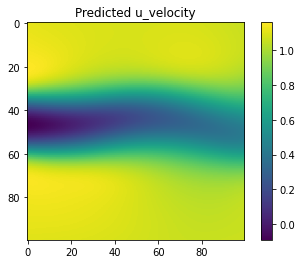

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.title("Predicted u_velocity")
plt.colorbar()

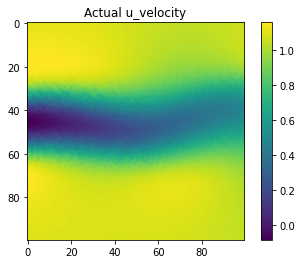

In [ ]:
upl=np.reshape(Y_star[0],(100,100))
plt.imshow(upl)
plt.title("Actual u_velocity")
plt.colorbar()